#  CM50265 Machine Learning 2

## Coursework 2: Deep learning
### Youssef Alami Mejjati, Jordan Taylor, Jake Deane and Mohammad Golbabaee


This coursework is worth 75 points from the overall mark of 100 for this unit. Marks are given beside each task. The report will be your main method of assessment. __Students should form groups of 3 individuals and submit one report per group.__ For this coursework students can choose their partners until __20th February__.  Each group will receive a total mark for this course work and individuals in that group will share this mark (with weights) according to their contributions.  

- The __submission deadline__ for your report is
__17th May 2020, 12:00: online Moodle submission of your final report__

The main part of your report should not exceed __3000 word limit__. After the main part please attach a Table of individuals’ contributions and appendices including ONLY the codes (these are excluded from the word limit). The report should be submitted in PDF format. __Table of contributions__ should include both students’ names/university IDs, the list of contributions of each student, and finally the contribution percentage for each student. This percentage should be agreed between both individuals and it will be used to weigh their marks. We highly encourage individuals to evenly share the workload. Further, you should __include all codes__ relevant to your implementations as an appendix or appendices with a clear referencing to the main body of your report. Codes must be well commented (indicating major steps).

First and foremost your report should demonstrate and evaluate your results. It must include figures and screenshots with appropriate resolutions. Evaluation can be qualitative (how it looks) and, wherever possible, quantitative (tested numerically). Second you should provide evidence that you understood the mathematics behind the assignment in each task/question. You should concisely explain your approach to solve each task/question, and the choices you make (e.g. hyper-parameters etc) for each part.

Usual university rules apply, please check your MSc program handbook, particularly regarding plagiarism and delayed deliveries. 

__Note:__ All tasks should be implemented in TensorFlow. Guidelines below (tasks 3-5, 7) should work for a TensorFlow version 1. If you use TF v2 please note that some syntaxes have changed during the recent update, but you can still use version compatiblity to resolve the issue. The list includes but might not be limited to:

tf.layers.conv2d -> tf.nn.conv2d

tf.layers.dense -> tf.nn.dense

tf.layers.flatten -> tf.compat.v1.layers.flatten

tf.variable_scope -> tf.compat.v1.variable_scope

tf.get_collection -> tf.compat.v1.get_collection

similarly for tf.compat.v1.InteractiveSession, tf.compat.v1.train.AdamOptimizer, tf.compat.v1.placeholder, tf.compat.v1.global_variables_initializer, tf.compat.v1.local_variables_initializer, tf.compat.v1.train.Saver, tf.compat.v1.summary.FileWriter, tf.compat.v1.trainable_variables

See TF web documentation in case you encounter version incompatibility. 

Guides on tasks 6 and 8 should be already compatible with TF2. 


## The coursework 


In [429]:
import warnings
warnings.filterwarnings('ignore')

try:
    import tensorflow.compat.v1 as tf
    tf.disable_eager_execution()
except:
    import tensorflow as tf
    
# import tensorflow as tf # This may laod Tensorflow 2.0.0 if that is the verison of the package on your distribution
#use import tensorflow.compat.v1 as tf for tensorflow 1
# tf.disable_v2_behaviour() # Only needed if using tensorflow 1 with tensorflow 2 being the package avlaiable  
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
%matplotlib inline



In [316]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

We scale the data to be in $[-1,1]$.

In [317]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

The size of each data points is $28 \times 28$. While this format will be useful when using CNNs, we will vectorize the datapoints for visualization and preliminary questions.

In [318]:
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

### 1. Data visualisation (5 points)
Project the training data points in a 2D space using PCA. Use the obtained 2D embedding and plot the training data-points with different markers or colors for each class (you are allowed to use PCA from scikit learn). 
- Why PCA is a good option to visualize data? 
- Add this plot in your report and discuss your observations. 
- Which classes can be linearly separated?


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

plt.figure(figsize=(12,6))
marker= ['+', 'x','|','_','s','8','v','^','1','2']

print('Variation per Principal Component: {}'.format(pca.explained_variance_ratio_))

for i in range (10):
    plt.scatter(x_train_pca[y_train == i+1,0],
                x_train_pca[y_train == i+1,1],
                alpha = 0.45, s = 15,
                marker=marker[i],
                label = i)

plt.title('Traing Data - 2D PCA Scatter')
plt.xlabel('pca-one')
plt.ylabel('pca-two')
plt.legend()
plt.show()

Variation per Principal Component: [0.09704664 0.07095924]


### 2. Perceptrons: (10 points)
Single Layer Perceptron is one of the most basic binary classifiers one can use. In this part of the CW you should implement an iterative algorithm for training the Single Layer Perceptron.

As we are dealing with a binary classification problem, we will pick data points corresponding to classes 0 and 1 (handwritten digits). In addition we choose our binary labels to be -1 and 1, respectively.

In [6]:
#defining the train
cond = (y_train == 0) + (y_train == 1)
binary_x_train = x_train[cond,:]
binary_y_train = y_train[cond]*1.
binary_y_train[binary_y_train == 0] = -1
binary_y_train[binary_y_train == 1] = 1

#defining the test
cond = (y_test == 0) + (y_test == 1)
binary_x_test = x_test[cond,:]
binary_y_test = y_test[cond]*1.
binary_y_test[binary_y_test == 0] = -1
binary_y_test[binary_y_test == 1] = 1

#### Task 2.1
Complete the function 'predict' below.
#### inputs:

+ $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
+ $w \in\mathbb{R^m}$ is the parameter vector we wish to learn. 
+ $b \in\mathbb{R}$ is the corresponding bias.

#### outputs: 
+ 'prediction'$\in\mathbb{R^n}$, a vector containing prediction values associated with $x$. 

In [7]:
def predict(x, w, b):
    ######### Complete the function- x point ######### 
    linear_comb = np.dot(x, w) + b
    if linear_comb > 0:
        return 1
    else:
        return -1

#### Task 2.2
+ Use the funtion 'predict' above to implement the Single Layer Perceptron algorithm by completing the function 'optimize' defined below.
    #### inputs:

    + $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
    + $w \in\mathbb{R^m}$ is the initial parameter vector.
    + $b \in\mathbb{R}$ is the initial bias value.
    + $y\in\mathbb{R^n}$ is the training labels associated with x.
    #### outputs:
    + $w$ is the optimized parameter vector.
    + $b$ the corresponding learned bias.
    + $\text{error}$ is the classification error obtained.  
    
    
 
    
Use the learned parameters $w$, $b$ (obtained via function 'optimize') and the function 'predict' to return the classification accuracy on the test set using x_train and y_train as training data. 

- Demonstrate that your algorithm converges to a good local minima. Plot the training error curve vs. number of iterations. 
- Show what feature $w$ has learned and discuss why? (demonstrate $w$ as an image with the same size as inputs).

- Repeat this training/testing procedure to classify different pairs. Report the accuracies of 5 pairs in a Table and dicuss why some are easier to classify than others.


In [8]:
def predict_many(x, w, b):
    pred = np.empty(len(x))
    for i in range(len(x)):
        pred[i] = predict(x[i], w, b)
    return pred

In [9]:
def loss(pred, y):
    loss = 0
    for pred_i, y_i in zip(pred, y):
        if pred_i != y_i:
            loss += 1
    return loss/len(pred)

In [10]:
def optimize(x, y, lr=0.003):
    iter = 0
    error=np.inf
    n, m = x.shape
    w = np.random.rand(m) # Initialize the w vector
    b = np.random.rand()  # Initialize the b vector
    hist = []
    while (iter <= 1000) & (error > 1e-3):
        idx = np.random.randint(n) # Get random index to update
        prediction = predict(x[idx], w, b) # Predict one to update the bias
        if prediction == y[idx]:
            continue
        err = y[idx] - prediction
        w = w + lr * y[idx] * x[idx] # Update weights
        b += lr * err # Update bias
        if iter % 1 == 0: # Change when the loss is recorded and calculated
            pred = predict_many(x, w, b)
            error = loss(pred, y) # Update error
            hist.append(error)
        iter += 1
    return w, b, error, hist

Classification Accuracy = 99.91%



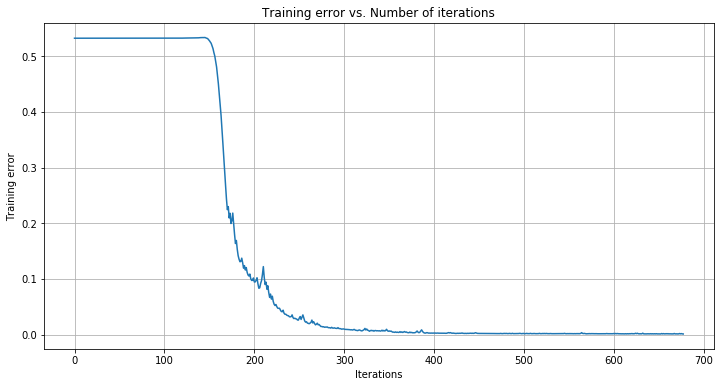

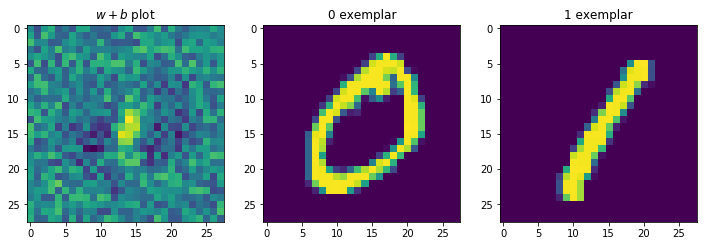

In [11]:
# optimising/training the single layer perceptron
the_w, the_b, training_error, hist = optimize(binary_x_train, binary_y_train)

# Use the learned parameters 𝑤, 𝑏 to predict and eturn the classification accuracy on the test set using x_train and y_train as training data.
binary_x_pred = predict_many(binary_x_test, the_w, the_b)
binary_xy = binary_x_pred  == binary_y_test
accuracy = sum(binary_xy)/len(binary_xy)
print(f"Classification Accuracy = {accuracy*100:.2f}%".format(5))
print('')

# plotting training error curve vs. number of iterations
plt.figure(figsize=(12,6))
plt.plot(hist)
plt.grid()
plt.title("Training error vs. Number of iterations")
plt.xlabel("Iterations")
plt.ylabel("Training error")

# demonstrate 𝑤 as an image with the same size as inputs
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,6))
ax1.imshow((the_w + the_b).reshape(28, 28))
ax2.imshow(binary_x_train[binary_y_train == -1][0].reshape(28, 28))
ax3.imshow(binary_x_train[binary_y_train == 1][0].reshape(28, 28))
ax1.title.set_text('$w+b$ plot')
ax2.title.set_text('0 exemplar')
ax3.title.set_text('1 exemplar')
plt.show()

In [12]:
def classify_pair(x1,x2):
    cond = (y_train == x1) + (y_train == x2)
    binary_x_train = x_train[cond,:]
    binary_y_train = y_train[cond]*1.
    binary_y_train[binary_y_train == x1] = -1
    binary_y_train[binary_y_train == x2] = 1
    
    cond = (y_test == x1) + (y_test == x2)
    binary_x_test = x_test[cond,:]
    binary_y_test = y_test[cond]*1.
    binary_y_test[binary_y_test == x1] = -1
    binary_y_test[binary_y_test == x2] = 1
    
    the_w, the_b, training_error, hist = optimize(binary_x_train, binary_y_train, lr=0.003)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,6))
    ax1.imshow((the_w + the_b).reshape(28, 28))
    
    ax2.imshow(binary_x_train[binary_y_train == -1][0].reshape(28, 28))
    ax3.imshow(binary_x_train[binary_y_train == 1][0].reshape(28, 28))
    ax1.title.set_text('$w+b$ plot')
    ax2.title.set_text(str(x1)+' exemplar')
    ax3.title.set_text(str(x2)+' exemplar')
    plt.show()
    
    binary_x_pred = predict_many(binary_x_test, the_w, the_b)
    binary_xy = binary_x_pred  == binary_y_test
    accuracy = sum(binary_xy)/len(binary_xy)
    return accuracy

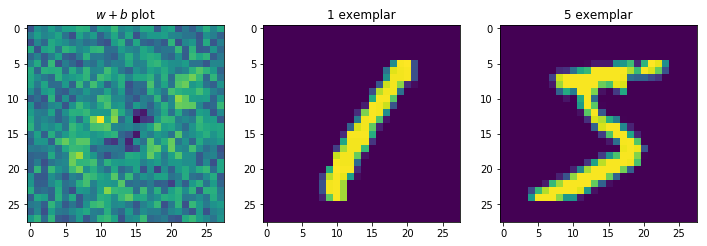

Classification Accuracy = 99.26%


In [13]:
acc1 = classify_pair(1,5)
print(f"Classification Accuracy = {acc1*100:.2f}%".format(5))

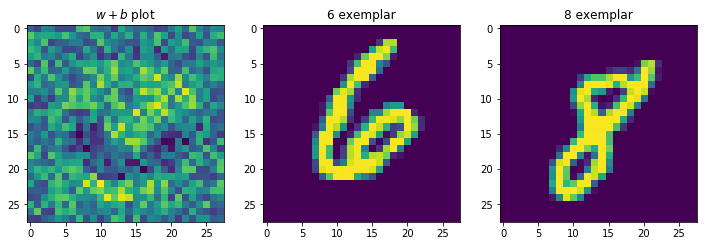

Classification Accuracy = 98.55%


In [14]:
acc2 = classify_pair(6,8)
print(f"Classification Accuracy = {acc2*100:.2f}%".format(5))

In [15]:
acc3 = classify_pair(6,2)
print(f"Classification Accuracy = {acc3*100:.2f}%".format(5))

Classification Accuracy = 97.74%


In [16]:
acc4 = classify_pair(7,1)
print(f"Classification Accuracy = {acc4*100:.2f}%".format(5))

Classification Accuracy = 99.12%


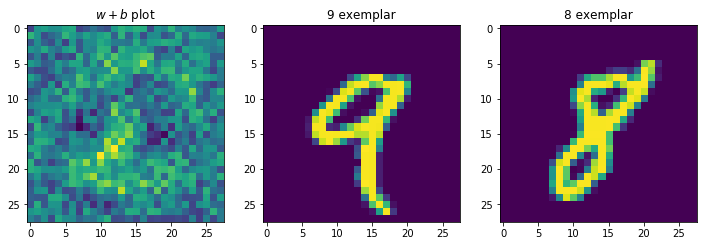

Classification Accuracy = 96.12%


In [17]:
acc5 = classify_pair(9,8)
print(f"Classification Accuracy = {acc5*100:.2f}%".format(5))

### 3: Multi Layer Perceptron (10 points)

Multi Layer Perceptron (MLP) is a fully connected deep (more than one hidden layer) network. In this part of the coursework we will implement a 2 hidden layers MLP with Recified Linear Unit (ReLU) activations. We will train the model via ADAM optimizer over a cross-entropy loss function.

First of all, we will convert our label vectors to matrices via one-hot encoding (e.g. $y=2$ would become $[0,0,1,0,0,0,0,0,0,0]$). This can be simply done using commands below:

In [18]:
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

Below, we define a class MLP. It is initialized via:  

+ x_train: The training matrix.
+ y_train: One hot encoding of the corresponding labels.
+ lr: Learning rate used for ADAM optimizer
+ nb_epochs: Number of epochs to use
+ batch_size: The number of data point in each mini-batch
+ output_dir: The directory where model parameters and tensorboard event files will be stored.

We also define the methods: 
* 'create_model' which will desribe a neural network architecture of the form $[784, 1000, 1000, 10]$, each integer representing the number of neurons in a given layer while the length of the vector defines the number of layers accordingly. 
* 'compute_loss' which given the output of 'create_model' will calculate the cross-entropy loss of the mini-batches.
* 'train' where we initiate a tensorflow session and perform the training iterations. 
* 'test' where we load our trained model and perform inference on the test set.

##### Task 3.1
- Complete the method 'create_model' in order to implement a network of the shape $[784, 1000, 1000, 10]$, use ReLU as the non linear activation for hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output __<font color='red'>without activation of the MLP.</font>__
   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
- You may use tf.layers.dense to implement a fully connected layer. 
- To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [19]:
class MLP_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 1000, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 1000, activation=tf.nn.relu)
            output = tf.layers.dense(hidden2, 10)
            
            self.logits = output # This is used in order to calculate the loss function
            self.preds = tf.nn.softmax(output) # This allows the model to be run and generate predictions
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

Now that we defined our model, our loss and its optimizer. we can instantate the MLP class, initiate our variables, and start the tensorflow session:

In [20]:
tf.reset_default_graph()

model = MLP_2(x_train, y_train, './MLP_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



We can now start training. We loop over the training data points and we feed them to the session in mini-batches form. we repeat this process several times (for several epochs). 

In [21]:
import time

t0 = time.time()
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        
        if np.mod(i, model.nb_iterations//3) == 0:
            print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
    print('')
# sess.close()
MLP_2_1_time = time.time() - t0

Epoch 0, Iteration 0, loss 2.352, batch accuracy 0.040
Epoch 0, Iteration 200, loss 0.145, batch accuracy 0.960
Epoch 0, Iteration 400, loss 0.290, batch accuracy 0.900

Epoch 1, Iteration 0, loss 0.131, batch accuracy 0.930
Epoch 1, Iteration 200, loss 0.107, batch accuracy 0.960
Epoch 1, Iteration 400, loss 0.086, batch accuracy 0.960

Epoch 2, Iteration 0, loss 0.008, batch accuracy 1.000
Epoch 2, Iteration 200, loss 0.050, batch accuracy 0.990
Epoch 2, Iteration 400, loss 0.242, batch accuracy 0.940

Epoch 3, Iteration 0, loss 0.019, batch accuracy 1.000
Epoch 3, Iteration 200, loss 0.090, batch accuracy 0.980
Epoch 3, Iteration 400, loss 0.040, batch accuracy 0.990

Epoch 4, Iteration 0, loss 0.075, batch accuracy 0.980
Epoch 4, Iteration 200, loss 0.098, batch accuracy 0.960
Epoch 4, Iteration 400, loss 0.094, batch accuracy 0.950



During and after training visualize the training and the created graph via tensorboard. Tensorboard is accessible via the command "tensorboard --logdir=#yourlogdir#". Check out https://www.tensorflow.org/guide/summaries_and_tensorboard for more details.

Similarly we loop over the test dataset and get the test accuracy via:

In [22]:
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
MLP_2_1_acc = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %MLP_2_1_acc)

Test accuracy achieved: 0.964



- Include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report.


We now close the tensorflow session:

In [23]:
sess.close()

##### Task 3.2
Using a similar format as before, discuss how the number of layers affects the classification accuracy. 
- Train four different networks with more hidden layers for example 3,4,5 and 7 hidden layers (choice is yours here to make a good conclusion). Choose an appropriate width i.e. number of neurons per layer so to achieve good accuracy and feasible training time. How many paramters (weights/biases) do these models have? How do they compare to the former MLP you implemented? 
- Compare the classification accuracies of these networks with the previous MLP.


- Plot a graph showing the accuracy vs. depth v.s. complexity (number of paramters) of the all five MLPs with different depths/widths. Additionally report the results in a Table. Discuss the results and provide conclusion. 


In [24]:
mlp_1 = [784, 1000, 1000, 10]
mlp_2 = [784, 650, 650, 650, 650, 10]
mlp_3 = [784, 1000, 1000, 1000, 1000, 10]
mlp_4 = [784, 400, 400, 400, 400, 400, 400, 10]
mlp_5 = [784, 525, 525, 525, 525, 525, 525, 10]
mlp_6 = [784, 350, 350, 350, 350, 350, 350, 350, 10]
mlp_7 = [784, 700, 600, 500, 400, 300, 200, 100, 10]

def MLP_complexity(mlp_shape):
    num_param = 0
 
    for i in range(1,len(mlp_shape)):
        num_param += mlp_shape[i]*mlp_shape[i-1]
        num_param += mlp_shape[i]

    return num_param

print('mlp_1 has %.f hidden layers and %.f paramters' %(len(mlp_1)-2, MLP_complexity(mlp_1)))
print('mlp_2 has %.f hidden layers and %.f paramters' %(len(mlp_2)-2, MLP_complexity(mlp_2)))
print('mlp_3 has %.f hidden layers and %.f paramters' %(len(mlp_3)-2, MLP_complexity(mlp_3)))
print('mlp_4 has %.f hidden layers and %.f paramters' %(len(mlp_4)-2, MLP_complexity(mlp_4)))
print('mlp_5 has %.f hidden layers and %.f paramters' %(len(mlp_5)-2, MLP_complexity(mlp_5)))
print('mlp_6 has %.f hidden layers and %.f paramters' %(len(mlp_6)-2, MLP_complexity(mlp_6)))
print('mlp_7 has %.f hidden layers and %.f paramters' %(len(mlp_7)-2, MLP_complexity(mlp_7)))


mlp_1 has 2 hidden layers and 1796010 paramters
mlp_2 has 4 hidden layers and 1786210 paramters
mlp_3 has 4 hidden layers and 3798010 paramters
mlp_4 has 6 hidden layers and 1120010 paramters
mlp_5 has 6 hidden layers and 1798135 paramters
mlp_6 has 7 hidden layers and 1015360 paramters
mlp_7 has 7 hidden layers and 1672610 paramters


In [25]:
def mlp_train_test(mlp_model,i):
    
    t0 = time.time()

    tf.reset_default_graph()
    model = mlp_model(x_train, y_train, './MLP_'+str(i)+'_logdir/', 0.001, 5, 100)
    model.create_model()
    model.compute_loss()
    model.optimizer()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)

    for epoch in range(model.nb_epochs):
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)  

    batch_size_test = 20
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    sess.close()
    
    return acc_test, time.time() - t0


In [26]:
class MLP_4_1: 
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 650, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 650, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 650, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 650, activation=tf.nn.relu)
            output = tf.layers.dense(hidden4, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [27]:
class MLP_4_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 1000, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 1000, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 1000, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 1000, activation=tf.nn.relu)
            output = tf.layers.dense(hidden4, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [28]:
class MLP_6_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 400, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 400, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 400, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 400, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 400, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden4, 400, activation=tf.nn.relu)
            output = tf.layers.dense(hidden5, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [29]:
class MLP_6_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 525, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 525, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 525, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 525, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 525, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 525, activation=tf.nn.relu)
            output = tf.layers.dense(hidden6, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [30]:
class MLP_7_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 350, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 350, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 350, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 350, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 350, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 350, activation=tf.nn.relu)
            hidden7 = tf.layers.dense(hidden6, 350, activation=tf.nn.relu)
            output = tf.layers.dense(hidden7, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [31]:
class MLP_7_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 480, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 480, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 480, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 480, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 480, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 480, activation=tf.nn.relu)
            hidden7 = tf.layers.dense(hidden6, 480, activation=tf.nn.relu)
            output = tf.layers.dense(hidden7, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [32]:
print('depth = 2, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_1), MLP_2_1_acc, MLP_2_1_time))

MLP_4_1_acc, MLP_4_1_time = mlp_train_test(MLP_4_1,1)
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_2), MLP_4_1_acc, MLP_4_1_time))
MLP_4_2_acc, MLP_4_2_time = mlp_train_test(MLP_4_2,2)
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_3), MLP_4_2_acc, MLP_4_2_time))

MLP_6_1_acc, MLP_6_1_time = mlp_train_test(MLP_6_1,3)
print('depth = 6, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_4), MLP_6_1_acc, MLP_6_1_time))
MLP_6_2_acc, MLP_6_2_time = mlp_train_test(MLP_6_2,4)
print('depth = 6, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_5), MLP_6_2_acc, MLP_6_2_time))

MLP_7_1_acc, MLP_7_1_time = mlp_train_test(MLP_7_1,5)
print('depth = 7, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_6), MLP_7_1_acc, MLP_7_1_time))
MLP_7_2_acc, MLP_7_2_time = mlp_train_test(MLP_7_2,6)
print('depth = 7, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_7), MLP_7_2_acc, MLP_7_2_time))

depth = 2, paramters = 1796010, accuracy = 0.9642, time = 10.14
depth = 4, paramters = 1786210, accuracy = 0.9717, time = 11.67
depth = 4, paramters = 3798010, accuracy = 0.9621, time = 15.39
depth = 6, paramters = 1120010, accuracy = 0.9561, time = 9.19
depth = 6, paramters = 1798135, accuracy = 0.9726, time = 12.01
depth = 7, paramters = 1015360, accuracy = 0.9629, time = 10.33
depth = 7, paramters = 1672610, accuracy = 0.9690, time = 11.99


### 4. Convolutional Neural Network (10 points)
Now that we are more familiar with the MLP algorithm, it is time to see how it compares with a Convolutional Neural Network (CNN). CNNs leverage dependencies between neighbouring pixels, making them more efficient and light weight compared to their fully connected counter part. In this section we will implement a Class CNN similar to the one we defined before for MLP.

##### Task 4.1
Complete the function 'create_model' of the class CNN above. Implement a CNN of the shape [32, 64, 128]; where 32, 64, 128 represent the number of convolutional filters for each hidden layer. We will use a kernel size of size $4\times4$. 

Use a stride of 1 in the first convolutional layer, followed by a stride of 2 for the following layers (a stride of two help downsampling without requiring the use of pooling layers). Vectorize the obtained output using tf.layer.flatten, and end the model with a fully connected layer of 10 neurons. Use ReLU as the non linear activation for the hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 

   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
+ You may use tf.layers.conv2d to implement a convolutional layer. 
+ To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [33]:
class CNN_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            ######### Complete the function ######### 
            # We save the hidden layers inside as attributes from the object so 
            # they can be called layer for visualization
            self.hidden1 = tf.layers.conv2d(self.im, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3') 
            # After 3 convolutional filters we flatten the array
            flattened = tf.layers.flatten(self.hidden3)
            # We feed it to a dense network to adquire the logits
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output) # This allows the model to be run and generate predictions
            #########################################
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

CNNs leverage dependencies between neighbouring pixels, however this information is partially lost when we vectorized our data. For training CNNs we will need to recover our initial shape of $N \times 28 \times 28$.

In [324]:
edge = int(np.sqrt(nb_features))
x_train.resize([n_train, edge, edge])
x_test.resize([n_test, edge, edge])

We instantiate our CNN class, start the corresponging tensorflow session and initiate the trainable variables. 

In [35]:
tf.reset_default_graph()

model = CNN_1(x_train, y_train, './CNN_1_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

We start training:

In [36]:
t0 = time.time()
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        if np.mod(i, model.nb_iterations//3) == 0:
            print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
    print('')
# sess.close()
CNN_1_time = time.time() - t0

Epoch 0, Iteration 0, loss 2.306, batch accuracy 0.070
Epoch 0, Iteration 200, loss 0.120, batch accuracy 0.960
Epoch 0, Iteration 400, loss 0.093, batch accuracy 0.980

Epoch 1, Iteration 0, loss 0.114, batch accuracy 0.960
Epoch 1, Iteration 200, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 400, loss 0.031, batch accuracy 0.980

Epoch 2, Iteration 0, loss 0.009, batch accuracy 1.000
Epoch 2, Iteration 200, loss 0.077, batch accuracy 0.970
Epoch 2, Iteration 400, loss 0.018, batch accuracy 0.990

Epoch 3, Iteration 0, loss 0.008, batch accuracy 1.000
Epoch 3, Iteration 200, loss 0.011, batch accuracy 1.000
Epoch 3, Iteration 400, loss 0.038, batch accuracy 0.980

Epoch 4, Iteration 0, loss 0.008, batch accuracy 1.000
Epoch 4, Iteration 200, loss 0.024, batch accuracy 0.990
Epoch 4, Iteration 400, loss 0.007, batch accuracy 1.000



we loop over the test dataset and compute the corresponding classification accuracy. 

- Similar to Task 3.1, include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report. 

In [37]:
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    input_x_test = input_x_test[:, :, :,np.newaxis]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
CNN_1_acc = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %CNN_1_acc)

Test accuracy achieved: 0.991


In [38]:
sess.close()

##### Task 4.2
Similar to task 3.2, discuss 
- Plot a graph showing complexity (number of paramters) vs. accuracy vs. depth of networks. For this part you need to train four additional CNNs of different depths/widths (again, your choice) and report the results in a Table. Discuss the results and provide conclusion.


- In addition discuss and analyze the differences in term of performance, number of model parameters (i.e. weights/biases) and training/testing times between CNNs and MLPs. Provide a concusion. (For these discussions you should compare your results in Table 4.2 to Table 3.2)

In [39]:
cnn_1 = [32, 64, 128]
cnn_2 = [16, 32, 64, 128]
cnn_3 = [16, 16, 32, 64, 128]
cnn_4 = [9, 16, 36, 64]
cnn_5 = [64, 128, 256]

def CNN_complexity(cnn_shape):

    num_param = cnn_shape[0] * 4 * 4 + cnn_shape[0] # input has 1 channel with no parameters to learn
 
    for i in range(1,len(cnn_shape)):
        num_param += cnn_shape[i]*cnn_shape[i-1] * 16 #size of kernel is 4*4
        num_param += cnn_shape[i] #adding biases
    num_param += 10 * 28 * 28 *cnn_shape[-1] + 10 #final dense layer into the output for 28x28 images
    return num_param

print('cnn_1 has %.f convolutional layers and %.f paramters' %(len(cnn_1), CNN_complexity(cnn_1)))
print('cnn_2 has %.f convolutional layers and %.f paramters' %(len(cnn_2), CNN_complexity(cnn_2)))
print('cnn_3 has %.f convolutional layers and %.f paramters' %(len(cnn_3), CNN_complexity(cnn_3)))
print('cnn_4 has %.f convolutional layers and %.f paramters' %(len(cnn_4), CNN_complexity(cnn_4)))
print('cnn_5 has %.f convolutional layers and %.f paramters' %(len(cnn_5), CNN_complexity(cnn_5)))


cnn_1 has 3 convolutional layers and 1168106 paramters
cnn_2 has 4 convolutional layers and 1176058 paramters
cnn_3 has 5 convolutional layers and 1180170 paramters
cnn_4 has 4 convolutional layers and 550423 paramters
cnn_5 has 3 convolutional layers and 2663882 paramters


In [40]:
def cnn_train_test(cnn_model, i):
    t0 = time.time()
    tf.reset_default_graph()
    model = cnn_model(x_train, y_train, './CNN_'+str(i)+'_logdir/', 0.001, 5, 100)
    model.create_model()
    model.compute_loss()
    model.optimizer()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)

    for epoch in range(model.nb_epochs):
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)  

    batch_size_test = 20
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        input_x_test = input_x_test[:, :, :,np.newaxis]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    
    sess.close()
    
    return acc_test, time.time() - t0

In [41]:
class CNN_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            flattened = tf.layers.flatten(self.hidden4)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [42]:
class CNN_3:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            self.hidden5 = tf.layers.conv2d(self.hidden4, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d5')
            flattened = tf.layers.flatten(self.hidden5)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [43]:
class CNN_4:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 9, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 36, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            flattened = tf.layers.flatten(self.hidden4)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [44]:
class CNN_5:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 256, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3') 
            flattened = tf.layers.flatten(self.hidden3)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [45]:
CNN_2_acc, CNN_2_time = cnn_train_test(CNN_2,2)
CNN_3_acc, CNN_3_time = cnn_train_test(CNN_3,3)
CNN_5_acc, CNN_5_time = cnn_train_test(CNN_5,5)

In [46]:
tf.reset_default_graph()

model = CNN_4(x_train, y_train, './CNN_4_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)
    
t0 = time.time()
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  

CNN_4_time = time.time() - t0

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    input_x_test = input_x_test[:, :, :,np.newaxis]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
CNN_4_acc = np.mean((all_preds==y_real)*1)

In [47]:
print('depth = 3, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_1), CNN_1_acc, CNN_1_time))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_2), CNN_2_acc, CNN_2_time))
print('depth = 5, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_3), CNN_3_acc, CNN_3_time))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_4), CNN_4_acc, CNN_4_time))
print('depth = 3, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_5), CNN_5_acc, CNN_5_time))

depth = 3, paramters = 1168106, accuracy = 0.9906, time = 22.86
depth = 4, paramters = 1176058, accuracy = 0.9889, time = 14.75
depth = 5, paramters = 1180170, accuracy = 0.9906, time = 20.28
depth = 4, paramters = 550423, accuracy = 0.9880, time = 11.09
depth = 3, paramters = 2663882, accuracy = 0.9906, time = 44.65


### 5. Visualizing learned filters and activations (6 points)
It is sometimes useful to visualize what kind of filters a CNN have learned. One way to do so is to plot each filter of size [kernel_size $\times$ kerne_size]. 

- Once your CNN (in Question 6) is trained, access its filters via 'tf.get_collection' and plot them on a grid for each layer. What patterns do you observe, why?
- In addition, plot the activations of each layer for two images chosen from digit-classes '2' and '9'. Discuss your observations

Hint: 
+ Activations are for example the outputs of tf.layers.conv2D.
+ Use tf.get_collection to access the learned filters of each layers. For this, you need to know how they are named (which can be accessed by tf.trainable_variables among other means of doing so).

The plotted feature maps and learned filters should be plotted in the same way as in the images bellow. (left: Feature Maps, right: learned Filters)

![Examples of activation maps (left), and learned features (right))](im.png)

In [48]:
tf.trainable_variables()

[<tf.Variable 'CNN/conv2d1/kernel:0' shape=(4, 4, 1, 9) dtype=float32_ref>,
 <tf.Variable 'CNN/conv2d1/bias:0' shape=(9,) dtype=float32_ref>,
 <tf.Variable 'CNN/conv2d2/kernel:0' shape=(4, 4, 9, 16) dtype=float32_ref>,
 <tf.Variable 'CNN/conv2d2/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'CNN/conv2d3/kernel:0' shape=(4, 4, 16, 36) dtype=float32_ref>,
 <tf.Variable 'CNN/conv2d3/bias:0' shape=(36,) dtype=float32_ref>,
 <tf.Variable 'CNN/conv2d4/kernel:0' shape=(4, 4, 36, 64) dtype=float32_ref>,
 <tf.Variable 'CNN/conv2d4/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'CNN/dense/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'CNN/dense/bias:0' shape=(10,) dtype=float32_ref>]

In [49]:
import math
import matplotlib.gridspec as gridspec

def getActivations(model, image, layer):
    units = sess.run(layer, feed_dict={model.im: image})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    n_columns = int(round(np.sqrt(filters)+0.4,0))
    n_rows = math.ceil(filters / n_columns) + 1
    plt.figure(1, figsize=(4.5,6))
    gs = gridspec.GridSpec(n_rows, n_columns,wspace=0.025, hspace=0.025)
    
    for i in range(filters):
        ax1 = plt.subplot(gs[i])
        ax1.imshow(units[0,:,:,i], cmap="gray")
        ax1.axis('off')
    plt.show()

INPUT EXEMPLAR


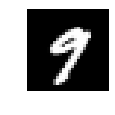

FIRST HIDDEN LAYER


SECOND HIDDEN LAYER


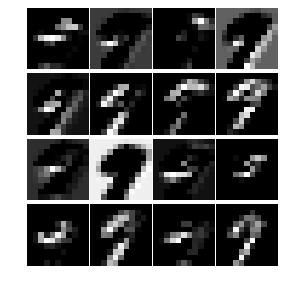

THIRD HIDDEN LAYER


FOURTH HIDDEN LAYER


In [50]:
print("INPUT EXEMPLAR")
plt.figure(1, figsize=(1.5,1.5))
plt.imshow(x_test[20], cmap="gray")
plt.axis('off')
plt.show()
print("FIRST HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden1)
print("SECOND HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden2)
print("THIRD HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden3)
print("FOURTH HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden4)

INPUT EXEMPLAR


FIRST HIDDEN LAYER


SECOND HIDDEN LAYER


THIRD HIDDEN LAYER


FOURTH HIDDEN LAYER


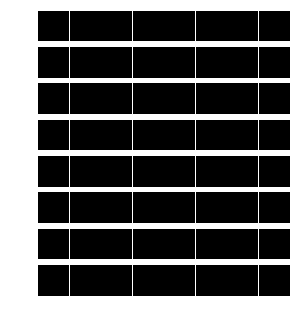

In [51]:
print("INPUT EXEMPLAR")
plt.figure(1, figsize=(1.5,1.5))
plt.imshow(x_test[22], cmap="gray")
plt.axis('off')
plt.show()
print("FIRST HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden1)
print("SECOND HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden2)
print("THIRD HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden3)
print("FOURTH HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden4)

FILTERS OF LAYER 1
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


FILTERS OF LAYER 2


FILTERS OF LAYER 3


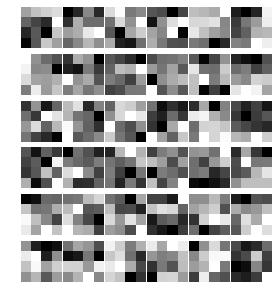

FILTERS OF LAYER 4


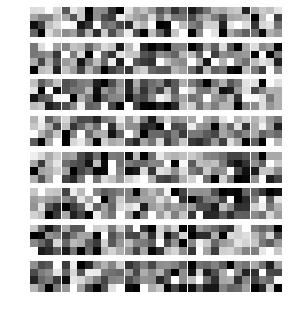

In [52]:
def plot_filters(filters):
    num_filters = filters.shape[3]
    n_columns = int(round(np.sqrt(num_filters)+0.4,0))
    n_rows = math.ceil(num_filters/n_columns) + 1
    fig = plt.figure(1, figsize=(4.5, 6))
    gs = gridspec.GridSpec(n_rows, n_columns,wspace=0.025, hspace = 0.025)

    for i in range(num_filters):
        ax1 = plt.subplot(gs[i])
        ax1.imshow(filters[:, :, 0, i], cmap="gray", aspect='equal')
        ax1.axis('off')
    plt.show()

for i in range(1, 5):
    print("FILTERS OF LAYER {}".format(i))
    layer = tf.get_collection(tf.GraphKeys.VARIABLES, 'CNN/conv2d{}/kernel:0'.format(i))[0]
    w1 = sess.run(layer)
    plot_filters(w1)


In [53]:
sess.close()

### 6. Multi Task Learning (12 points)

This question concerns the practice of multi-task learning (MTL). 
The aim of multi task learning is to leverage two (or more) related tasks in the learning process with the hope that leanring one task aids perfromance in learning the other task(s) and thus improves predicitve power for at least one (ideally all) of the tasks. 

There are two distinct flavours of MTL: Hard parameter  sharing and soft parameter sharing. We will be focusing on the former in this question.
Hard paramter sharing occurs when two tasks share a common network which then splits into task specific paths (e.g. a series of convolutional layers with two paths of dense layers for two seperate tasks). 

In this question, you will explore the FASHION MNIST dataset and be coding up your own MTL model and considering the pros and cons of MTL compared to single task learning. 

We have written the code to pre-load this dataset and split it into two related tasks for you:

- Task 1 - Clothing item 10 class classification (e.g. shoes, t-shirts etc) across 10 goups - $ y \in \mathbb{R^{10}} $
- Task 2 - Clothing group three class classification - predicitng whether a viewed clothing image belongs to one of three groups - $ y \in \mathbb{R^{3}} $
    - These groups are shoes (Sandal, Sneaker and Ankle Boot),  Gendered (Dress, Shirt and Bag) and Uni-Sex (T-shirt, Trouser, Pullover and Coat). 


#### Note : Alternativley use the tf.nn module. 

#### Note  : We advise the use of only a single epoch for this question for the sake of computation time.  However, if you want to utilise additional epochs feel free to do so just be aware of the longer training time and be consistent over all networks. 

In [297]:
"""
Code for loading the dataset
"""
import keras.datasets.fashion_mnist as fashion_mnist
from keras.utils import to_categorical

def load_data(): 
    # train_X: (60000, 28, 28)
    # train_y: (60000,)
    # test_X: (10000, 28, 28)
    # test_y: (10000,)
    (train_X, train_y_1), (test_X, test_y_1) = fashion_mnist.load_data()
    n_class_1 = 10
    # map to new label
    train_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in train_y_1)  
    test_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in test_y_1)
    n_class_2 = 3
    # train_X: (60000, 28, 28, 1)
    # test_X: (10000, 28, 28, 1)
    # train_y: (60000, n_class = 10)
    # test_y: (10000, n_class = 3)
    train_X = np.expand_dims(train_X, axis=3)
    test_X = np.expand_dims(test_X, axis=3)
    train_y_1 = to_categorical(train_y_1, n_class_1)
    test_y_1 = to_categorical(test_y_1, n_class_1)
    train_y_2 = to_categorical(train_y_2, n_class_2)
    test_y_2 = to_categorical(test_y_2, n_class_2)
    return train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2


x_train_fashion, y_train_1, y_train_2, x_test_fashion, y_test_1, y_test_2 = load_data()

#### Task 6.1

In this question you will construct two seperate networks of identical structure (excpet the logits and pred layers) one for each of the two tasks.

In other words, create a network for item classification and a network for item group classification. 


Complete the Task_1_NN and Task_2_NN below. These single task networks will form the basis of your work in this question. 

For the sake of convieience, we will use the same CNN filters as Question 4 - $[32, 64, 128]$. However our kernel size will be 3 $\times$ 3 and a stride of 1 for all convolutional layers. Maxpooling layers will also need to be implemented after the first and second convolutional layers. These maxpooling layers have a kernel size of two and a stride of 2. 

After the final convolution, flatten the outputs and pass them to dense layers $[3136, 1024, 100 , N]$ where $N$ is the number of outputs required (10 or 3). 

As with Question 4, the function 'create_model' to be cpomplemted defines the class variables:
 - Task 1
     - self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected (i.e. dense) layer</font>.__ 
     - self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.
 - Task 2
      - self.logits $\in \mathbb{R^{3}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 
      - self.preds $\in \mathbb{R^{3}}$ containing posterior probabilities.
      
The method definitons remain the same  as in previous questions. 
      
      
#### Note: We advise you save the number of parameters and accuracy of the models in order to save time later. 

In [298]:
class Task_1_NN():
    def __init__(self, x_train, y_train_1,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
    
    def create_model(self):            
        with tf.variable_scope("Task_1", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            self.pool3 = tf.layers.max_pooling2d(self.hidden3, pool_size=2, strides=2)
            
            flattened = tf.layers.flatten(self.pool3)
            # We feed it to a dense network to adquire the logits
            self.dense1 = tf.layers.dense(flattened, 3136)
            self.dense2 = tf.layers.dense(self.dense1, 1024)
            self.dense3 = tf.layers.dense(self.dense2, 100)
            self.output = tf.layers.dense(self.dense3, 10)

            
            ######### Complete the function ######### 
            self.logits = self.output
            self.pred_1 = tf.nn.softmax(self.logits) # This allows the model to be run and generate predictions
            #########################################
                
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_1, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_1) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_1, var_list=self.model_vars)
            


In [299]:
class Task_2_NN():
    def __init__(self, x_train, y_train_2,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_2 = y_train_2
        self.m = x_train.shape[0]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")
    
    def create_model(self):            
        with tf.variable_scope("Task_2", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            self.pool3 = tf.layers.max_pooling2d(self.hidden3, pool_size=2, strides=2)
            
            flattened = tf.layers.flatten(self.pool3)
            # We feed it to a dense network to adquire the logits
            self.dense1 = tf.layers.dense(flattened, 3136)
            self.dense2 = tf.layers.dense(self.dense1, 1024)
            self.dense3 = tf.layers.dense(self.dense2, 100)
            self.output = tf.layers.dense(self.dense3, 3)

            
            ######### Complete the function ######### 
            self.logits = self.output
            self.pred_2 = tf.nn.softmax(self.logits) # This allows the model to be run and generate predictions
            #########################################
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_2, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_2) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_2, var_list=self.model_vars)

#### Now train and test Task 1:

In [300]:
import time
tf.reset_default_graph()


model_1 = Task_1_NN(x_train_fashion, y_train_1, './Task1_logdir/', 0.001, 2, 10)            
model_1.create_model()     

model_1.compute_loss()
model_1.optimizer()   

model_1.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_1.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_1.output_dir):
    os.makedirs(model_1.output_dir)  

"""
Train
"""

for epoch in range(model_1.nb_epochs):
    randomize = np.arange(x_train_fashion.shape[0])
    np.random.shuffle(randomize)
    x_in = model_1.x_train[randomize,:]
    y_in_1 = model_1.y_train_1[randomize,:]
    for i in range(model_1.nb_iterations):
        input_x_train = x_in[i*model_1.batch_size: (i+1)*model_1.batch_size]
        input_y_train_1 = y_in_1[i*model_1.batch_size: (i+1)*model_1.batch_size]
        _ , preds_1, loss_1, loss_summ = sess.run([model_1.trainer, model_1.pred_1,  model_1.loss_task_1, model_1.loss_summ], 
                                 feed_dict={model_1.X: input_x_train, 
                                            model_1.y_1: input_y_train_1})

        y_preds_1 = np.argmax(preds_1, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        print('Epoch %d, Iteration %d, loss_1 %.3f,  batch accuracy_1 %.3f' %(epoch, i, loss_1,acc_train_1))
        writer.add_summary(loss_summ, epoch * model_1.nb_iterations + i)
    saver.save(sess, model_1.output_dir, global_step=epoch) 
end = time.time()

Epoch 0, Iteration 0, loss_1 15.819,  batch accuracy_1 0.000
Epoch 0, Iteration 1, loss_1 76.458,  batch accuracy_1 0.100
Epoch 0, Iteration 2, loss_1 242.420,  batch accuracy_1 0.000
Epoch 0, Iteration 3, loss_1 266.548,  batch accuracy_1 0.100
Epoch 0, Iteration 4, loss_1 29.103,  batch accuracy_1 0.000
Epoch 0, Iteration 5, loss_1 14.416,  batch accuracy_1 0.300
Epoch 0, Iteration 6, loss_1 8.935,  batch accuracy_1 0.500
Epoch 0, Iteration 7, loss_1 24.791,  batch accuracy_1 0.100
Epoch 0, Iteration 8, loss_1 8.407,  batch accuracy_1 0.200
Epoch 0, Iteration 9, loss_1 6.765,  batch accuracy_1 0.300
Epoch 0, Iteration 10, loss_1 3.707,  batch accuracy_1 0.600
Epoch 0, Iteration 11, loss_1 3.292,  batch accuracy_1 0.500
Epoch 0, Iteration 12, loss_1 3.028,  batch accuracy_1 0.200
Epoch 0, Iteration 13, loss_1 3.669,  batch accuracy_1 0.400
Epoch 0, Iteration 14, loss_1 4.760,  batch accuracy_1 0.400
Epoch 0, Iteration 15, loss_1 2.547,  batch accuracy_1 0.100
Epoch 0, Iteration 16, lo

Epoch 0, Iteration 141, loss_1 0.743,  batch accuracy_1 0.800
Epoch 0, Iteration 142, loss_1 1.835,  batch accuracy_1 0.400
Epoch 0, Iteration 143, loss_1 2.776,  batch accuracy_1 0.400
Epoch 0, Iteration 144, loss_1 1.243,  batch accuracy_1 0.600
Epoch 0, Iteration 145, loss_1 2.056,  batch accuracy_1 0.200
Epoch 0, Iteration 146, loss_1 2.087,  batch accuracy_1 0.300
Epoch 0, Iteration 147, loss_1 1.472,  batch accuracy_1 0.600
Epoch 0, Iteration 148, loss_1 1.441,  batch accuracy_1 0.300
Epoch 0, Iteration 149, loss_1 3.110,  batch accuracy_1 0.200
Epoch 0, Iteration 150, loss_1 1.462,  batch accuracy_1 0.300
Epoch 0, Iteration 151, loss_1 1.443,  batch accuracy_1 0.300
Epoch 0, Iteration 152, loss_1 1.378,  batch accuracy_1 0.400
Epoch 0, Iteration 153, loss_1 1.053,  batch accuracy_1 0.700
Epoch 0, Iteration 154, loss_1 0.994,  batch accuracy_1 0.400
Epoch 0, Iteration 155, loss_1 1.088,  batch accuracy_1 0.600
Epoch 0, Iteration 156, loss_1 1.506,  batch accuracy_1 0.400
Epoch 0,

Epoch 0, Iteration 319, loss_1 4.377,  batch accuracy_1 0.300
Epoch 0, Iteration 320, loss_1 0.654,  batch accuracy_1 0.900
Epoch 0, Iteration 321, loss_1 1.564,  batch accuracy_1 0.500
Epoch 0, Iteration 322, loss_1 0.958,  batch accuracy_1 0.700
Epoch 0, Iteration 323, loss_1 1.402,  batch accuracy_1 0.500
Epoch 0, Iteration 324, loss_1 1.249,  batch accuracy_1 0.500
Epoch 0, Iteration 325, loss_1 2.258,  batch accuracy_1 0.400
Epoch 0, Iteration 326, loss_1 2.577,  batch accuracy_1 0.400
Epoch 0, Iteration 327, loss_1 1.200,  batch accuracy_1 0.400
Epoch 0, Iteration 328, loss_1 3.135,  batch accuracy_1 0.200
Epoch 0, Iteration 329, loss_1 1.565,  batch accuracy_1 0.400
Epoch 0, Iteration 330, loss_1 1.234,  batch accuracy_1 0.400
Epoch 0, Iteration 331, loss_1 1.263,  batch accuracy_1 0.500
Epoch 0, Iteration 332, loss_1 1.079,  batch accuracy_1 0.500
Epoch 0, Iteration 333, loss_1 0.921,  batch accuracy_1 0.600
Epoch 0, Iteration 334, loss_1 1.422,  batch accuracy_1 0.600
Epoch 0,

Epoch 0, Iteration 471, loss_1 1.081,  batch accuracy_1 0.600
Epoch 0, Iteration 472, loss_1 1.347,  batch accuracy_1 0.600
Epoch 0, Iteration 473, loss_1 1.344,  batch accuracy_1 0.500
Epoch 0, Iteration 474, loss_1 5.571,  batch accuracy_1 0.300
Epoch 0, Iteration 475, loss_1 1.647,  batch accuracy_1 0.300
Epoch 0, Iteration 476, loss_1 1.262,  batch accuracy_1 0.400
Epoch 0, Iteration 477, loss_1 1.149,  batch accuracy_1 0.400
Epoch 0, Iteration 478, loss_1 0.783,  batch accuracy_1 0.700
Epoch 0, Iteration 479, loss_1 1.115,  batch accuracy_1 0.600
Epoch 0, Iteration 480, loss_1 1.034,  batch accuracy_1 0.700
Epoch 0, Iteration 481, loss_1 1.157,  batch accuracy_1 0.400
Epoch 0, Iteration 482, loss_1 1.403,  batch accuracy_1 0.500
Epoch 0, Iteration 483, loss_1 0.755,  batch accuracy_1 0.700
Epoch 0, Iteration 484, loss_1 0.634,  batch accuracy_1 0.800
Epoch 0, Iteration 485, loss_1 0.676,  batch accuracy_1 0.800
Epoch 0, Iteration 486, loss_1 1.284,  batch accuracy_1 0.500
Epoch 0,

Epoch 0, Iteration 636, loss_1 0.908,  batch accuracy_1 0.600
Epoch 0, Iteration 637, loss_1 0.754,  batch accuracy_1 0.700
Epoch 0, Iteration 638, loss_1 0.321,  batch accuracy_1 0.900
Epoch 0, Iteration 639, loss_1 0.710,  batch accuracy_1 0.800
Epoch 0, Iteration 640, loss_1 0.720,  batch accuracy_1 0.600
Epoch 0, Iteration 641, loss_1 0.630,  batch accuracy_1 0.700
Epoch 0, Iteration 642, loss_1 1.191,  batch accuracy_1 0.500
Epoch 0, Iteration 643, loss_1 0.554,  batch accuracy_1 0.700
Epoch 0, Iteration 644, loss_1 1.134,  batch accuracy_1 0.400
Epoch 0, Iteration 645, loss_1 1.129,  batch accuracy_1 0.600
Epoch 0, Iteration 646, loss_1 1.271,  batch accuracy_1 0.600
Epoch 0, Iteration 647, loss_1 1.473,  batch accuracy_1 0.800
Epoch 0, Iteration 648, loss_1 0.943,  batch accuracy_1 0.600
Epoch 0, Iteration 649, loss_1 1.017,  batch accuracy_1 0.600
Epoch 0, Iteration 650, loss_1 0.822,  batch accuracy_1 0.700
Epoch 0, Iteration 651, loss_1 0.623,  batch accuracy_1 0.800
Epoch 0,

Epoch 0, Iteration 792, loss_1 0.986,  batch accuracy_1 0.500
Epoch 0, Iteration 793, loss_1 1.422,  batch accuracy_1 0.400
Epoch 0, Iteration 794, loss_1 0.502,  batch accuracy_1 1.000
Epoch 0, Iteration 795, loss_1 0.939,  batch accuracy_1 0.500
Epoch 0, Iteration 796, loss_1 1.210,  batch accuracy_1 0.400
Epoch 0, Iteration 797, loss_1 1.291,  batch accuracy_1 0.400
Epoch 0, Iteration 798, loss_1 0.889,  batch accuracy_1 0.600
Epoch 0, Iteration 799, loss_1 1.298,  batch accuracy_1 0.500
Epoch 0, Iteration 800, loss_1 1.027,  batch accuracy_1 0.500
Epoch 0, Iteration 801, loss_1 0.594,  batch accuracy_1 0.700
Epoch 0, Iteration 802, loss_1 0.882,  batch accuracy_1 0.700
Epoch 0, Iteration 803, loss_1 1.638,  batch accuracy_1 0.500
Epoch 0, Iteration 804, loss_1 1.962,  batch accuracy_1 0.100
Epoch 0, Iteration 805, loss_1 0.706,  batch accuracy_1 0.600
Epoch 0, Iteration 806, loss_1 1.521,  batch accuracy_1 0.800
Epoch 0, Iteration 807, loss_1 0.645,  batch accuracy_1 0.700
Epoch 0,

Epoch 0, Iteration 957, loss_1 1.316,  batch accuracy_1 0.400
Epoch 0, Iteration 958, loss_1 1.357,  batch accuracy_1 0.600
Epoch 0, Iteration 959, loss_1 1.646,  batch accuracy_1 0.700
Epoch 0, Iteration 960, loss_1 0.842,  batch accuracy_1 0.800
Epoch 0, Iteration 961, loss_1 1.090,  batch accuracy_1 0.700
Epoch 0, Iteration 962, loss_1 0.722,  batch accuracy_1 0.700
Epoch 0, Iteration 963, loss_1 1.647,  batch accuracy_1 0.400
Epoch 0, Iteration 964, loss_1 0.691,  batch accuracy_1 0.600
Epoch 0, Iteration 965, loss_1 0.913,  batch accuracy_1 0.600
Epoch 0, Iteration 966, loss_1 0.541,  batch accuracy_1 0.800
Epoch 0, Iteration 967, loss_1 1.198,  batch accuracy_1 0.600
Epoch 0, Iteration 968, loss_1 1.265,  batch accuracy_1 0.500
Epoch 0, Iteration 969, loss_1 1.093,  batch accuracy_1 0.700
Epoch 0, Iteration 970, loss_1 1.624,  batch accuracy_1 0.500
Epoch 0, Iteration 971, loss_1 2.406,  batch accuracy_1 0.400
Epoch 0, Iteration 972, loss_1 1.016,  batch accuracy_1 0.600
Epoch 0,

Epoch 0, Iteration 1120, loss_1 1.393,  batch accuracy_1 0.700
Epoch 0, Iteration 1121, loss_1 1.334,  batch accuracy_1 0.700
Epoch 0, Iteration 1122, loss_1 0.708,  batch accuracy_1 0.700
Epoch 0, Iteration 1123, loss_1 1.099,  batch accuracy_1 0.700
Epoch 0, Iteration 1124, loss_1 0.999,  batch accuracy_1 0.500
Epoch 0, Iteration 1125, loss_1 0.467,  batch accuracy_1 0.900
Epoch 0, Iteration 1126, loss_1 0.653,  batch accuracy_1 0.700
Epoch 0, Iteration 1127, loss_1 2.049,  batch accuracy_1 0.500
Epoch 0, Iteration 1128, loss_1 0.685,  batch accuracy_1 0.800
Epoch 0, Iteration 1129, loss_1 1.189,  batch accuracy_1 0.400
Epoch 0, Iteration 1130, loss_1 0.784,  batch accuracy_1 0.600
Epoch 0, Iteration 1131, loss_1 0.619,  batch accuracy_1 0.800
Epoch 0, Iteration 1132, loss_1 0.193,  batch accuracy_1 1.000
Epoch 0, Iteration 1133, loss_1 0.784,  batch accuracy_1 0.800
Epoch 0, Iteration 1134, loss_1 1.154,  batch accuracy_1 0.600
Epoch 0, Iteration 1135, loss_1 1.567,  batch accuracy_

Epoch 0, Iteration 1281, loss_1 1.497,  batch accuracy_1 0.400
Epoch 0, Iteration 1282, loss_1 1.590,  batch accuracy_1 0.700
Epoch 0, Iteration 1283, loss_1 0.857,  batch accuracy_1 0.700
Epoch 0, Iteration 1284, loss_1 1.839,  batch accuracy_1 0.400
Epoch 0, Iteration 1285, loss_1 1.311,  batch accuracy_1 0.600
Epoch 0, Iteration 1286, loss_1 1.060,  batch accuracy_1 0.400
Epoch 0, Iteration 1287, loss_1 0.318,  batch accuracy_1 0.800
Epoch 0, Iteration 1288, loss_1 0.614,  batch accuracy_1 0.600
Epoch 0, Iteration 1289, loss_1 0.918,  batch accuracy_1 0.700
Epoch 0, Iteration 1290, loss_1 0.362,  batch accuracy_1 0.900
Epoch 0, Iteration 1291, loss_1 0.846,  batch accuracy_1 0.600
Epoch 0, Iteration 1292, loss_1 1.134,  batch accuracy_1 0.500
Epoch 0, Iteration 1293, loss_1 0.526,  batch accuracy_1 0.800
Epoch 0, Iteration 1294, loss_1 0.184,  batch accuracy_1 0.900
Epoch 0, Iteration 1295, loss_1 0.387,  batch accuracy_1 0.900
Epoch 0, Iteration 1296, loss_1 0.381,  batch accuracy_

Epoch 0, Iteration 1442, loss_1 0.637,  batch accuracy_1 0.600
Epoch 0, Iteration 1443, loss_1 1.128,  batch accuracy_1 0.600
Epoch 0, Iteration 1444, loss_1 0.551,  batch accuracy_1 0.700
Epoch 0, Iteration 1445, loss_1 1.041,  batch accuracy_1 0.500
Epoch 0, Iteration 1446, loss_1 0.550,  batch accuracy_1 0.700
Epoch 0, Iteration 1447, loss_1 0.640,  batch accuracy_1 0.800
Epoch 0, Iteration 1448, loss_1 1.295,  batch accuracy_1 0.700
Epoch 0, Iteration 1449, loss_1 0.867,  batch accuracy_1 0.700
Epoch 0, Iteration 1450, loss_1 0.610,  batch accuracy_1 0.800
Epoch 0, Iteration 1451, loss_1 1.089,  batch accuracy_1 0.700
Epoch 0, Iteration 1452, loss_1 0.725,  batch accuracy_1 0.600
Epoch 0, Iteration 1453, loss_1 0.536,  batch accuracy_1 0.700
Epoch 0, Iteration 1454, loss_1 0.483,  batch accuracy_1 0.900
Epoch 0, Iteration 1455, loss_1 0.625,  batch accuracy_1 0.800
Epoch 0, Iteration 1456, loss_1 0.888,  batch accuracy_1 0.700
Epoch 0, Iteration 1457, loss_1 1.407,  batch accuracy_

Epoch 0, Iteration 1602, loss_1 1.242,  batch accuracy_1 0.500
Epoch 0, Iteration 1603, loss_1 0.835,  batch accuracy_1 0.700
Epoch 0, Iteration 1604, loss_1 0.861,  batch accuracy_1 0.800
Epoch 0, Iteration 1605, loss_1 0.269,  batch accuracy_1 0.900
Epoch 0, Iteration 1606, loss_1 0.959,  batch accuracy_1 0.700
Epoch 0, Iteration 1607, loss_1 1.113,  batch accuracy_1 0.500
Epoch 0, Iteration 1608, loss_1 0.706,  batch accuracy_1 0.800
Epoch 0, Iteration 1609, loss_1 0.806,  batch accuracy_1 0.500
Epoch 0, Iteration 1610, loss_1 0.926,  batch accuracy_1 0.600
Epoch 0, Iteration 1611, loss_1 0.372,  batch accuracy_1 0.900
Epoch 0, Iteration 1612, loss_1 0.780,  batch accuracy_1 0.600
Epoch 0, Iteration 1613, loss_1 1.214,  batch accuracy_1 0.600
Epoch 0, Iteration 1614, loss_1 0.030,  batch accuracy_1 1.000
Epoch 0, Iteration 1615, loss_1 1.007,  batch accuracy_1 0.700
Epoch 0, Iteration 1616, loss_1 0.643,  batch accuracy_1 0.700
Epoch 0, Iteration 1617, loss_1 0.599,  batch accuracy_

Epoch 0, Iteration 1760, loss_1 0.700,  batch accuracy_1 0.900
Epoch 0, Iteration 1761, loss_1 0.531,  batch accuracy_1 0.800
Epoch 0, Iteration 1762, loss_1 0.530,  batch accuracy_1 0.800
Epoch 0, Iteration 1763, loss_1 0.888,  batch accuracy_1 0.400
Epoch 0, Iteration 1764, loss_1 0.794,  batch accuracy_1 0.700
Epoch 0, Iteration 1765, loss_1 1.461,  batch accuracy_1 0.400
Epoch 0, Iteration 1766, loss_1 0.721,  batch accuracy_1 0.600
Epoch 0, Iteration 1767, loss_1 0.619,  batch accuracy_1 0.700
Epoch 0, Iteration 1768, loss_1 0.660,  batch accuracy_1 0.700
Epoch 0, Iteration 1769, loss_1 0.786,  batch accuracy_1 0.800
Epoch 0, Iteration 1770, loss_1 0.413,  batch accuracy_1 0.800
Epoch 0, Iteration 1771, loss_1 2.057,  batch accuracy_1 0.600
Epoch 0, Iteration 1772, loss_1 0.876,  batch accuracy_1 0.400
Epoch 0, Iteration 1773, loss_1 0.576,  batch accuracy_1 0.700
Epoch 0, Iteration 1774, loss_1 1.673,  batch accuracy_1 0.600
Epoch 0, Iteration 1775, loss_1 0.873,  batch accuracy_

Epoch 0, Iteration 1926, loss_1 0.614,  batch accuracy_1 0.800
Epoch 0, Iteration 1927, loss_1 0.465,  batch accuracy_1 0.700
Epoch 0, Iteration 1928, loss_1 0.411,  batch accuracy_1 0.800
Epoch 0, Iteration 1929, loss_1 0.472,  batch accuracy_1 0.900
Epoch 0, Iteration 1930, loss_1 0.346,  batch accuracy_1 0.900
Epoch 0, Iteration 1931, loss_1 1.177,  batch accuracy_1 0.500
Epoch 0, Iteration 1932, loss_1 1.004,  batch accuracy_1 0.500
Epoch 0, Iteration 1933, loss_1 1.072,  batch accuracy_1 0.600
Epoch 0, Iteration 1934, loss_1 0.396,  batch accuracy_1 0.800
Epoch 0, Iteration 1935, loss_1 0.548,  batch accuracy_1 0.800
Epoch 0, Iteration 1936, loss_1 0.908,  batch accuracy_1 0.700
Epoch 0, Iteration 1937, loss_1 0.646,  batch accuracy_1 0.800
Epoch 0, Iteration 1938, loss_1 0.761,  batch accuracy_1 0.700
Epoch 0, Iteration 1939, loss_1 1.109,  batch accuracy_1 0.400
Epoch 0, Iteration 1940, loss_1 0.618,  batch accuracy_1 0.800
Epoch 0, Iteration 1941, loss_1 0.758,  batch accuracy_

Epoch 0, Iteration 2087, loss_1 1.063,  batch accuracy_1 0.500
Epoch 0, Iteration 2088, loss_1 1.327,  batch accuracy_1 0.500
Epoch 0, Iteration 2089, loss_1 0.923,  batch accuracy_1 0.600
Epoch 0, Iteration 2090, loss_1 1.068,  batch accuracy_1 0.600
Epoch 0, Iteration 2091, loss_1 0.330,  batch accuracy_1 0.700
Epoch 0, Iteration 2092, loss_1 0.479,  batch accuracy_1 0.900
Epoch 0, Iteration 2093, loss_1 0.652,  batch accuracy_1 0.800
Epoch 0, Iteration 2094, loss_1 0.555,  batch accuracy_1 0.800
Epoch 0, Iteration 2095, loss_1 0.207,  batch accuracy_1 1.000
Epoch 0, Iteration 2096, loss_1 1.126,  batch accuracy_1 0.800
Epoch 0, Iteration 2097, loss_1 0.186,  batch accuracy_1 0.900
Epoch 0, Iteration 2098, loss_1 1.411,  batch accuracy_1 0.400
Epoch 0, Iteration 2099, loss_1 0.837,  batch accuracy_1 0.600
Epoch 0, Iteration 2100, loss_1 0.781,  batch accuracy_1 0.800
Epoch 0, Iteration 2101, loss_1 0.950,  batch accuracy_1 0.700
Epoch 0, Iteration 2102, loss_1 1.052,  batch accuracy_

Epoch 0, Iteration 2247, loss_1 1.838,  batch accuracy_1 0.500
Epoch 0, Iteration 2248, loss_1 0.657,  batch accuracy_1 0.700
Epoch 0, Iteration 2249, loss_1 0.694,  batch accuracy_1 0.600
Epoch 0, Iteration 2250, loss_1 0.781,  batch accuracy_1 0.500
Epoch 0, Iteration 2251, loss_1 0.887,  batch accuracy_1 0.600
Epoch 0, Iteration 2252, loss_1 1.145,  batch accuracy_1 0.500
Epoch 0, Iteration 2253, loss_1 1.383,  batch accuracy_1 0.600
Epoch 0, Iteration 2254, loss_1 0.544,  batch accuracy_1 0.800
Epoch 0, Iteration 2255, loss_1 0.542,  batch accuracy_1 0.700
Epoch 0, Iteration 2256, loss_1 0.818,  batch accuracy_1 0.600
Epoch 0, Iteration 2257, loss_1 0.883,  batch accuracy_1 0.600
Epoch 0, Iteration 2258, loss_1 1.181,  batch accuracy_1 0.600
Epoch 0, Iteration 2259, loss_1 0.994,  batch accuracy_1 0.500
Epoch 0, Iteration 2260, loss_1 0.737,  batch accuracy_1 0.700
Epoch 0, Iteration 2261, loss_1 1.058,  batch accuracy_1 0.500
Epoch 0, Iteration 2262, loss_1 0.852,  batch accuracy_

Epoch 0, Iteration 2413, loss_1 0.832,  batch accuracy_1 0.700
Epoch 0, Iteration 2414, loss_1 0.919,  batch accuracy_1 0.600
Epoch 0, Iteration 2415, loss_1 0.902,  batch accuracy_1 0.600
Epoch 0, Iteration 2416, loss_1 0.978,  batch accuracy_1 0.500
Epoch 0, Iteration 2417, loss_1 0.655,  batch accuracy_1 0.600
Epoch 0, Iteration 2418, loss_1 0.769,  batch accuracy_1 0.700
Epoch 0, Iteration 2419, loss_1 0.501,  batch accuracy_1 0.900
Epoch 0, Iteration 2420, loss_1 0.954,  batch accuracy_1 0.600
Epoch 0, Iteration 2421, loss_1 0.936,  batch accuracy_1 0.600
Epoch 0, Iteration 2422, loss_1 0.873,  batch accuracy_1 0.400
Epoch 0, Iteration 2423, loss_1 1.043,  batch accuracy_1 0.500
Epoch 0, Iteration 2424, loss_1 0.484,  batch accuracy_1 1.000
Epoch 0, Iteration 2425, loss_1 0.783,  batch accuracy_1 0.700
Epoch 0, Iteration 2426, loss_1 0.663,  batch accuracy_1 0.700
Epoch 0, Iteration 2427, loss_1 0.600,  batch accuracy_1 0.700
Epoch 0, Iteration 2428, loss_1 0.641,  batch accuracy_

Epoch 0, Iteration 2566, loss_1 0.514,  batch accuracy_1 0.800
Epoch 0, Iteration 2567, loss_1 0.379,  batch accuracy_1 0.800
Epoch 0, Iteration 2568, loss_1 1.231,  batch accuracy_1 0.700
Epoch 0, Iteration 2569, loss_1 0.574,  batch accuracy_1 0.800
Epoch 0, Iteration 2570, loss_1 0.253,  batch accuracy_1 0.900
Epoch 0, Iteration 2571, loss_1 0.840,  batch accuracy_1 0.500
Epoch 0, Iteration 2572, loss_1 0.249,  batch accuracy_1 1.000
Epoch 0, Iteration 2573, loss_1 0.465,  batch accuracy_1 0.800
Epoch 0, Iteration 2574, loss_1 0.616,  batch accuracy_1 0.900
Epoch 0, Iteration 2575, loss_1 0.486,  batch accuracy_1 0.700
Epoch 0, Iteration 2576, loss_1 0.659,  batch accuracy_1 0.700
Epoch 0, Iteration 2577, loss_1 0.579,  batch accuracy_1 0.600
Epoch 0, Iteration 2578, loss_1 0.798,  batch accuracy_1 0.700
Epoch 0, Iteration 2579, loss_1 0.758,  batch accuracy_1 0.700
Epoch 0, Iteration 2580, loss_1 0.488,  batch accuracy_1 0.700
Epoch 0, Iteration 2581, loss_1 1.473,  batch accuracy_

Epoch 0, Iteration 2728, loss_1 0.376,  batch accuracy_1 0.900
Epoch 0, Iteration 2729, loss_1 1.111,  batch accuracy_1 0.700
Epoch 0, Iteration 2730, loss_1 0.847,  batch accuracy_1 0.900
Epoch 0, Iteration 2731, loss_1 0.814,  batch accuracy_1 0.600
Epoch 0, Iteration 2732, loss_1 1.102,  batch accuracy_1 0.700
Epoch 0, Iteration 2733, loss_1 0.210,  batch accuracy_1 0.900
Epoch 0, Iteration 2734, loss_1 0.386,  batch accuracy_1 0.800
Epoch 0, Iteration 2735, loss_1 1.008,  batch accuracy_1 0.600
Epoch 0, Iteration 2736, loss_1 0.983,  batch accuracy_1 0.600
Epoch 0, Iteration 2737, loss_1 1.074,  batch accuracy_1 0.700
Epoch 0, Iteration 2738, loss_1 0.370,  batch accuracy_1 0.700
Epoch 0, Iteration 2739, loss_1 0.853,  batch accuracy_1 0.600
Epoch 0, Iteration 2740, loss_1 1.049,  batch accuracy_1 0.700
Epoch 0, Iteration 2741, loss_1 0.915,  batch accuracy_1 0.500
Epoch 0, Iteration 2742, loss_1 0.687,  batch accuracy_1 0.700
Epoch 0, Iteration 2743, loss_1 0.631,  batch accuracy_

Epoch 0, Iteration 2893, loss_1 1.359,  batch accuracy_1 0.600
Epoch 0, Iteration 2894, loss_1 0.671,  batch accuracy_1 0.800
Epoch 0, Iteration 2895, loss_1 0.259,  batch accuracy_1 0.800
Epoch 0, Iteration 2896, loss_1 0.267,  batch accuracy_1 0.900
Epoch 0, Iteration 2897, loss_1 0.592,  batch accuracy_1 0.900
Epoch 0, Iteration 2898, loss_1 1.182,  batch accuracy_1 0.600
Epoch 0, Iteration 2899, loss_1 0.776,  batch accuracy_1 0.600
Epoch 0, Iteration 2900, loss_1 0.586,  batch accuracy_1 0.800
Epoch 0, Iteration 2901, loss_1 1.371,  batch accuracy_1 0.500
Epoch 0, Iteration 2902, loss_1 0.769,  batch accuracy_1 0.700
Epoch 0, Iteration 2903, loss_1 0.570,  batch accuracy_1 0.700
Epoch 0, Iteration 2904, loss_1 0.739,  batch accuracy_1 0.700
Epoch 0, Iteration 2905, loss_1 0.729,  batch accuracy_1 0.800
Epoch 0, Iteration 2906, loss_1 1.008,  batch accuracy_1 0.600
Epoch 0, Iteration 2907, loss_1 0.536,  batch accuracy_1 0.700
Epoch 0, Iteration 2908, loss_1 1.716,  batch accuracy_

Epoch 0, Iteration 3050, loss_1 0.972,  batch accuracy_1 0.400
Epoch 0, Iteration 3051, loss_1 0.756,  batch accuracy_1 0.800
Epoch 0, Iteration 3052, loss_1 0.723,  batch accuracy_1 0.700
Epoch 0, Iteration 3053, loss_1 1.333,  batch accuracy_1 0.500
Epoch 0, Iteration 3054, loss_1 0.488,  batch accuracy_1 0.700
Epoch 0, Iteration 3055, loss_1 0.486,  batch accuracy_1 0.700
Epoch 0, Iteration 3056, loss_1 1.419,  batch accuracy_1 0.500
Epoch 0, Iteration 3057, loss_1 0.801,  batch accuracy_1 0.600
Epoch 0, Iteration 3058, loss_1 0.621,  batch accuracy_1 0.800
Epoch 0, Iteration 3059, loss_1 0.243,  batch accuracy_1 1.000
Epoch 0, Iteration 3060, loss_1 1.091,  batch accuracy_1 0.700
Epoch 0, Iteration 3061, loss_1 1.013,  batch accuracy_1 0.400
Epoch 0, Iteration 3062, loss_1 1.212,  batch accuracy_1 0.600
Epoch 0, Iteration 3063, loss_1 0.368,  batch accuracy_1 0.900
Epoch 0, Iteration 3064, loss_1 0.588,  batch accuracy_1 0.700
Epoch 0, Iteration 3065, loss_1 1.286,  batch accuracy_

Epoch 0, Iteration 3214, loss_1 0.510,  batch accuracy_1 0.700
Epoch 0, Iteration 3215, loss_1 0.885,  batch accuracy_1 0.800
Epoch 0, Iteration 3216, loss_1 0.506,  batch accuracy_1 0.900
Epoch 0, Iteration 3217, loss_1 0.296,  batch accuracy_1 0.900
Epoch 0, Iteration 3218, loss_1 0.709,  batch accuracy_1 0.800
Epoch 0, Iteration 3219, loss_1 0.419,  batch accuracy_1 0.800
Epoch 0, Iteration 3220, loss_1 0.774,  batch accuracy_1 0.600
Epoch 0, Iteration 3221, loss_1 1.052,  batch accuracy_1 0.600
Epoch 0, Iteration 3222, loss_1 0.903,  batch accuracy_1 0.700
Epoch 0, Iteration 3223, loss_1 0.736,  batch accuracy_1 0.700
Epoch 0, Iteration 3224, loss_1 0.427,  batch accuracy_1 0.700
Epoch 0, Iteration 3225, loss_1 0.483,  batch accuracy_1 0.800
Epoch 0, Iteration 3226, loss_1 0.708,  batch accuracy_1 0.700
Epoch 0, Iteration 3227, loss_1 0.950,  batch accuracy_1 0.600
Epoch 0, Iteration 3228, loss_1 0.537,  batch accuracy_1 0.700
Epoch 0, Iteration 3229, loss_1 0.947,  batch accuracy_

Epoch 0, Iteration 3378, loss_1 0.735,  batch accuracy_1 0.700
Epoch 0, Iteration 3379, loss_1 1.195,  batch accuracy_1 0.500
Epoch 0, Iteration 3380, loss_1 0.633,  batch accuracy_1 0.800
Epoch 0, Iteration 3381, loss_1 0.721,  batch accuracy_1 0.800
Epoch 0, Iteration 3382, loss_1 0.539,  batch accuracy_1 0.900
Epoch 0, Iteration 3383, loss_1 0.338,  batch accuracy_1 0.900
Epoch 0, Iteration 3384, loss_1 0.588,  batch accuracy_1 0.700
Epoch 0, Iteration 3385, loss_1 1.619,  batch accuracy_1 0.600
Epoch 0, Iteration 3386, loss_1 0.764,  batch accuracy_1 0.600
Epoch 0, Iteration 3387, loss_1 1.021,  batch accuracy_1 0.600
Epoch 0, Iteration 3388, loss_1 0.994,  batch accuracy_1 0.700
Epoch 0, Iteration 3389, loss_1 1.010,  batch accuracy_1 0.700
Epoch 0, Iteration 3390, loss_1 1.190,  batch accuracy_1 0.700
Epoch 0, Iteration 3391, loss_1 0.200,  batch accuracy_1 1.000
Epoch 0, Iteration 3392, loss_1 1.482,  batch accuracy_1 0.500
Epoch 0, Iteration 3393, loss_1 0.700,  batch accuracy_

Epoch 0, Iteration 3532, loss_1 0.714,  batch accuracy_1 0.700
Epoch 0, Iteration 3533, loss_1 0.608,  batch accuracy_1 0.700
Epoch 0, Iteration 3534, loss_1 0.466,  batch accuracy_1 0.700
Epoch 0, Iteration 3535, loss_1 0.781,  batch accuracy_1 0.700
Epoch 0, Iteration 3536, loss_1 1.048,  batch accuracy_1 0.400
Epoch 0, Iteration 3537, loss_1 0.907,  batch accuracy_1 0.600
Epoch 0, Iteration 3538, loss_1 0.375,  batch accuracy_1 0.900
Epoch 0, Iteration 3539, loss_1 1.392,  batch accuracy_1 0.600
Epoch 0, Iteration 3540, loss_1 0.563,  batch accuracy_1 0.700
Epoch 0, Iteration 3541, loss_1 0.859,  batch accuracy_1 0.400
Epoch 0, Iteration 3542, loss_1 0.974,  batch accuracy_1 0.700
Epoch 0, Iteration 3543, loss_1 0.494,  batch accuracy_1 0.700
Epoch 0, Iteration 3544, loss_1 0.659,  batch accuracy_1 0.800
Epoch 0, Iteration 3545, loss_1 1.171,  batch accuracy_1 0.800
Epoch 0, Iteration 3546, loss_1 0.736,  batch accuracy_1 0.800
Epoch 0, Iteration 3547, loss_1 0.624,  batch accuracy_

Epoch 0, Iteration 3693, loss_1 0.398,  batch accuracy_1 0.900
Epoch 0, Iteration 3694, loss_1 0.688,  batch accuracy_1 0.700
Epoch 0, Iteration 3695, loss_1 0.124,  batch accuracy_1 1.000
Epoch 0, Iteration 3696, loss_1 0.353,  batch accuracy_1 0.800
Epoch 0, Iteration 3697, loss_1 0.664,  batch accuracy_1 0.800
Epoch 0, Iteration 3698, loss_1 0.250,  batch accuracy_1 0.900
Epoch 0, Iteration 3699, loss_1 0.405,  batch accuracy_1 0.800
Epoch 0, Iteration 3700, loss_1 0.358,  batch accuracy_1 0.900
Epoch 0, Iteration 3701, loss_1 0.248,  batch accuracy_1 1.000
Epoch 0, Iteration 3702, loss_1 0.838,  batch accuracy_1 0.700
Epoch 0, Iteration 3703, loss_1 2.258,  batch accuracy_1 0.700
Epoch 0, Iteration 3704, loss_1 0.528,  batch accuracy_1 0.900
Epoch 0, Iteration 3705, loss_1 0.409,  batch accuracy_1 0.800
Epoch 0, Iteration 3706, loss_1 0.700,  batch accuracy_1 0.800
Epoch 0, Iteration 3707, loss_1 1.316,  batch accuracy_1 0.700
Epoch 0, Iteration 3708, loss_1 0.439,  batch accuracy_

Epoch 0, Iteration 3858, loss_1 0.661,  batch accuracy_1 0.500
Epoch 0, Iteration 3859, loss_1 0.342,  batch accuracy_1 0.900
Epoch 0, Iteration 3860, loss_1 0.138,  batch accuracy_1 1.000
Epoch 0, Iteration 3861, loss_1 0.465,  batch accuracy_1 0.800
Epoch 0, Iteration 3862, loss_1 0.549,  batch accuracy_1 0.800
Epoch 0, Iteration 3863, loss_1 0.962,  batch accuracy_1 0.700
Epoch 0, Iteration 3864, loss_1 0.810,  batch accuracy_1 0.600
Epoch 0, Iteration 3865, loss_1 0.245,  batch accuracy_1 0.900
Epoch 0, Iteration 3866, loss_1 0.994,  batch accuracy_1 0.600
Epoch 0, Iteration 3867, loss_1 0.656,  batch accuracy_1 0.800
Epoch 0, Iteration 3868, loss_1 1.425,  batch accuracy_1 0.600
Epoch 0, Iteration 3869, loss_1 0.406,  batch accuracy_1 0.800
Epoch 0, Iteration 3870, loss_1 0.768,  batch accuracy_1 0.700
Epoch 0, Iteration 3871, loss_1 0.868,  batch accuracy_1 0.800
Epoch 0, Iteration 3872, loss_1 0.113,  batch accuracy_1 1.000
Epoch 0, Iteration 3873, loss_1 0.329,  batch accuracy_

Epoch 0, Iteration 4015, loss_1 0.576,  batch accuracy_1 0.700
Epoch 0, Iteration 4016, loss_1 0.541,  batch accuracy_1 0.700
Epoch 0, Iteration 4017, loss_1 0.940,  batch accuracy_1 0.600
Epoch 0, Iteration 4018, loss_1 0.736,  batch accuracy_1 0.600
Epoch 0, Iteration 4019, loss_1 0.847,  batch accuracy_1 0.900
Epoch 0, Iteration 4020, loss_1 0.313,  batch accuracy_1 1.000
Epoch 0, Iteration 4021, loss_1 0.385,  batch accuracy_1 0.900
Epoch 0, Iteration 4022, loss_1 2.504,  batch accuracy_1 0.500
Epoch 0, Iteration 4023, loss_1 0.495,  batch accuracy_1 0.800
Epoch 0, Iteration 4024, loss_1 0.617,  batch accuracy_1 0.700
Epoch 0, Iteration 4025, loss_1 0.958,  batch accuracy_1 0.500
Epoch 0, Iteration 4026, loss_1 0.876,  batch accuracy_1 0.700
Epoch 0, Iteration 4027, loss_1 0.464,  batch accuracy_1 0.800
Epoch 0, Iteration 4028, loss_1 0.643,  batch accuracy_1 0.800
Epoch 0, Iteration 4029, loss_1 1.263,  batch accuracy_1 0.800
Epoch 0, Iteration 4030, loss_1 1.244,  batch accuracy_

Epoch 0, Iteration 4180, loss_1 0.810,  batch accuracy_1 0.700
Epoch 0, Iteration 4181, loss_1 0.833,  batch accuracy_1 0.400
Epoch 0, Iteration 4182, loss_1 0.418,  batch accuracy_1 0.900
Epoch 0, Iteration 4183, loss_1 0.565,  batch accuracy_1 0.700
Epoch 0, Iteration 4184, loss_1 0.589,  batch accuracy_1 0.800
Epoch 0, Iteration 4185, loss_1 0.231,  batch accuracy_1 1.000
Epoch 0, Iteration 4186, loss_1 0.880,  batch accuracy_1 0.800
Epoch 0, Iteration 4187, loss_1 0.809,  batch accuracy_1 0.600
Epoch 0, Iteration 4188, loss_1 0.522,  batch accuracy_1 0.700
Epoch 0, Iteration 4189, loss_1 0.675,  batch accuracy_1 0.700
Epoch 0, Iteration 4190, loss_1 0.664,  batch accuracy_1 0.600
Epoch 0, Iteration 4191, loss_1 0.519,  batch accuracy_1 0.700
Epoch 0, Iteration 4192, loss_1 0.898,  batch accuracy_1 0.700
Epoch 0, Iteration 4193, loss_1 0.574,  batch accuracy_1 0.700
Epoch 0, Iteration 4194, loss_1 0.239,  batch accuracy_1 1.000
Epoch 0, Iteration 4195, loss_1 0.858,  batch accuracy_

Epoch 0, Iteration 4342, loss_1 0.272,  batch accuracy_1 0.900
Epoch 0, Iteration 4343, loss_1 0.962,  batch accuracy_1 0.600
Epoch 0, Iteration 4344, loss_1 0.520,  batch accuracy_1 0.800
Epoch 0, Iteration 4345, loss_1 1.117,  batch accuracy_1 0.700
Epoch 0, Iteration 4346, loss_1 0.893,  batch accuracy_1 0.400
Epoch 0, Iteration 4347, loss_1 0.373,  batch accuracy_1 0.800
Epoch 0, Iteration 4348, loss_1 0.399,  batch accuracy_1 1.000
Epoch 0, Iteration 4349, loss_1 0.276,  batch accuracy_1 0.900
Epoch 0, Iteration 4350, loss_1 0.559,  batch accuracy_1 0.700
Epoch 0, Iteration 4351, loss_1 0.852,  batch accuracy_1 0.800
Epoch 0, Iteration 4352, loss_1 0.691,  batch accuracy_1 0.900
Epoch 0, Iteration 4353, loss_1 0.500,  batch accuracy_1 0.900
Epoch 0, Iteration 4354, loss_1 0.939,  batch accuracy_1 0.700
Epoch 0, Iteration 4355, loss_1 0.444,  batch accuracy_1 0.800
Epoch 0, Iteration 4356, loss_1 2.257,  batch accuracy_1 0.700
Epoch 0, Iteration 4357, loss_1 0.957,  batch accuracy_

Epoch 0, Iteration 4500, loss_1 1.592,  batch accuracy_1 0.500
Epoch 0, Iteration 4501, loss_1 0.655,  batch accuracy_1 0.700
Epoch 0, Iteration 4502, loss_1 0.334,  batch accuracy_1 0.900
Epoch 0, Iteration 4503, loss_1 0.720,  batch accuracy_1 0.800
Epoch 0, Iteration 4504, loss_1 0.590,  batch accuracy_1 0.700
Epoch 0, Iteration 4505, loss_1 1.615,  batch accuracy_1 0.600
Epoch 0, Iteration 4506, loss_1 1.626,  batch accuracy_1 0.800
Epoch 0, Iteration 4507, loss_1 1.049,  batch accuracy_1 0.400
Epoch 0, Iteration 4508, loss_1 0.318,  batch accuracy_1 0.900
Epoch 0, Iteration 4509, loss_1 0.438,  batch accuracy_1 0.800
Epoch 0, Iteration 4510, loss_1 0.650,  batch accuracy_1 0.800
Epoch 0, Iteration 4511, loss_1 0.389,  batch accuracy_1 0.900
Epoch 0, Iteration 4512, loss_1 1.903,  batch accuracy_1 0.300
Epoch 0, Iteration 4513, loss_1 0.789,  batch accuracy_1 0.600
Epoch 0, Iteration 4514, loss_1 0.899,  batch accuracy_1 0.500
Epoch 0, Iteration 4515, loss_1 1.041,  batch accuracy_

Epoch 0, Iteration 4664, loss_1 0.178,  batch accuracy_1 0.900
Epoch 0, Iteration 4665, loss_1 0.064,  batch accuracy_1 1.000
Epoch 0, Iteration 4666, loss_1 0.686,  batch accuracy_1 0.700
Epoch 0, Iteration 4667, loss_1 0.580,  batch accuracy_1 0.800
Epoch 0, Iteration 4668, loss_1 0.407,  batch accuracy_1 0.900
Epoch 0, Iteration 4669, loss_1 0.463,  batch accuracy_1 1.000
Epoch 0, Iteration 4670, loss_1 0.815,  batch accuracy_1 0.500
Epoch 0, Iteration 4671, loss_1 1.641,  batch accuracy_1 0.400
Epoch 0, Iteration 4672, loss_1 0.332,  batch accuracy_1 0.700
Epoch 0, Iteration 4673, loss_1 0.454,  batch accuracy_1 0.800
Epoch 0, Iteration 4674, loss_1 0.743,  batch accuracy_1 0.600
Epoch 0, Iteration 4675, loss_1 0.315,  batch accuracy_1 1.000
Epoch 0, Iteration 4676, loss_1 0.568,  batch accuracy_1 0.800
Epoch 0, Iteration 4677, loss_1 0.526,  batch accuracy_1 0.800
Epoch 0, Iteration 4678, loss_1 0.460,  batch accuracy_1 0.800
Epoch 0, Iteration 4679, loss_1 0.127,  batch accuracy_

Epoch 0, Iteration 4824, loss_1 0.653,  batch accuracy_1 0.600
Epoch 0, Iteration 4825, loss_1 0.813,  batch accuracy_1 0.700
Epoch 0, Iteration 4826, loss_1 0.351,  batch accuracy_1 0.900
Epoch 0, Iteration 4827, loss_1 1.482,  batch accuracy_1 0.500
Epoch 0, Iteration 4828, loss_1 0.686,  batch accuracy_1 0.500
Epoch 0, Iteration 4829, loss_1 0.684,  batch accuracy_1 0.800
Epoch 0, Iteration 4830, loss_1 0.616,  batch accuracy_1 0.800
Epoch 0, Iteration 4831, loss_1 0.846,  batch accuracy_1 0.600
Epoch 0, Iteration 4832, loss_1 0.445,  batch accuracy_1 0.800
Epoch 0, Iteration 4833, loss_1 0.895,  batch accuracy_1 0.600
Epoch 0, Iteration 4834, loss_1 0.356,  batch accuracy_1 0.900
Epoch 0, Iteration 4835, loss_1 1.391,  batch accuracy_1 0.600
Epoch 0, Iteration 4836, loss_1 0.535,  batch accuracy_1 0.800
Epoch 0, Iteration 4837, loss_1 0.469,  batch accuracy_1 0.800
Epoch 0, Iteration 4838, loss_1 0.402,  batch accuracy_1 0.800
Epoch 0, Iteration 4839, loss_1 0.774,  batch accuracy_

Epoch 0, Iteration 4986, loss_1 0.766,  batch accuracy_1 0.600
Epoch 0, Iteration 4987, loss_1 0.811,  batch accuracy_1 0.700
Epoch 0, Iteration 4988, loss_1 0.831,  batch accuracy_1 0.700
Epoch 0, Iteration 4989, loss_1 0.513,  batch accuracy_1 0.900
Epoch 0, Iteration 4990, loss_1 0.419,  batch accuracy_1 0.900
Epoch 0, Iteration 4991, loss_1 0.649,  batch accuracy_1 0.600
Epoch 0, Iteration 4992, loss_1 1.100,  batch accuracy_1 0.600
Epoch 0, Iteration 4993, loss_1 0.941,  batch accuracy_1 0.800
Epoch 0, Iteration 4994, loss_1 0.258,  batch accuracy_1 0.900
Epoch 0, Iteration 4995, loss_1 0.361,  batch accuracy_1 0.900
Epoch 0, Iteration 4996, loss_1 0.709,  batch accuracy_1 0.700
Epoch 0, Iteration 4997, loss_1 0.201,  batch accuracy_1 0.900
Epoch 0, Iteration 4998, loss_1 0.459,  batch accuracy_1 0.800
Epoch 0, Iteration 4999, loss_1 0.685,  batch accuracy_1 0.700
Epoch 0, Iteration 5000, loss_1 0.516,  batch accuracy_1 0.700
Epoch 0, Iteration 5001, loss_1 0.436,  batch accuracy_

Epoch 0, Iteration 5152, loss_1 1.097,  batch accuracy_1 0.600
Epoch 0, Iteration 5153, loss_1 0.126,  batch accuracy_1 1.000
Epoch 0, Iteration 5154, loss_1 0.485,  batch accuracy_1 0.800
Epoch 0, Iteration 5155, loss_1 0.224,  batch accuracy_1 1.000
Epoch 0, Iteration 5156, loss_1 0.422,  batch accuracy_1 0.900
Epoch 0, Iteration 5157, loss_1 1.322,  batch accuracy_1 0.600
Epoch 0, Iteration 5158, loss_1 0.400,  batch accuracy_1 0.900
Epoch 0, Iteration 5159, loss_1 0.242,  batch accuracy_1 0.900
Epoch 0, Iteration 5160, loss_1 0.710,  batch accuracy_1 0.800
Epoch 0, Iteration 5161, loss_1 0.614,  batch accuracy_1 0.900
Epoch 0, Iteration 5162, loss_1 1.261,  batch accuracy_1 0.700
Epoch 0, Iteration 5163, loss_1 0.349,  batch accuracy_1 0.900
Epoch 0, Iteration 5164, loss_1 1.066,  batch accuracy_1 0.600
Epoch 0, Iteration 5165, loss_1 0.876,  batch accuracy_1 0.600
Epoch 0, Iteration 5166, loss_1 0.772,  batch accuracy_1 0.700
Epoch 0, Iteration 5167, loss_1 0.917,  batch accuracy_

Epoch 0, Iteration 5308, loss_1 0.357,  batch accuracy_1 0.900
Epoch 0, Iteration 5309, loss_1 0.310,  batch accuracy_1 0.800
Epoch 0, Iteration 5310, loss_1 0.451,  batch accuracy_1 0.800
Epoch 0, Iteration 5311, loss_1 0.379,  batch accuracy_1 0.900
Epoch 0, Iteration 5312, loss_1 1.073,  batch accuracy_1 0.700
Epoch 0, Iteration 5313, loss_1 0.428,  batch accuracy_1 0.800
Epoch 0, Iteration 5314, loss_1 0.929,  batch accuracy_1 0.600
Epoch 0, Iteration 5315, loss_1 0.644,  batch accuracy_1 0.900
Epoch 0, Iteration 5316, loss_1 0.292,  batch accuracy_1 1.000
Epoch 0, Iteration 5317, loss_1 0.119,  batch accuracy_1 1.000
Epoch 0, Iteration 5318, loss_1 0.635,  batch accuracy_1 0.700
Epoch 0, Iteration 5319, loss_1 2.116,  batch accuracy_1 0.400
Epoch 0, Iteration 5320, loss_1 0.959,  batch accuracy_1 0.800
Epoch 0, Iteration 5321, loss_1 0.628,  batch accuracy_1 0.800
Epoch 0, Iteration 5322, loss_1 1.186,  batch accuracy_1 0.500
Epoch 0, Iteration 5323, loss_1 1.118,  batch accuracy_

Epoch 0, Iteration 5469, loss_1 0.463,  batch accuracy_1 0.900
Epoch 0, Iteration 5470, loss_1 0.661,  batch accuracy_1 0.700
Epoch 0, Iteration 5471, loss_1 0.458,  batch accuracy_1 0.800
Epoch 0, Iteration 5472, loss_1 0.979,  batch accuracy_1 0.700
Epoch 0, Iteration 5473, loss_1 0.906,  batch accuracy_1 0.400
Epoch 0, Iteration 5474, loss_1 0.308,  batch accuracy_1 0.800
Epoch 0, Iteration 5475, loss_1 0.340,  batch accuracy_1 0.900
Epoch 0, Iteration 5476, loss_1 0.410,  batch accuracy_1 0.700
Epoch 0, Iteration 5477, loss_1 0.452,  batch accuracy_1 0.700
Epoch 0, Iteration 5478, loss_1 0.585,  batch accuracy_1 0.700
Epoch 0, Iteration 5479, loss_1 0.420,  batch accuracy_1 0.900
Epoch 0, Iteration 5480, loss_1 0.765,  batch accuracy_1 0.800
Epoch 0, Iteration 5481, loss_1 0.208,  batch accuracy_1 1.000
Epoch 0, Iteration 5482, loss_1 0.699,  batch accuracy_1 0.800
Epoch 0, Iteration 5483, loss_1 0.879,  batch accuracy_1 0.700
Epoch 0, Iteration 5484, loss_1 0.344,  batch accuracy_

Epoch 0, Iteration 5634, loss_1 0.549,  batch accuracy_1 0.700
Epoch 0, Iteration 5635, loss_1 0.375,  batch accuracy_1 0.900
Epoch 0, Iteration 5636, loss_1 0.559,  batch accuracy_1 0.800
Epoch 0, Iteration 5637, loss_1 0.532,  batch accuracy_1 0.800
Epoch 0, Iteration 5638, loss_1 0.940,  batch accuracy_1 0.600
Epoch 0, Iteration 5639, loss_1 0.705,  batch accuracy_1 0.700
Epoch 0, Iteration 5640, loss_1 0.538,  batch accuracy_1 0.600
Epoch 0, Iteration 5641, loss_1 1.471,  batch accuracy_1 0.500
Epoch 0, Iteration 5642, loss_1 0.715,  batch accuracy_1 0.600
Epoch 0, Iteration 5643, loss_1 0.449,  batch accuracy_1 0.800
Epoch 0, Iteration 5644, loss_1 0.621,  batch accuracy_1 0.500
Epoch 0, Iteration 5645, loss_1 0.778,  batch accuracy_1 0.800
Epoch 0, Iteration 5646, loss_1 0.855,  batch accuracy_1 0.900
Epoch 0, Iteration 5647, loss_1 0.551,  batch accuracy_1 0.800
Epoch 0, Iteration 5648, loss_1 0.298,  batch accuracy_1 1.000
Epoch 0, Iteration 5649, loss_1 1.204,  batch accuracy_

Epoch 0, Iteration 5784, loss_1 0.779,  batch accuracy_1 0.700
Epoch 0, Iteration 5785, loss_1 0.647,  batch accuracy_1 0.800
Epoch 0, Iteration 5786, loss_1 0.333,  batch accuracy_1 1.000
Epoch 0, Iteration 5787, loss_1 1.145,  batch accuracy_1 0.800
Epoch 0, Iteration 5788, loss_1 0.336,  batch accuracy_1 0.800
Epoch 0, Iteration 5789, loss_1 1.326,  batch accuracy_1 0.400
Epoch 0, Iteration 5790, loss_1 1.004,  batch accuracy_1 0.800
Epoch 0, Iteration 5791, loss_1 0.441,  batch accuracy_1 0.900
Epoch 0, Iteration 5792, loss_1 0.498,  batch accuracy_1 0.800
Epoch 0, Iteration 5793, loss_1 0.855,  batch accuracy_1 0.700
Epoch 0, Iteration 5794, loss_1 0.319,  batch accuracy_1 0.900
Epoch 0, Iteration 5795, loss_1 0.753,  batch accuracy_1 0.800
Epoch 0, Iteration 5796, loss_1 0.922,  batch accuracy_1 0.700
Epoch 0, Iteration 5797, loss_1 0.659,  batch accuracy_1 0.900
Epoch 0, Iteration 5798, loss_1 0.667,  batch accuracy_1 0.700
Epoch 0, Iteration 5799, loss_1 0.368,  batch accuracy_

Epoch 0, Iteration 5948, loss_1 0.527,  batch accuracy_1 0.900
Epoch 0, Iteration 5949, loss_1 0.213,  batch accuracy_1 0.900
Epoch 0, Iteration 5950, loss_1 0.353,  batch accuracy_1 0.900
Epoch 0, Iteration 5951, loss_1 0.164,  batch accuracy_1 0.900
Epoch 0, Iteration 5952, loss_1 0.354,  batch accuracy_1 0.800
Epoch 0, Iteration 5953, loss_1 0.382,  batch accuracy_1 0.800
Epoch 0, Iteration 5954, loss_1 0.906,  batch accuracy_1 0.700
Epoch 0, Iteration 5955, loss_1 0.713,  batch accuracy_1 0.800
Epoch 0, Iteration 5956, loss_1 0.645,  batch accuracy_1 0.700
Epoch 0, Iteration 5957, loss_1 0.398,  batch accuracy_1 0.900
Epoch 0, Iteration 5958, loss_1 0.493,  batch accuracy_1 0.700
Epoch 0, Iteration 5959, loss_1 0.833,  batch accuracy_1 0.600
Epoch 0, Iteration 5960, loss_1 0.593,  batch accuracy_1 0.800
Epoch 0, Iteration 5961, loss_1 0.564,  batch accuracy_1 0.800
Epoch 0, Iteration 5962, loss_1 0.416,  batch accuracy_1 0.900
Epoch 0, Iteration 5963, loss_1 0.493,  batch accuracy_

Epoch 1, Iteration 102, loss_1 0.322,  batch accuracy_1 0.800
Epoch 1, Iteration 103, loss_1 0.475,  batch accuracy_1 0.800
Epoch 1, Iteration 104, loss_1 0.458,  batch accuracy_1 0.700
Epoch 1, Iteration 105, loss_1 0.542,  batch accuracy_1 0.700
Epoch 1, Iteration 106, loss_1 0.171,  batch accuracy_1 0.900
Epoch 1, Iteration 107, loss_1 1.140,  batch accuracy_1 0.600
Epoch 1, Iteration 108, loss_1 0.742,  batch accuracy_1 0.700
Epoch 1, Iteration 109, loss_1 0.454,  batch accuracy_1 0.800
Epoch 1, Iteration 110, loss_1 0.485,  batch accuracy_1 0.800
Epoch 1, Iteration 111, loss_1 0.342,  batch accuracy_1 0.800
Epoch 1, Iteration 112, loss_1 0.691,  batch accuracy_1 0.700
Epoch 1, Iteration 113, loss_1 0.652,  batch accuracy_1 0.700
Epoch 1, Iteration 114, loss_1 0.736,  batch accuracy_1 0.900
Epoch 1, Iteration 115, loss_1 0.282,  batch accuracy_1 1.000
Epoch 1, Iteration 116, loss_1 1.018,  batch accuracy_1 0.600
Epoch 1, Iteration 117, loss_1 1.033,  batch accuracy_1 0.600
Epoch 1,

Epoch 1, Iteration 253, loss_1 0.447,  batch accuracy_1 0.800
Epoch 1, Iteration 254, loss_1 0.350,  batch accuracy_1 0.800
Epoch 1, Iteration 255, loss_1 0.921,  batch accuracy_1 0.700
Epoch 1, Iteration 256, loss_1 0.382,  batch accuracy_1 0.800
Epoch 1, Iteration 257, loss_1 1.437,  batch accuracy_1 0.600
Epoch 1, Iteration 258, loss_1 0.875,  batch accuracy_1 0.700
Epoch 1, Iteration 259, loss_1 1.017,  batch accuracy_1 0.600
Epoch 1, Iteration 260, loss_1 1.268,  batch accuracy_1 0.600
Epoch 1, Iteration 261, loss_1 0.760,  batch accuracy_1 0.800
Epoch 1, Iteration 262, loss_1 0.617,  batch accuracy_1 0.600
Epoch 1, Iteration 263, loss_1 0.868,  batch accuracy_1 0.700
Epoch 1, Iteration 264, loss_1 0.287,  batch accuracy_1 1.000
Epoch 1, Iteration 265, loss_1 1.005,  batch accuracy_1 0.700
Epoch 1, Iteration 266, loss_1 0.724,  batch accuracy_1 0.700
Epoch 1, Iteration 267, loss_1 1.143,  batch accuracy_1 0.800
Epoch 1, Iteration 268, loss_1 0.490,  batch accuracy_1 0.800
Epoch 1,

Epoch 1, Iteration 411, loss_1 0.484,  batch accuracy_1 0.800
Epoch 1, Iteration 412, loss_1 0.638,  batch accuracy_1 0.800
Epoch 1, Iteration 413, loss_1 0.583,  batch accuracy_1 0.700
Epoch 1, Iteration 414, loss_1 0.918,  batch accuracy_1 0.500
Epoch 1, Iteration 415, loss_1 0.499,  batch accuracy_1 0.700
Epoch 1, Iteration 416, loss_1 0.309,  batch accuracy_1 0.800
Epoch 1, Iteration 417, loss_1 0.607,  batch accuracy_1 0.700
Epoch 1, Iteration 418, loss_1 1.529,  batch accuracy_1 0.500
Epoch 1, Iteration 419, loss_1 0.609,  batch accuracy_1 0.600
Epoch 1, Iteration 420, loss_1 0.354,  batch accuracy_1 0.800
Epoch 1, Iteration 421, loss_1 0.350,  batch accuracy_1 0.900
Epoch 1, Iteration 422, loss_1 0.533,  batch accuracy_1 0.700
Epoch 1, Iteration 423, loss_1 0.450,  batch accuracy_1 0.900
Epoch 1, Iteration 424, loss_1 0.616,  batch accuracy_1 0.800
Epoch 1, Iteration 425, loss_1 0.412,  batch accuracy_1 1.000
Epoch 1, Iteration 426, loss_1 0.883,  batch accuracy_1 0.500
Epoch 1,

Epoch 1, Iteration 572, loss_1 0.652,  batch accuracy_1 0.600
Epoch 1, Iteration 573, loss_1 0.245,  batch accuracy_1 0.900
Epoch 1, Iteration 574, loss_1 0.475,  batch accuracy_1 0.700
Epoch 1, Iteration 575, loss_1 0.445,  batch accuracy_1 0.700
Epoch 1, Iteration 576, loss_1 0.911,  batch accuracy_1 0.700
Epoch 1, Iteration 577, loss_1 0.480,  batch accuracy_1 0.800
Epoch 1, Iteration 578, loss_1 0.472,  batch accuracy_1 0.800
Epoch 1, Iteration 579, loss_1 0.119,  batch accuracy_1 1.000
Epoch 1, Iteration 580, loss_1 0.506,  batch accuracy_1 0.800
Epoch 1, Iteration 581, loss_1 0.649,  batch accuracy_1 0.800
Epoch 1, Iteration 582, loss_1 0.838,  batch accuracy_1 0.900
Epoch 1, Iteration 583, loss_1 0.363,  batch accuracy_1 0.800
Epoch 1, Iteration 584, loss_1 0.657,  batch accuracy_1 0.700
Epoch 1, Iteration 585, loss_1 0.638,  batch accuracy_1 0.800
Epoch 1, Iteration 586, loss_1 0.396,  batch accuracy_1 0.900
Epoch 1, Iteration 587, loss_1 0.004,  batch accuracy_1 1.000
Epoch 1,

Epoch 1, Iteration 731, loss_1 0.886,  batch accuracy_1 0.800
Epoch 1, Iteration 732, loss_1 0.636,  batch accuracy_1 0.700
Epoch 1, Iteration 733, loss_1 0.468,  batch accuracy_1 0.800
Epoch 1, Iteration 734, loss_1 0.515,  batch accuracy_1 0.800
Epoch 1, Iteration 735, loss_1 0.992,  batch accuracy_1 0.700
Epoch 1, Iteration 736, loss_1 0.779,  batch accuracy_1 0.700
Epoch 1, Iteration 737, loss_1 0.564,  batch accuracy_1 0.800
Epoch 1, Iteration 738, loss_1 0.265,  batch accuracy_1 0.900
Epoch 1, Iteration 739, loss_1 0.310,  batch accuracy_1 1.000
Epoch 1, Iteration 740, loss_1 0.343,  batch accuracy_1 0.900
Epoch 1, Iteration 741, loss_1 1.404,  batch accuracy_1 0.500
Epoch 1, Iteration 742, loss_1 0.347,  batch accuracy_1 0.900
Epoch 1, Iteration 743, loss_1 1.066,  batch accuracy_1 0.800
Epoch 1, Iteration 744, loss_1 1.089,  batch accuracy_1 0.700
Epoch 1, Iteration 745, loss_1 0.714,  batch accuracy_1 0.700
Epoch 1, Iteration 746, loss_1 0.582,  batch accuracy_1 0.800
Epoch 1,

Epoch 1, Iteration 896, loss_1 0.547,  batch accuracy_1 0.800
Epoch 1, Iteration 897, loss_1 1.032,  batch accuracy_1 0.500
Epoch 1, Iteration 898, loss_1 0.274,  batch accuracy_1 0.800
Epoch 1, Iteration 899, loss_1 0.578,  batch accuracy_1 0.900
Epoch 1, Iteration 900, loss_1 0.305,  batch accuracy_1 0.900
Epoch 1, Iteration 901, loss_1 0.332,  batch accuracy_1 0.900
Epoch 1, Iteration 902, loss_1 0.073,  batch accuracy_1 1.000
Epoch 1, Iteration 903, loss_1 0.457,  batch accuracy_1 0.700
Epoch 1, Iteration 904, loss_1 0.214,  batch accuracy_1 0.900
Epoch 1, Iteration 905, loss_1 0.182,  batch accuracy_1 0.900
Epoch 1, Iteration 906, loss_1 0.900,  batch accuracy_1 0.700
Epoch 1, Iteration 907, loss_1 0.616,  batch accuracy_1 0.800
Epoch 1, Iteration 908, loss_1 0.653,  batch accuracy_1 0.700
Epoch 1, Iteration 909, loss_1 0.789,  batch accuracy_1 0.600
Epoch 1, Iteration 910, loss_1 0.196,  batch accuracy_1 0.900
Epoch 1, Iteration 911, loss_1 0.456,  batch accuracy_1 0.700
Epoch 1,

Epoch 1, Iteration 1055, loss_1 2.393,  batch accuracy_1 0.000
Epoch 1, Iteration 1056, loss_1 2.431,  batch accuracy_1 0.100
Epoch 1, Iteration 1057, loss_1 2.321,  batch accuracy_1 0.100
Epoch 1, Iteration 1058, loss_1 2.373,  batch accuracy_1 0.200
Epoch 1, Iteration 1059, loss_1 2.307,  batch accuracy_1 0.100
Epoch 1, Iteration 1060, loss_1 2.339,  batch accuracy_1 0.100
Epoch 1, Iteration 1061, loss_1 2.379,  batch accuracy_1 0.100
Epoch 1, Iteration 1062, loss_1 2.272,  batch accuracy_1 0.200
Epoch 1, Iteration 1063, loss_1 2.303,  batch accuracy_1 0.100
Epoch 1, Iteration 1064, loss_1 2.277,  batch accuracy_1 0.200
Epoch 1, Iteration 1065, loss_1 2.105,  batch accuracy_1 0.300
Epoch 1, Iteration 1066, loss_1 2.562,  batch accuracy_1 0.100
Epoch 1, Iteration 1067, loss_1 2.477,  batch accuracy_1 0.000
Epoch 1, Iteration 1068, loss_1 2.412,  batch accuracy_1 0.000
Epoch 1, Iteration 1069, loss_1 2.306,  batch accuracy_1 0.200
Epoch 1, Iteration 1070, loss_1 2.194,  batch accuracy_

Epoch 1, Iteration 1212, loss_1 2.361,  batch accuracy_1 0.100
Epoch 1, Iteration 1213, loss_1 2.379,  batch accuracy_1 0.200
Epoch 1, Iteration 1214, loss_1 2.391,  batch accuracy_1 0.000
Epoch 1, Iteration 1215, loss_1 2.332,  batch accuracy_1 0.000
Epoch 1, Iteration 1216, loss_1 2.273,  batch accuracy_1 0.000
Epoch 1, Iteration 1217, loss_1 2.373,  batch accuracy_1 0.100
Epoch 1, Iteration 1218, loss_1 2.324,  batch accuracy_1 0.100
Epoch 1, Iteration 1219, loss_1 2.308,  batch accuracy_1 0.100
Epoch 1, Iteration 1220, loss_1 2.320,  batch accuracy_1 0.100
Epoch 1, Iteration 1221, loss_1 2.334,  batch accuracy_1 0.100
Epoch 1, Iteration 1222, loss_1 2.271,  batch accuracy_1 0.200
Epoch 1, Iteration 1223, loss_1 2.348,  batch accuracy_1 0.000
Epoch 1, Iteration 1224, loss_1 2.270,  batch accuracy_1 0.100
Epoch 1, Iteration 1225, loss_1 2.311,  batch accuracy_1 0.000
Epoch 1, Iteration 1226, loss_1 2.267,  batch accuracy_1 0.300
Epoch 1, Iteration 1227, loss_1 2.341,  batch accuracy_

Epoch 1, Iteration 1376, loss_1 2.319,  batch accuracy_1 0.000
Epoch 1, Iteration 1377, loss_1 2.418,  batch accuracy_1 0.100
Epoch 1, Iteration 1378, loss_1 2.592,  batch accuracy_1 0.100
Epoch 1, Iteration 1379, loss_1 2.286,  batch accuracy_1 0.100
Epoch 1, Iteration 1380, loss_1 2.100,  batch accuracy_1 0.300
Epoch 1, Iteration 1381, loss_1 2.753,  batch accuracy_1 0.100
Epoch 1, Iteration 1382, loss_1 2.664,  batch accuracy_1 0.000
Epoch 1, Iteration 1383, loss_1 2.503,  batch accuracy_1 0.100
Epoch 1, Iteration 1384, loss_1 2.519,  batch accuracy_1 0.000
Epoch 1, Iteration 1385, loss_1 2.364,  batch accuracy_1 0.100
Epoch 1, Iteration 1386, loss_1 2.252,  batch accuracy_1 0.200
Epoch 1, Iteration 1387, loss_1 2.467,  batch accuracy_1 0.000
Epoch 1, Iteration 1388, loss_1 2.298,  batch accuracy_1 0.200
Epoch 1, Iteration 1389, loss_1 2.343,  batch accuracy_1 0.000
Epoch 1, Iteration 1390, loss_1 2.247,  batch accuracy_1 0.200
Epoch 1, Iteration 1391, loss_1 2.328,  batch accuracy_

Epoch 1, Iteration 1539, loss_1 1.819,  batch accuracy_1 0.300
Epoch 1, Iteration 1540, loss_1 1.955,  batch accuracy_1 0.200
Epoch 1, Iteration 1541, loss_1 2.151,  batch accuracy_1 0.200
Epoch 1, Iteration 1542, loss_1 2.112,  batch accuracy_1 0.200
Epoch 1, Iteration 1543, loss_1 1.892,  batch accuracy_1 0.200
Epoch 1, Iteration 1544, loss_1 2.254,  batch accuracy_1 0.100
Epoch 1, Iteration 1545, loss_1 1.848,  batch accuracy_1 0.400
Epoch 1, Iteration 1546, loss_1 1.738,  batch accuracy_1 0.200
Epoch 1, Iteration 1547, loss_1 1.897,  batch accuracy_1 0.100
Epoch 1, Iteration 1548, loss_1 2.159,  batch accuracy_1 0.200
Epoch 1, Iteration 1549, loss_1 2.292,  batch accuracy_1 0.000
Epoch 1, Iteration 1550, loss_1 2.036,  batch accuracy_1 0.200
Epoch 1, Iteration 1551, loss_1 5.334,  batch accuracy_1 0.100
Epoch 1, Iteration 1552, loss_1 1.772,  batch accuracy_1 0.300
Epoch 1, Iteration 1553, loss_1 1.903,  batch accuracy_1 0.300
Epoch 1, Iteration 1554, loss_1 2.418,  batch accuracy_

Epoch 1, Iteration 1697, loss_1 1.837,  batch accuracy_1 0.100
Epoch 1, Iteration 1698, loss_1 1.636,  batch accuracy_1 0.400
Epoch 1, Iteration 1699, loss_1 1.626,  batch accuracy_1 0.200
Epoch 1, Iteration 1700, loss_1 2.064,  batch accuracy_1 0.200
Epoch 1, Iteration 1701, loss_1 2.027,  batch accuracy_1 0.100
Epoch 1, Iteration 1702, loss_1 1.746,  batch accuracy_1 0.300
Epoch 1, Iteration 1703, loss_1 1.988,  batch accuracy_1 0.200
Epoch 1, Iteration 1704, loss_1 1.636,  batch accuracy_1 0.400
Epoch 1, Iteration 1705, loss_1 2.210,  batch accuracy_1 0.300
Epoch 1, Iteration 1706, loss_1 0.952,  batch accuracy_1 0.700
Epoch 1, Iteration 1707, loss_1 1.827,  batch accuracy_1 0.400
Epoch 1, Iteration 1708, loss_1 1.880,  batch accuracy_1 0.300
Epoch 1, Iteration 1709, loss_1 2.121,  batch accuracy_1 0.100
Epoch 1, Iteration 1710, loss_1 1.637,  batch accuracy_1 0.500
Epoch 1, Iteration 1711, loss_1 2.105,  batch accuracy_1 0.000
Epoch 1, Iteration 1712, loss_1 1.936,  batch accuracy_

Epoch 1, Iteration 1860, loss_1 1.361,  batch accuracy_1 0.400
Epoch 1, Iteration 1861, loss_1 0.825,  batch accuracy_1 0.700
Epoch 1, Iteration 1862, loss_1 1.941,  batch accuracy_1 0.100
Epoch 1, Iteration 1863, loss_1 2.061,  batch accuracy_1 0.100
Epoch 1, Iteration 1864, loss_1 1.542,  batch accuracy_1 0.100
Epoch 1, Iteration 1865, loss_1 1.285,  batch accuracy_1 0.500
Epoch 1, Iteration 1866, loss_1 1.477,  batch accuracy_1 0.300
Epoch 1, Iteration 1867, loss_1 1.733,  batch accuracy_1 0.300
Epoch 1, Iteration 1868, loss_1 1.686,  batch accuracy_1 0.500
Epoch 1, Iteration 1869, loss_1 1.726,  batch accuracy_1 0.300
Epoch 1, Iteration 1870, loss_1 1.831,  batch accuracy_1 0.000
Epoch 1, Iteration 1871, loss_1 1.314,  batch accuracy_1 0.600
Epoch 1, Iteration 1872, loss_1 1.650,  batch accuracy_1 0.400
Epoch 1, Iteration 1873, loss_1 1.698,  batch accuracy_1 0.200
Epoch 1, Iteration 1874, loss_1 1.517,  batch accuracy_1 0.500
Epoch 1, Iteration 1875, loss_1 2.213,  batch accuracy_

Epoch 1, Iteration 2017, loss_1 1.461,  batch accuracy_1 0.500
Epoch 1, Iteration 2018, loss_1 1.339,  batch accuracy_1 0.200
Epoch 1, Iteration 2019, loss_1 1.787,  batch accuracy_1 0.300
Epoch 1, Iteration 2020, loss_1 1.585,  batch accuracy_1 0.300
Epoch 1, Iteration 2021, loss_1 1.290,  batch accuracy_1 0.500
Epoch 1, Iteration 2022, loss_1 1.981,  batch accuracy_1 0.300
Epoch 1, Iteration 2023, loss_1 1.352,  batch accuracy_1 0.400
Epoch 1, Iteration 2024, loss_1 1.759,  batch accuracy_1 0.200
Epoch 1, Iteration 2025, loss_1 1.526,  batch accuracy_1 0.200
Epoch 1, Iteration 2026, loss_1 1.533,  batch accuracy_1 0.300
Epoch 1, Iteration 2027, loss_1 1.399,  batch accuracy_1 0.500
Epoch 1, Iteration 2028, loss_1 2.159,  batch accuracy_1 0.400
Epoch 1, Iteration 2029, loss_1 1.707,  batch accuracy_1 0.500
Epoch 1, Iteration 2030, loss_1 2.004,  batch accuracy_1 0.300
Epoch 1, Iteration 2031, loss_1 1.629,  batch accuracy_1 0.200
Epoch 1, Iteration 2032, loss_1 1.703,  batch accuracy_

Epoch 1, Iteration 2178, loss_1 0.537,  batch accuracy_1 0.700
Epoch 1, Iteration 2179, loss_1 0.492,  batch accuracy_1 0.800
Epoch 1, Iteration 2180, loss_1 0.947,  batch accuracy_1 0.600
Epoch 1, Iteration 2181, loss_1 0.608,  batch accuracy_1 0.900
Epoch 1, Iteration 2182, loss_1 1.349,  batch accuracy_1 0.300
Epoch 1, Iteration 2183, loss_1 0.936,  batch accuracy_1 0.800
Epoch 1, Iteration 2184, loss_1 0.669,  batch accuracy_1 0.900
Epoch 1, Iteration 2185, loss_1 0.950,  batch accuracy_1 0.700
Epoch 1, Iteration 2186, loss_1 1.506,  batch accuracy_1 0.800
Epoch 1, Iteration 2187, loss_1 0.633,  batch accuracy_1 0.800
Epoch 1, Iteration 2188, loss_1 0.944,  batch accuracy_1 0.600
Epoch 1, Iteration 2189, loss_1 0.735,  batch accuracy_1 0.800
Epoch 1, Iteration 2190, loss_1 0.814,  batch accuracy_1 0.600
Epoch 1, Iteration 2191, loss_1 1.108,  batch accuracy_1 0.800
Epoch 1, Iteration 2192, loss_1 0.180,  batch accuracy_1 1.000
Epoch 1, Iteration 2193, loss_1 1.222,  batch accuracy_

Epoch 1, Iteration 2342, loss_1 0.623,  batch accuracy_1 0.700
Epoch 1, Iteration 2343, loss_1 0.590,  batch accuracy_1 0.900
Epoch 1, Iteration 2344, loss_1 0.999,  batch accuracy_1 0.600
Epoch 1, Iteration 2345, loss_1 0.532,  batch accuracy_1 0.900
Epoch 1, Iteration 2346, loss_1 0.549,  batch accuracy_1 0.800
Epoch 1, Iteration 2347, loss_1 1.167,  batch accuracy_1 0.700
Epoch 1, Iteration 2348, loss_1 0.589,  batch accuracy_1 0.800
Epoch 1, Iteration 2349, loss_1 0.701,  batch accuracy_1 0.700
Epoch 1, Iteration 2350, loss_1 0.287,  batch accuracy_1 1.000
Epoch 1, Iteration 2351, loss_1 0.405,  batch accuracy_1 0.800
Epoch 1, Iteration 2352, loss_1 0.811,  batch accuracy_1 0.800
Epoch 1, Iteration 2353, loss_1 0.311,  batch accuracy_1 0.800
Epoch 1, Iteration 2354, loss_1 0.099,  batch accuracy_1 1.000
Epoch 1, Iteration 2355, loss_1 0.912,  batch accuracy_1 0.600
Epoch 1, Iteration 2356, loss_1 0.205,  batch accuracy_1 1.000
Epoch 1, Iteration 2357, loss_1 0.413,  batch accuracy_

Epoch 1, Iteration 2493, loss_1 1.446,  batch accuracy_1 0.600
Epoch 1, Iteration 2494, loss_1 0.379,  batch accuracy_1 1.000
Epoch 1, Iteration 2495, loss_1 1.088,  batch accuracy_1 0.500
Epoch 1, Iteration 2496, loss_1 0.239,  batch accuracy_1 0.900
Epoch 1, Iteration 2497, loss_1 0.753,  batch accuracy_1 0.700
Epoch 1, Iteration 2498, loss_1 1.952,  batch accuracy_1 0.900
Epoch 1, Iteration 2499, loss_1 1.789,  batch accuracy_1 0.500
Epoch 1, Iteration 2500, loss_1 0.810,  batch accuracy_1 0.700
Epoch 1, Iteration 2501, loss_1 1.154,  batch accuracy_1 0.500
Epoch 1, Iteration 2502, loss_1 0.833,  batch accuracy_1 0.700
Epoch 1, Iteration 2503, loss_1 0.645,  batch accuracy_1 0.600
Epoch 1, Iteration 2504, loss_1 0.512,  batch accuracy_1 0.900
Epoch 1, Iteration 2505, loss_1 0.794,  batch accuracy_1 0.700
Epoch 1, Iteration 2506, loss_1 0.442,  batch accuracy_1 0.800
Epoch 1, Iteration 2507, loss_1 2.086,  batch accuracy_1 0.600
Epoch 1, Iteration 2508, loss_1 1.209,  batch accuracy_

Epoch 1, Iteration 2657, loss_1 0.729,  batch accuracy_1 0.700
Epoch 1, Iteration 2658, loss_1 0.587,  batch accuracy_1 0.900
Epoch 1, Iteration 2659, loss_1 0.674,  batch accuracy_1 0.600
Epoch 1, Iteration 2660, loss_1 0.618,  batch accuracy_1 0.700
Epoch 1, Iteration 2661, loss_1 0.557,  batch accuracy_1 0.800
Epoch 1, Iteration 2662, loss_1 0.232,  batch accuracy_1 0.900
Epoch 1, Iteration 2663, loss_1 0.600,  batch accuracy_1 0.700
Epoch 1, Iteration 2664, loss_1 0.509,  batch accuracy_1 0.900
Epoch 1, Iteration 2665, loss_1 0.535,  batch accuracy_1 0.800
Epoch 1, Iteration 2666, loss_1 0.285,  batch accuracy_1 0.900
Epoch 1, Iteration 2667, loss_1 0.645,  batch accuracy_1 0.800
Epoch 1, Iteration 2668, loss_1 0.412,  batch accuracy_1 0.800
Epoch 1, Iteration 2669, loss_1 0.782,  batch accuracy_1 0.800
Epoch 1, Iteration 2670, loss_1 0.676,  batch accuracy_1 0.700
Epoch 1, Iteration 2671, loss_1 0.500,  batch accuracy_1 0.800
Epoch 1, Iteration 2672, loss_1 0.629,  batch accuracy_

Epoch 1, Iteration 2822, loss_1 0.648,  batch accuracy_1 0.600
Epoch 1, Iteration 2823, loss_1 0.841,  batch accuracy_1 0.600
Epoch 1, Iteration 2824, loss_1 0.586,  batch accuracy_1 0.900
Epoch 1, Iteration 2825, loss_1 0.544,  batch accuracy_1 0.700
Epoch 1, Iteration 2826, loss_1 0.993,  batch accuracy_1 0.800
Epoch 1, Iteration 2827, loss_1 0.296,  batch accuracy_1 0.800
Epoch 1, Iteration 2828, loss_1 0.885,  batch accuracy_1 0.600
Epoch 1, Iteration 2829, loss_1 0.521,  batch accuracy_1 0.800
Epoch 1, Iteration 2830, loss_1 0.532,  batch accuracy_1 0.700
Epoch 1, Iteration 2831, loss_1 0.805,  batch accuracy_1 0.600
Epoch 1, Iteration 2832, loss_1 0.273,  batch accuracy_1 1.000
Epoch 1, Iteration 2833, loss_1 0.520,  batch accuracy_1 0.700
Epoch 1, Iteration 2834, loss_1 0.618,  batch accuracy_1 0.800
Epoch 1, Iteration 2835, loss_1 0.747,  batch accuracy_1 0.500
Epoch 1, Iteration 2836, loss_1 0.375,  batch accuracy_1 0.900
Epoch 1, Iteration 2837, loss_1 0.413,  batch accuracy_

Epoch 1, Iteration 2973, loss_1 0.603,  batch accuracy_1 0.800
Epoch 1, Iteration 2974, loss_1 0.724,  batch accuracy_1 0.800
Epoch 1, Iteration 2975, loss_1 0.606,  batch accuracy_1 0.900
Epoch 1, Iteration 2976, loss_1 0.724,  batch accuracy_1 0.600
Epoch 1, Iteration 2977, loss_1 0.305,  batch accuracy_1 0.800
Epoch 1, Iteration 2978, loss_1 0.563,  batch accuracy_1 0.800
Epoch 1, Iteration 2979, loss_1 0.326,  batch accuracy_1 0.900
Epoch 1, Iteration 2980, loss_1 0.510,  batch accuracy_1 0.900
Epoch 1, Iteration 2981, loss_1 0.837,  batch accuracy_1 0.700
Epoch 1, Iteration 2982, loss_1 0.442,  batch accuracy_1 0.800
Epoch 1, Iteration 2983, loss_1 0.555,  batch accuracy_1 0.700
Epoch 1, Iteration 2984, loss_1 1.216,  batch accuracy_1 0.700
Epoch 1, Iteration 2985, loss_1 0.433,  batch accuracy_1 0.800
Epoch 1, Iteration 2986, loss_1 0.518,  batch accuracy_1 0.700
Epoch 1, Iteration 2987, loss_1 1.296,  batch accuracy_1 0.700
Epoch 1, Iteration 2988, loss_1 0.259,  batch accuracy_

Epoch 1, Iteration 3138, loss_1 0.239,  batch accuracy_1 0.900
Epoch 1, Iteration 3139, loss_1 0.286,  batch accuracy_1 1.000
Epoch 1, Iteration 3140, loss_1 0.637,  batch accuracy_1 0.700
Epoch 1, Iteration 3141, loss_1 0.118,  batch accuracy_1 1.000
Epoch 1, Iteration 3142, loss_1 0.171,  batch accuracy_1 1.000
Epoch 1, Iteration 3143, loss_1 0.287,  batch accuracy_1 0.900
Epoch 1, Iteration 3144, loss_1 0.633,  batch accuracy_1 0.700
Epoch 1, Iteration 3145, loss_1 1.348,  batch accuracy_1 0.900
Epoch 1, Iteration 3146, loss_1 0.458,  batch accuracy_1 0.800
Epoch 1, Iteration 3147, loss_1 0.975,  batch accuracy_1 0.700
Epoch 1, Iteration 3148, loss_1 0.302,  batch accuracy_1 0.800
Epoch 1, Iteration 3149, loss_1 0.342,  batch accuracy_1 0.900
Epoch 1, Iteration 3150, loss_1 0.551,  batch accuracy_1 0.700
Epoch 1, Iteration 3151, loss_1 0.444,  batch accuracy_1 0.800
Epoch 1, Iteration 3152, loss_1 0.592,  batch accuracy_1 0.700
Epoch 1, Iteration 3153, loss_1 0.723,  batch accuracy_

Epoch 1, Iteration 3303, loss_1 0.748,  batch accuracy_1 0.900
Epoch 1, Iteration 3304, loss_1 0.679,  batch accuracy_1 0.600
Epoch 1, Iteration 3305, loss_1 1.501,  batch accuracy_1 0.500
Epoch 1, Iteration 3306, loss_1 0.669,  batch accuracy_1 0.600
Epoch 1, Iteration 3307, loss_1 0.579,  batch accuracy_1 0.800
Epoch 1, Iteration 3308, loss_1 0.394,  batch accuracy_1 0.900
Epoch 1, Iteration 3309, loss_1 1.132,  batch accuracy_1 0.600
Epoch 1, Iteration 3310, loss_1 0.917,  batch accuracy_1 0.600
Epoch 1, Iteration 3311, loss_1 0.899,  batch accuracy_1 0.700
Epoch 1, Iteration 3312, loss_1 0.188,  batch accuracy_1 1.000
Epoch 1, Iteration 3313, loss_1 0.193,  batch accuracy_1 1.000
Epoch 1, Iteration 3314, loss_1 0.246,  batch accuracy_1 0.900
Epoch 1, Iteration 3315, loss_1 0.583,  batch accuracy_1 0.800
Epoch 1, Iteration 3316, loss_1 0.182,  batch accuracy_1 1.000
Epoch 1, Iteration 3317, loss_1 0.797,  batch accuracy_1 0.600
Epoch 1, Iteration 3318, loss_1 2.063,  batch accuracy_

Epoch 1, Iteration 3455, loss_1 0.344,  batch accuracy_1 1.000
Epoch 1, Iteration 3456, loss_1 0.564,  batch accuracy_1 0.900
Epoch 1, Iteration 3457, loss_1 0.226,  batch accuracy_1 0.900
Epoch 1, Iteration 3458, loss_1 0.461,  batch accuracy_1 0.800
Epoch 1, Iteration 3459, loss_1 0.235,  batch accuracy_1 0.900
Epoch 1, Iteration 3460, loss_1 1.187,  batch accuracy_1 0.700
Epoch 1, Iteration 3461, loss_1 0.853,  batch accuracy_1 0.600
Epoch 1, Iteration 3462, loss_1 0.960,  batch accuracy_1 0.700
Epoch 1, Iteration 3463, loss_1 0.595,  batch accuracy_1 0.800
Epoch 1, Iteration 3464, loss_1 0.741,  batch accuracy_1 0.800
Epoch 1, Iteration 3465, loss_1 0.675,  batch accuracy_1 0.600
Epoch 1, Iteration 3466, loss_1 0.972,  batch accuracy_1 0.900
Epoch 1, Iteration 3467, loss_1 0.647,  batch accuracy_1 0.800
Epoch 1, Iteration 3468, loss_1 0.451,  batch accuracy_1 0.900
Epoch 1, Iteration 3469, loss_1 0.448,  batch accuracy_1 0.800
Epoch 1, Iteration 3470, loss_1 0.323,  batch accuracy_

Epoch 1, Iteration 3620, loss_1 0.355,  batch accuracy_1 0.900
Epoch 1, Iteration 3621, loss_1 0.771,  batch accuracy_1 0.600
Epoch 1, Iteration 3622, loss_1 0.789,  batch accuracy_1 0.900
Epoch 1, Iteration 3623, loss_1 0.747,  batch accuracy_1 0.900
Epoch 1, Iteration 3624, loss_1 0.390,  batch accuracy_1 0.900
Epoch 1, Iteration 3625, loss_1 1.213,  batch accuracy_1 0.500
Epoch 1, Iteration 3626, loss_1 0.058,  batch accuracy_1 1.000
Epoch 1, Iteration 3627, loss_1 0.671,  batch accuracy_1 0.800
Epoch 1, Iteration 3628, loss_1 0.291,  batch accuracy_1 0.800
Epoch 1, Iteration 3629, loss_1 0.878,  batch accuracy_1 0.800
Epoch 1, Iteration 3630, loss_1 0.978,  batch accuracy_1 0.600
Epoch 1, Iteration 3631, loss_1 1.570,  batch accuracy_1 0.500
Epoch 1, Iteration 3632, loss_1 1.930,  batch accuracy_1 0.500
Epoch 1, Iteration 3633, loss_1 0.696,  batch accuracy_1 0.500
Epoch 1, Iteration 3634, loss_1 0.629,  batch accuracy_1 0.700
Epoch 1, Iteration 3635, loss_1 0.521,  batch accuracy_

Epoch 1, Iteration 3784, loss_1 0.400,  batch accuracy_1 0.900
Epoch 1, Iteration 3785, loss_1 0.587,  batch accuracy_1 0.800
Epoch 1, Iteration 3786, loss_1 0.720,  batch accuracy_1 0.800
Epoch 1, Iteration 3787, loss_1 1.146,  batch accuracy_1 0.500
Epoch 1, Iteration 3788, loss_1 0.838,  batch accuracy_1 0.700
Epoch 1, Iteration 3789, loss_1 0.642,  batch accuracy_1 0.700
Epoch 1, Iteration 3790, loss_1 0.304,  batch accuracy_1 0.900
Epoch 1, Iteration 3791, loss_1 0.426,  batch accuracy_1 0.900
Epoch 1, Iteration 3792, loss_1 0.687,  batch accuracy_1 0.600
Epoch 1, Iteration 3793, loss_1 1.126,  batch accuracy_1 0.500
Epoch 1, Iteration 3794, loss_1 0.615,  batch accuracy_1 0.600
Epoch 1, Iteration 3795, loss_1 0.111,  batch accuracy_1 1.000
Epoch 1, Iteration 3796, loss_1 0.848,  batch accuracy_1 0.700
Epoch 1, Iteration 3797, loss_1 0.902,  batch accuracy_1 0.600
Epoch 1, Iteration 3798, loss_1 0.913,  batch accuracy_1 0.600
Epoch 1, Iteration 3799, loss_1 0.101,  batch accuracy_

Epoch 1, Iteration 3941, loss_1 0.256,  batch accuracy_1 0.900
Epoch 1, Iteration 3942, loss_1 0.656,  batch accuracy_1 0.700
Epoch 1, Iteration 3943, loss_1 0.373,  batch accuracy_1 0.900
Epoch 1, Iteration 3944, loss_1 0.783,  batch accuracy_1 0.800
Epoch 1, Iteration 3945, loss_1 0.166,  batch accuracy_1 0.900
Epoch 1, Iteration 3946, loss_1 0.319,  batch accuracy_1 0.900
Epoch 1, Iteration 3947, loss_1 0.880,  batch accuracy_1 0.600
Epoch 1, Iteration 3948, loss_1 0.840,  batch accuracy_1 0.700
Epoch 1, Iteration 3949, loss_1 0.428,  batch accuracy_1 0.800
Epoch 1, Iteration 3950, loss_1 0.773,  batch accuracy_1 0.900
Epoch 1, Iteration 3951, loss_1 1.082,  batch accuracy_1 0.600
Epoch 1, Iteration 3952, loss_1 0.428,  batch accuracy_1 0.800
Epoch 1, Iteration 3953, loss_1 0.995,  batch accuracy_1 0.500
Epoch 1, Iteration 3954, loss_1 0.206,  batch accuracy_1 0.900
Epoch 1, Iteration 3955, loss_1 0.443,  batch accuracy_1 0.900
Epoch 1, Iteration 3956, loss_1 0.233,  batch accuracy_

Epoch 1, Iteration 4106, loss_1 0.117,  batch accuracy_1 1.000
Epoch 1, Iteration 4107, loss_1 0.325,  batch accuracy_1 0.800
Epoch 1, Iteration 4108, loss_1 0.691,  batch accuracy_1 0.600
Epoch 1, Iteration 4109, loss_1 0.668,  batch accuracy_1 0.500
Epoch 1, Iteration 4110, loss_1 0.518,  batch accuracy_1 0.900
Epoch 1, Iteration 4111, loss_1 0.544,  batch accuracy_1 0.800
Epoch 1, Iteration 4112, loss_1 0.651,  batch accuracy_1 0.800
Epoch 1, Iteration 4113, loss_1 0.485,  batch accuracy_1 0.900
Epoch 1, Iteration 4114, loss_1 0.965,  batch accuracy_1 0.400
Epoch 1, Iteration 4115, loss_1 0.458,  batch accuracy_1 0.800
Epoch 1, Iteration 4116, loss_1 0.286,  batch accuracy_1 0.800
Epoch 1, Iteration 4117, loss_1 0.148,  batch accuracy_1 1.000
Epoch 1, Iteration 4118, loss_1 0.466,  batch accuracy_1 0.700
Epoch 1, Iteration 4119, loss_1 0.576,  batch accuracy_1 0.800
Epoch 1, Iteration 4120, loss_1 1.135,  batch accuracy_1 0.500
Epoch 1, Iteration 4121, loss_1 0.554,  batch accuracy_

Epoch 1, Iteration 4268, loss_1 0.529,  batch accuracy_1 0.700
Epoch 1, Iteration 4269, loss_1 0.599,  batch accuracy_1 0.900
Epoch 1, Iteration 4270, loss_1 0.312,  batch accuracy_1 0.800
Epoch 1, Iteration 4271, loss_1 1.491,  batch accuracy_1 0.600
Epoch 1, Iteration 4272, loss_1 0.754,  batch accuracy_1 0.800
Epoch 1, Iteration 4273, loss_1 0.369,  batch accuracy_1 0.700
Epoch 1, Iteration 4274, loss_1 0.415,  batch accuracy_1 0.900
Epoch 1, Iteration 4275, loss_1 0.633,  batch accuracy_1 0.900
Epoch 1, Iteration 4276, loss_1 0.328,  batch accuracy_1 0.800
Epoch 1, Iteration 4277, loss_1 0.388,  batch accuracy_1 0.900
Epoch 1, Iteration 4278, loss_1 0.491,  batch accuracy_1 0.700
Epoch 1, Iteration 4279, loss_1 0.832,  batch accuracy_1 0.600
Epoch 1, Iteration 4280, loss_1 0.574,  batch accuracy_1 0.700
Epoch 1, Iteration 4281, loss_1 1.063,  batch accuracy_1 0.500
Epoch 1, Iteration 4282, loss_1 0.269,  batch accuracy_1 0.900
Epoch 1, Iteration 4283, loss_1 0.800,  batch accuracy_

Epoch 1, Iteration 4425, loss_1 0.470,  batch accuracy_1 0.900
Epoch 1, Iteration 4426, loss_1 0.663,  batch accuracy_1 0.800
Epoch 1, Iteration 4427, loss_1 0.523,  batch accuracy_1 0.800
Epoch 1, Iteration 4428, loss_1 0.752,  batch accuracy_1 0.800
Epoch 1, Iteration 4429, loss_1 0.614,  batch accuracy_1 0.700
Epoch 1, Iteration 4430, loss_1 0.427,  batch accuracy_1 0.900
Epoch 1, Iteration 4431, loss_1 0.447,  batch accuracy_1 0.900
Epoch 1, Iteration 4432, loss_1 0.369,  batch accuracy_1 0.800
Epoch 1, Iteration 4433, loss_1 2.761,  batch accuracy_1 0.700
Epoch 1, Iteration 4434, loss_1 1.075,  batch accuracy_1 0.700
Epoch 1, Iteration 4435, loss_1 0.078,  batch accuracy_1 1.000
Epoch 1, Iteration 4436, loss_1 0.267,  batch accuracy_1 1.000
Epoch 1, Iteration 4437, loss_1 0.136,  batch accuracy_1 1.000
Epoch 1, Iteration 4438, loss_1 0.313,  batch accuracy_1 0.800
Epoch 1, Iteration 4439, loss_1 1.314,  batch accuracy_1 0.800
Epoch 1, Iteration 4440, loss_1 0.348,  batch accuracy_

Epoch 1, Iteration 4590, loss_1 0.512,  batch accuracy_1 0.800
Epoch 1, Iteration 4591, loss_1 0.856,  batch accuracy_1 0.700
Epoch 1, Iteration 4592, loss_1 0.126,  batch accuracy_1 1.000
Epoch 1, Iteration 4593, loss_1 1.125,  batch accuracy_1 0.600
Epoch 1, Iteration 4594, loss_1 0.041,  batch accuracy_1 1.000
Epoch 1, Iteration 4595, loss_1 0.913,  batch accuracy_1 0.800
Epoch 1, Iteration 4596, loss_1 0.893,  batch accuracy_1 0.700
Epoch 1, Iteration 4597, loss_1 0.554,  batch accuracy_1 0.800
Epoch 1, Iteration 4598, loss_1 0.158,  batch accuracy_1 1.000
Epoch 1, Iteration 4599, loss_1 0.470,  batch accuracy_1 0.800
Epoch 1, Iteration 4600, loss_1 0.206,  batch accuracy_1 0.900
Epoch 1, Iteration 4601, loss_1 1.372,  batch accuracy_1 0.700
Epoch 1, Iteration 4602, loss_1 0.371,  batch accuracy_1 1.000
Epoch 1, Iteration 4603, loss_1 0.231,  batch accuracy_1 0.900
Epoch 1, Iteration 4604, loss_1 0.361,  batch accuracy_1 0.800
Epoch 1, Iteration 4605, loss_1 0.439,  batch accuracy_

Epoch 1, Iteration 4752, loss_1 0.562,  batch accuracy_1 0.800
Epoch 1, Iteration 4753, loss_1 0.738,  batch accuracy_1 0.800
Epoch 1, Iteration 4754, loss_1 0.576,  batch accuracy_1 0.900
Epoch 1, Iteration 4755, loss_1 1.094,  batch accuracy_1 0.600
Epoch 1, Iteration 4756, loss_1 0.891,  batch accuracy_1 0.600
Epoch 1, Iteration 4757, loss_1 0.355,  batch accuracy_1 0.900
Epoch 1, Iteration 4758, loss_1 0.583,  batch accuracy_1 0.700
Epoch 1, Iteration 4759, loss_1 0.091,  batch accuracy_1 1.000
Epoch 1, Iteration 4760, loss_1 0.231,  batch accuracy_1 0.900
Epoch 1, Iteration 4761, loss_1 1.600,  batch accuracy_1 0.700
Epoch 1, Iteration 4762, loss_1 0.253,  batch accuracy_1 1.000
Epoch 1, Iteration 4763, loss_1 0.326,  batch accuracy_1 0.800
Epoch 1, Iteration 4764, loss_1 0.226,  batch accuracy_1 0.900
Epoch 1, Iteration 4765, loss_1 0.655,  batch accuracy_1 0.700
Epoch 1, Iteration 4766, loss_1 0.478,  batch accuracy_1 0.800
Epoch 1, Iteration 4767, loss_1 2.170,  batch accuracy_

Epoch 1, Iteration 4912, loss_1 0.337,  batch accuracy_1 0.900
Epoch 1, Iteration 4913, loss_1 0.565,  batch accuracy_1 0.700
Epoch 1, Iteration 4914, loss_1 0.533,  batch accuracy_1 0.900
Epoch 1, Iteration 4915, loss_1 0.430,  batch accuracy_1 0.900
Epoch 1, Iteration 4916, loss_1 0.353,  batch accuracy_1 0.800
Epoch 1, Iteration 4917, loss_1 0.284,  batch accuracy_1 0.900
Epoch 1, Iteration 4918, loss_1 0.412,  batch accuracy_1 0.900
Epoch 1, Iteration 4919, loss_1 0.255,  batch accuracy_1 0.800
Epoch 1, Iteration 4920, loss_1 0.298,  batch accuracy_1 0.900
Epoch 1, Iteration 4921, loss_1 1.150,  batch accuracy_1 0.800
Epoch 1, Iteration 4922, loss_1 0.432,  batch accuracy_1 0.900
Epoch 1, Iteration 4923, loss_1 0.260,  batch accuracy_1 0.900
Epoch 1, Iteration 4924, loss_1 0.457,  batch accuracy_1 0.800
Epoch 1, Iteration 4925, loss_1 0.106,  batch accuracy_1 1.000
Epoch 1, Iteration 4926, loss_1 0.530,  batch accuracy_1 0.700
Epoch 1, Iteration 4927, loss_1 0.123,  batch accuracy_

Epoch 1, Iteration 5075, loss_1 0.373,  batch accuracy_1 0.900
Epoch 1, Iteration 5076, loss_1 0.893,  batch accuracy_1 0.600
Epoch 1, Iteration 5077, loss_1 0.269,  batch accuracy_1 0.900
Epoch 1, Iteration 5078, loss_1 0.486,  batch accuracy_1 0.900
Epoch 1, Iteration 5079, loss_1 0.353,  batch accuracy_1 0.800
Epoch 1, Iteration 5080, loss_1 0.751,  batch accuracy_1 0.700
Epoch 1, Iteration 5081, loss_1 1.011,  batch accuracy_1 0.700
Epoch 1, Iteration 5082, loss_1 1.070,  batch accuracy_1 0.500
Epoch 1, Iteration 5083, loss_1 0.466,  batch accuracy_1 0.900
Epoch 1, Iteration 5084, loss_1 0.127,  batch accuracy_1 1.000
Epoch 1, Iteration 5085, loss_1 1.106,  batch accuracy_1 0.800
Epoch 1, Iteration 5086, loss_1 0.320,  batch accuracy_1 0.900
Epoch 1, Iteration 5087, loss_1 0.894,  batch accuracy_1 0.700
Epoch 1, Iteration 5088, loss_1 0.258,  batch accuracy_1 0.900
Epoch 1, Iteration 5089, loss_1 0.326,  batch accuracy_1 0.900
Epoch 1, Iteration 5090, loss_1 0.109,  batch accuracy_

Epoch 1, Iteration 5235, loss_1 0.934,  batch accuracy_1 0.600
Epoch 1, Iteration 5236, loss_1 0.172,  batch accuracy_1 0.900
Epoch 1, Iteration 5237, loss_1 0.382,  batch accuracy_1 0.900
Epoch 1, Iteration 5238, loss_1 0.269,  batch accuracy_1 1.000
Epoch 1, Iteration 5239, loss_1 0.441,  batch accuracy_1 0.800
Epoch 1, Iteration 5240, loss_1 0.070,  batch accuracy_1 1.000
Epoch 1, Iteration 5241, loss_1 1.052,  batch accuracy_1 0.500
Epoch 1, Iteration 5242, loss_1 0.599,  batch accuracy_1 0.700
Epoch 1, Iteration 5243, loss_1 0.867,  batch accuracy_1 0.500
Epoch 1, Iteration 5244, loss_1 0.685,  batch accuracy_1 0.700
Epoch 1, Iteration 5245, loss_1 0.258,  batch accuracy_1 0.900
Epoch 1, Iteration 5246, loss_1 0.418,  batch accuracy_1 0.900
Epoch 1, Iteration 5247, loss_1 1.175,  batch accuracy_1 0.500
Epoch 1, Iteration 5248, loss_1 0.218,  batch accuracy_1 0.900
Epoch 1, Iteration 5249, loss_1 0.134,  batch accuracy_1 1.000
Epoch 1, Iteration 5250, loss_1 0.712,  batch accuracy_

Epoch 1, Iteration 5397, loss_1 0.480,  batch accuracy_1 0.800
Epoch 1, Iteration 5398, loss_1 0.611,  batch accuracy_1 0.700
Epoch 1, Iteration 5399, loss_1 0.340,  batch accuracy_1 1.000
Epoch 1, Iteration 5400, loss_1 0.641,  batch accuracy_1 0.700
Epoch 1, Iteration 5401, loss_1 0.510,  batch accuracy_1 0.800
Epoch 1, Iteration 5402, loss_1 0.579,  batch accuracy_1 0.700
Epoch 1, Iteration 5403, loss_1 0.536,  batch accuracy_1 0.900
Epoch 1, Iteration 5404, loss_1 0.322,  batch accuracy_1 0.900
Epoch 1, Iteration 5405, loss_1 0.558,  batch accuracy_1 0.700
Epoch 1, Iteration 5406, loss_1 0.978,  batch accuracy_1 0.700
Epoch 1, Iteration 5407, loss_1 0.289,  batch accuracy_1 0.900
Epoch 1, Iteration 5408, loss_1 0.340,  batch accuracy_1 0.900
Epoch 1, Iteration 5409, loss_1 0.530,  batch accuracy_1 0.700
Epoch 1, Iteration 5410, loss_1 0.128,  batch accuracy_1 1.000
Epoch 1, Iteration 5411, loss_1 0.190,  batch accuracy_1 1.000
Epoch 1, Iteration 5412, loss_1 0.634,  batch accuracy_

Epoch 1, Iteration 5557, loss_1 0.454,  batch accuracy_1 0.800
Epoch 1, Iteration 5558, loss_1 1.455,  batch accuracy_1 0.700
Epoch 1, Iteration 5559, loss_1 1.042,  batch accuracy_1 0.700
Epoch 1, Iteration 5560, loss_1 0.304,  batch accuracy_1 0.900
Epoch 1, Iteration 5561, loss_1 0.950,  batch accuracy_1 0.700
Epoch 1, Iteration 5562, loss_1 0.549,  batch accuracy_1 0.900
Epoch 1, Iteration 5563, loss_1 0.977,  batch accuracy_1 0.800
Epoch 1, Iteration 5564, loss_1 0.415,  batch accuracy_1 0.800
Epoch 1, Iteration 5565, loss_1 1.690,  batch accuracy_1 0.500
Epoch 1, Iteration 5566, loss_1 0.372,  batch accuracy_1 0.700
Epoch 1, Iteration 5567, loss_1 0.095,  batch accuracy_1 1.000
Epoch 1, Iteration 5568, loss_1 0.529,  batch accuracy_1 0.800
Epoch 1, Iteration 5569, loss_1 0.420,  batch accuracy_1 0.900
Epoch 1, Iteration 5570, loss_1 0.525,  batch accuracy_1 0.700
Epoch 1, Iteration 5571, loss_1 0.299,  batch accuracy_1 0.900
Epoch 1, Iteration 5572, loss_1 0.320,  batch accuracy_

Epoch 1, Iteration 5713, loss_1 1.879,  batch accuracy_1 0.200
Epoch 1, Iteration 5714, loss_1 0.779,  batch accuracy_1 0.700
Epoch 1, Iteration 5715, loss_1 1.045,  batch accuracy_1 0.500
Epoch 1, Iteration 5716, loss_1 0.709,  batch accuracy_1 0.800
Epoch 1, Iteration 5717, loss_1 0.774,  batch accuracy_1 0.900
Epoch 1, Iteration 5718, loss_1 1.038,  batch accuracy_1 0.600
Epoch 1, Iteration 5719, loss_1 1.056,  batch accuracy_1 0.800
Epoch 1, Iteration 5720, loss_1 0.437,  batch accuracy_1 0.900
Epoch 1, Iteration 5721, loss_1 0.544,  batch accuracy_1 0.900
Epoch 1, Iteration 5722, loss_1 1.013,  batch accuracy_1 0.700
Epoch 1, Iteration 5723, loss_1 1.678,  batch accuracy_1 0.400
Epoch 1, Iteration 5724, loss_1 1.217,  batch accuracy_1 0.600
Epoch 1, Iteration 5725, loss_1 0.881,  batch accuracy_1 0.600
Epoch 1, Iteration 5726, loss_1 0.612,  batch accuracy_1 0.800
Epoch 1, Iteration 5727, loss_1 0.907,  batch accuracy_1 0.600
Epoch 1, Iteration 5728, loss_1 0.642,  batch accuracy_

Epoch 1, Iteration 5872, loss_1 0.301,  batch accuracy_1 0.900
Epoch 1, Iteration 5873, loss_1 0.557,  batch accuracy_1 0.800
Epoch 1, Iteration 5874, loss_1 0.215,  batch accuracy_1 0.900
Epoch 1, Iteration 5875, loss_1 0.342,  batch accuracy_1 0.700
Epoch 1, Iteration 5876, loss_1 0.411,  batch accuracy_1 0.800
Epoch 1, Iteration 5877, loss_1 0.334,  batch accuracy_1 1.000
Epoch 1, Iteration 5878, loss_1 0.841,  batch accuracy_1 0.700
Epoch 1, Iteration 5879, loss_1 0.807,  batch accuracy_1 0.600
Epoch 1, Iteration 5880, loss_1 0.661,  batch accuracy_1 0.800
Epoch 1, Iteration 5881, loss_1 1.043,  batch accuracy_1 0.600
Epoch 1, Iteration 5882, loss_1 0.679,  batch accuracy_1 0.600
Epoch 1, Iteration 5883, loss_1 0.080,  batch accuracy_1 1.000
Epoch 1, Iteration 5884, loss_1 0.119,  batch accuracy_1 1.000
Epoch 1, Iteration 5885, loss_1 0.675,  batch accuracy_1 0.700
Epoch 1, Iteration 5886, loss_1 1.039,  batch accuracy_1 0.600
Epoch 1, Iteration 5887, loss_1 0.433,  batch accuracy_

In [301]:
"""
Test
"""


batch_size_test = 20
nb_test_points = x_test_fashion.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1 = sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_1= sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
print(all_preds_1)
print(y_real_1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)

[9 2 1 ... 8 1 5]
[9 2 1 ... 8 1 5]
Test accuracy - task 1 achieved: 0.787


In [302]:
sess.close()

#### Now train and test Task 2

In [303]:
tf.reset_default_graph()

model_2 = Task_2_NN(x_train_fashion, y_train_2, './Task2_logdir/', 0.001, 2, 10)            
model_2.create_model()     

model_2.compute_loss()
model_2.optimizer()   

model_2.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_2.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_2.output_dir):
    os.makedirs(model_2.output_dir)

"""
Train
"""
for epoch in range(model_2.nb_epochs):
    randomize = np.arange(x_train_fashion.shape[0])
    np.random.shuffle(randomize)
    x_in = model_2.x_train[randomize,:]
    y_in_2 = model_2.y_train_2[randomize,:]
    for i in range(model_2.nb_iterations):
        input_x_train = x_in[i*model_2.batch_size: (i+1)*model_2.batch_size]
        input_y_train_2 = y_in_2[i*model_2.batch_size: (i+1)*model_2.batch_size]
        _ , preds_2, loss_2, loss_sum = sess.run([model_2.trainer, model_2.pred_2,  model_2.loss_task_2, model_2.loss_summ], 
                                 feed_dict={model_2.X: input_x_train, 
                                            model_2.y_2: input_y_train_2})
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        print('Epoch %d, Iteration %d, loss_2 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_2,acc_train_2))
        writer.add_summary(loss_sum, epoch * model_2.nb_iterations + i)
    saver.save(sess, model_2.output_dir, global_step=epoch) 

Epoch 0, Iteration 0, loss_2 17.819, batch accuracy_2 0.100
Epoch 0, Iteration 1, loss_2 533.386, batch accuracy_2 0.300
Epoch 0, Iteration 2, loss_2 241.131, batch accuracy_2 0.300
Epoch 0, Iteration 3, loss_2 55.702, batch accuracy_2 0.000
Epoch 0, Iteration 4, loss_2 15.860, batch accuracy_2 0.500
Epoch 0, Iteration 5, loss_2 4.384, batch accuracy_2 0.800
Epoch 0, Iteration 6, loss_2 6.005, batch accuracy_2 0.500
Epoch 0, Iteration 7, loss_2 5.956, batch accuracy_2 0.700
Epoch 0, Iteration 8, loss_2 7.769, batch accuracy_2 0.700
Epoch 0, Iteration 9, loss_2 2.604, batch accuracy_2 0.600
Epoch 0, Iteration 10, loss_2 6.001, batch accuracy_2 0.800
Epoch 0, Iteration 11, loss_2 2.780, batch accuracy_2 0.700
Epoch 0, Iteration 12, loss_2 11.483, batch accuracy_2 0.500
Epoch 0, Iteration 13, loss_2 1.179, batch accuracy_2 0.700
Epoch 0, Iteration 14, loss_2 0.553, batch accuracy_2 0.900
Epoch 0, Iteration 15, loss_2 1.418, batch accuracy_2 0.500
Epoch 0, Iteration 16, loss_2 1.203, batch

Epoch 0, Iteration 156, loss_2 0.984, batch accuracy_2 0.900
Epoch 0, Iteration 157, loss_2 0.447, batch accuracy_2 0.800
Epoch 0, Iteration 158, loss_2 0.605, batch accuracy_2 0.600
Epoch 0, Iteration 159, loss_2 0.490, batch accuracy_2 0.600
Epoch 0, Iteration 160, loss_2 1.666, batch accuracy_2 0.400
Epoch 0, Iteration 161, loss_2 0.984, batch accuracy_2 0.700
Epoch 0, Iteration 162, loss_2 0.309, batch accuracy_2 0.800
Epoch 0, Iteration 163, loss_2 0.325, batch accuracy_2 0.800
Epoch 0, Iteration 164, loss_2 0.571, batch accuracy_2 0.600
Epoch 0, Iteration 165, loss_2 0.568, batch accuracy_2 0.700
Epoch 0, Iteration 166, loss_2 0.310, batch accuracy_2 0.900
Epoch 0, Iteration 167, loss_2 0.251, batch accuracy_2 0.900
Epoch 0, Iteration 168, loss_2 0.253, batch accuracy_2 0.800
Epoch 0, Iteration 169, loss_2 0.861, batch accuracy_2 0.500
Epoch 0, Iteration 170, loss_2 0.420, batch accuracy_2 0.800
Epoch 0, Iteration 171, loss_2 0.169, batch accuracy_2 1.000
Epoch 0, Iteration 172, 

Epoch 0, Iteration 314, loss_2 0.162, batch accuracy_2 1.000
Epoch 0, Iteration 315, loss_2 0.511, batch accuracy_2 0.800
Epoch 0, Iteration 316, loss_2 0.246, batch accuracy_2 0.900
Epoch 0, Iteration 317, loss_2 0.595, batch accuracy_2 0.700
Epoch 0, Iteration 318, loss_2 0.332, batch accuracy_2 0.800
Epoch 0, Iteration 319, loss_2 0.383, batch accuracy_2 0.900
Epoch 0, Iteration 320, loss_2 0.213, batch accuracy_2 1.000
Epoch 0, Iteration 321, loss_2 0.251, batch accuracy_2 0.900
Epoch 0, Iteration 322, loss_2 0.162, batch accuracy_2 0.900
Epoch 0, Iteration 323, loss_2 0.092, batch accuracy_2 1.000
Epoch 0, Iteration 324, loss_2 1.986, batch accuracy_2 0.500
Epoch 0, Iteration 325, loss_2 0.091, batch accuracy_2 1.000
Epoch 0, Iteration 326, loss_2 1.795, batch accuracy_2 0.800
Epoch 0, Iteration 327, loss_2 0.125, batch accuracy_2 1.000
Epoch 0, Iteration 328, loss_2 0.727, batch accuracy_2 0.500
Epoch 0, Iteration 329, loss_2 0.356, batch accuracy_2 0.800
Epoch 0, Iteration 330, 

Epoch 0, Iteration 479, loss_2 0.417, batch accuracy_2 0.800
Epoch 0, Iteration 480, loss_2 0.050, batch accuracy_2 1.000
Epoch 0, Iteration 481, loss_2 0.293, batch accuracy_2 0.800
Epoch 0, Iteration 482, loss_2 0.311, batch accuracy_2 0.700
Epoch 0, Iteration 483, loss_2 1.483, batch accuracy_2 0.600
Epoch 0, Iteration 484, loss_2 0.598, batch accuracy_2 0.700
Epoch 0, Iteration 485, loss_2 0.206, batch accuracy_2 1.000
Epoch 0, Iteration 486, loss_2 0.461, batch accuracy_2 0.800
Epoch 0, Iteration 487, loss_2 0.153, batch accuracy_2 1.000
Epoch 0, Iteration 488, loss_2 0.956, batch accuracy_2 0.500
Epoch 0, Iteration 489, loss_2 0.391, batch accuracy_2 0.800
Epoch 0, Iteration 490, loss_2 0.314, batch accuracy_2 0.900
Epoch 0, Iteration 491, loss_2 0.180, batch accuracy_2 1.000
Epoch 0, Iteration 492, loss_2 0.315, batch accuracy_2 0.900
Epoch 0, Iteration 493, loss_2 0.466, batch accuracy_2 0.800
Epoch 0, Iteration 494, loss_2 1.652, batch accuracy_2 0.600
Epoch 0, Iteration 495, 

Epoch 0, Iteration 641, loss_2 0.248, batch accuracy_2 0.800
Epoch 0, Iteration 642, loss_2 0.219, batch accuracy_2 1.000
Epoch 0, Iteration 643, loss_2 0.404, batch accuracy_2 0.800
Epoch 0, Iteration 644, loss_2 0.389, batch accuracy_2 0.700
Epoch 0, Iteration 645, loss_2 0.129, batch accuracy_2 1.000
Epoch 0, Iteration 646, loss_2 0.320, batch accuracy_2 0.800
Epoch 0, Iteration 647, loss_2 0.859, batch accuracy_2 0.700
Epoch 0, Iteration 648, loss_2 0.495, batch accuracy_2 0.700
Epoch 0, Iteration 649, loss_2 0.425, batch accuracy_2 0.800
Epoch 0, Iteration 650, loss_2 0.167, batch accuracy_2 1.000
Epoch 0, Iteration 651, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 652, loss_2 0.511, batch accuracy_2 0.700
Epoch 0, Iteration 653, loss_2 0.332, batch accuracy_2 0.700
Epoch 0, Iteration 654, loss_2 0.290, batch accuracy_2 0.800
Epoch 0, Iteration 655, loss_2 0.241, batch accuracy_2 0.900
Epoch 0, Iteration 656, loss_2 0.345, batch accuracy_2 0.800
Epoch 0, Iteration 657, 

Epoch 0, Iteration 799, loss_2 0.294, batch accuracy_2 0.900
Epoch 0, Iteration 800, loss_2 0.166, batch accuracy_2 1.000
Epoch 0, Iteration 801, loss_2 0.390, batch accuracy_2 0.800
Epoch 0, Iteration 802, loss_2 0.219, batch accuracy_2 0.900
Epoch 0, Iteration 803, loss_2 0.586, batch accuracy_2 0.800
Epoch 0, Iteration 804, loss_2 0.177, batch accuracy_2 0.900
Epoch 0, Iteration 805, loss_2 0.351, batch accuracy_2 0.900
Epoch 0, Iteration 806, loss_2 0.345, batch accuracy_2 0.800
Epoch 0, Iteration 807, loss_2 0.662, batch accuracy_2 0.700
Epoch 0, Iteration 808, loss_2 0.288, batch accuracy_2 0.800
Epoch 0, Iteration 809, loss_2 0.344, batch accuracy_2 0.800
Epoch 0, Iteration 810, loss_2 0.377, batch accuracy_2 0.900
Epoch 0, Iteration 811, loss_2 0.312, batch accuracy_2 0.800
Epoch 0, Iteration 812, loss_2 0.337, batch accuracy_2 0.800
Epoch 0, Iteration 813, loss_2 0.333, batch accuracy_2 0.800
Epoch 0, Iteration 814, loss_2 0.321, batch accuracy_2 0.800
Epoch 0, Iteration 815, 

Epoch 0, Iteration 963, loss_2 0.416, batch accuracy_2 0.900
Epoch 0, Iteration 964, loss_2 0.689, batch accuracy_2 0.600
Epoch 0, Iteration 965, loss_2 0.252, batch accuracy_2 0.800
Epoch 0, Iteration 966, loss_2 0.332, batch accuracy_2 0.900
Epoch 0, Iteration 967, loss_2 0.324, batch accuracy_2 0.800
Epoch 0, Iteration 968, loss_2 0.479, batch accuracy_2 0.700
Epoch 0, Iteration 969, loss_2 0.321, batch accuracy_2 0.800
Epoch 0, Iteration 970, loss_2 0.254, batch accuracy_2 1.000
Epoch 0, Iteration 971, loss_2 0.160, batch accuracy_2 1.000
Epoch 0, Iteration 972, loss_2 0.343, batch accuracy_2 0.800
Epoch 0, Iteration 973, loss_2 0.141, batch accuracy_2 1.000
Epoch 0, Iteration 974, loss_2 0.139, batch accuracy_2 0.900
Epoch 0, Iteration 975, loss_2 0.323, batch accuracy_2 0.900
Epoch 0, Iteration 976, loss_2 0.534, batch accuracy_2 0.600
Epoch 0, Iteration 977, loss_2 0.544, batch accuracy_2 0.700
Epoch 0, Iteration 978, loss_2 0.336, batch accuracy_2 0.800
Epoch 0, Iteration 979, 

Epoch 0, Iteration 1123, loss_2 0.492, batch accuracy_2 0.700
Epoch 0, Iteration 1124, loss_2 0.426, batch accuracy_2 0.800
Epoch 0, Iteration 1125, loss_2 0.329, batch accuracy_2 0.900
Epoch 0, Iteration 1126, loss_2 0.352, batch accuracy_2 0.900
Epoch 0, Iteration 1127, loss_2 0.537, batch accuracy_2 0.600
Epoch 0, Iteration 1128, loss_2 0.539, batch accuracy_2 0.700
Epoch 0, Iteration 1129, loss_2 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 1130, loss_2 0.441, batch accuracy_2 0.600
Epoch 0, Iteration 1131, loss_2 0.254, batch accuracy_2 0.800
Epoch 0, Iteration 1132, loss_2 0.510, batch accuracy_2 0.800
Epoch 0, Iteration 1133, loss_2 0.435, batch accuracy_2 0.700
Epoch 0, Iteration 1134, loss_2 1.091, batch accuracy_2 0.800
Epoch 0, Iteration 1135, loss_2 0.533, batch accuracy_2 0.700
Epoch 0, Iteration 1136, loss_2 0.434, batch accuracy_2 0.900
Epoch 0, Iteration 1137, loss_2 0.051, batch accuracy_2 1.000
Epoch 0, Iteration 1138, loss_2 0.322, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 1282, loss_2 0.329, batch accuracy_2 0.800
Epoch 0, Iteration 1283, loss_2 0.246, batch accuracy_2 0.800
Epoch 0, Iteration 1284, loss_2 0.595, batch accuracy_2 0.600
Epoch 0, Iteration 1285, loss_2 0.202, batch accuracy_2 0.900
Epoch 0, Iteration 1286, loss_2 0.109, batch accuracy_2 1.000
Epoch 0, Iteration 1287, loss_2 0.095, batch accuracy_2 1.000
Epoch 0, Iteration 1288, loss_2 0.479, batch accuracy_2 0.800
Epoch 0, Iteration 1289, loss_2 0.228, batch accuracy_2 0.800
Epoch 0, Iteration 1290, loss_2 0.296, batch accuracy_2 0.700
Epoch 0, Iteration 1291, loss_2 0.174, batch accuracy_2 0.900
Epoch 0, Iteration 1292, loss_2 0.368, batch accuracy_2 0.900
Epoch 0, Iteration 1293, loss_2 0.214, batch accuracy_2 1.000
Epoch 0, Iteration 1294, loss_2 0.463, batch accuracy_2 0.700
Epoch 0, Iteration 1295, loss_2 0.041, batch accuracy_2 1.000
Epoch 0, Iteration 1296, loss_2 0.179, batch accuracy_2 1.000
Epoch 0, Iteration 1297, loss_2 0.443, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 1447, loss_2 0.496, batch accuracy_2 0.700
Epoch 0, Iteration 1448, loss_2 0.358, batch accuracy_2 0.900
Epoch 0, Iteration 1449, loss_2 0.558, batch accuracy_2 0.600
Epoch 0, Iteration 1450, loss_2 0.257, batch accuracy_2 0.800
Epoch 0, Iteration 1451, loss_2 0.339, batch accuracy_2 0.900
Epoch 0, Iteration 1452, loss_2 0.096, batch accuracy_2 1.000
Epoch 0, Iteration 1453, loss_2 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 1454, loss_2 0.396, batch accuracy_2 0.800
Epoch 0, Iteration 1455, loss_2 0.203, batch accuracy_2 0.900
Epoch 0, Iteration 1456, loss_2 0.108, batch accuracy_2 1.000
Epoch 0, Iteration 1457, loss_2 0.201, batch accuracy_2 1.000
Epoch 0, Iteration 1458, loss_2 0.973, batch accuracy_2 0.700
Epoch 0, Iteration 1459, loss_2 0.241, batch accuracy_2 0.900
Epoch 0, Iteration 1460, loss_2 0.576, batch accuracy_2 0.600
Epoch 0, Iteration 1461, loss_2 0.369, batch accuracy_2 0.900
Epoch 0, Iteration 1462, loss_2 0.471, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 1606, loss_2 0.405, batch accuracy_2 0.900
Epoch 0, Iteration 1607, loss_2 0.268, batch accuracy_2 0.900
Epoch 0, Iteration 1608, loss_2 0.278, batch accuracy_2 0.900
Epoch 0, Iteration 1609, loss_2 0.333, batch accuracy_2 0.900
Epoch 0, Iteration 1610, loss_2 0.352, batch accuracy_2 0.700
Epoch 0, Iteration 1611, loss_2 0.977, batch accuracy_2 0.700
Epoch 0, Iteration 1612, loss_2 0.344, batch accuracy_2 0.800
Epoch 0, Iteration 1613, loss_2 0.796, batch accuracy_2 0.600
Epoch 0, Iteration 1614, loss_2 0.335, batch accuracy_2 1.000
Epoch 0, Iteration 1615, loss_2 0.227, batch accuracy_2 1.000
Epoch 0, Iteration 1616, loss_2 0.437, batch accuracy_2 0.800
Epoch 0, Iteration 1617, loss_2 0.688, batch accuracy_2 0.500
Epoch 0, Iteration 1618, loss_2 0.284, batch accuracy_2 0.900
Epoch 0, Iteration 1619, loss_2 0.264, batch accuracy_2 0.900
Epoch 0, Iteration 1620, loss_2 0.402, batch accuracy_2 0.800
Epoch 0, Iteration 1621, loss_2 0.397, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 1762, loss_2 0.453, batch accuracy_2 0.700
Epoch 0, Iteration 1763, loss_2 0.396, batch accuracy_2 0.800
Epoch 0, Iteration 1764, loss_2 0.663, batch accuracy_2 0.700
Epoch 0, Iteration 1765, loss_2 0.496, batch accuracy_2 0.900
Epoch 0, Iteration 1766, loss_2 0.396, batch accuracy_2 0.700
Epoch 0, Iteration 1767, loss_2 0.245, batch accuracy_2 0.900
Epoch 0, Iteration 1768, loss_2 0.409, batch accuracy_2 0.800
Epoch 0, Iteration 1769, loss_2 0.146, batch accuracy_2 1.000
Epoch 0, Iteration 1770, loss_2 0.227, batch accuracy_2 1.000
Epoch 0, Iteration 1771, loss_2 0.244, batch accuracy_2 0.900
Epoch 0, Iteration 1772, loss_2 0.561, batch accuracy_2 0.800
Epoch 0, Iteration 1773, loss_2 0.309, batch accuracy_2 0.900
Epoch 0, Iteration 1774, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 1775, loss_2 0.194, batch accuracy_2 1.000
Epoch 0, Iteration 1776, loss_2 0.408, batch accuracy_2 0.800
Epoch 0, Iteration 1777, loss_2 0.444, batch accuracy_2 0.700
Epoch 0,

Epoch 0, Iteration 1926, loss_2 0.114, batch accuracy_2 1.000
Epoch 0, Iteration 1927, loss_2 0.251, batch accuracy_2 0.800
Epoch 0, Iteration 1928, loss_2 0.186, batch accuracy_2 0.900
Epoch 0, Iteration 1929, loss_2 0.493, batch accuracy_2 0.700
Epoch 0, Iteration 1930, loss_2 0.333, batch accuracy_2 0.800
Epoch 0, Iteration 1931, loss_2 0.242, batch accuracy_2 0.900
Epoch 0, Iteration 1932, loss_2 0.469, batch accuracy_2 0.900
Epoch 0, Iteration 1933, loss_2 0.130, batch accuracy_2 1.000
Epoch 0, Iteration 1934, loss_2 0.329, batch accuracy_2 0.800
Epoch 0, Iteration 1935, loss_2 0.263, batch accuracy_2 0.900
Epoch 0, Iteration 1936, loss_2 0.074, batch accuracy_2 1.000
Epoch 0, Iteration 1937, loss_2 0.529, batch accuracy_2 0.800
Epoch 0, Iteration 1938, loss_2 0.296, batch accuracy_2 0.900
Epoch 0, Iteration 1939, loss_2 0.512, batch accuracy_2 0.700
Epoch 0, Iteration 1940, loss_2 0.259, batch accuracy_2 0.900
Epoch 0, Iteration 1941, loss_2 0.258, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 2087, loss_2 0.216, batch accuracy_2 0.900
Epoch 0, Iteration 2088, loss_2 0.363, batch accuracy_2 0.700
Epoch 0, Iteration 2089, loss_2 0.329, batch accuracy_2 0.700
Epoch 0, Iteration 2090, loss_2 0.289, batch accuracy_2 0.700
Epoch 0, Iteration 2091, loss_2 0.398, batch accuracy_2 0.700
Epoch 0, Iteration 2092, loss_2 0.179, batch accuracy_2 0.800
Epoch 0, Iteration 2093, loss_2 0.484, batch accuracy_2 0.600
Epoch 0, Iteration 2094, loss_2 0.390, batch accuracy_2 0.800
Epoch 0, Iteration 2095, loss_2 0.076, batch accuracy_2 1.000
Epoch 0, Iteration 2096, loss_2 0.362, batch accuracy_2 0.900
Epoch 0, Iteration 2097, loss_2 0.232, batch accuracy_2 0.900
Epoch 0, Iteration 2098, loss_2 0.235, batch accuracy_2 0.900
Epoch 0, Iteration 2099, loss_2 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 2100, loss_2 0.234, batch accuracy_2 0.900
Epoch 0, Iteration 2101, loss_2 0.358, batch accuracy_2 0.800
Epoch 0, Iteration 2102, loss_2 0.093, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 2246, loss_2 1.441, batch accuracy_2 0.500
Epoch 0, Iteration 2247, loss_2 0.857, batch accuracy_2 0.500
Epoch 0, Iteration 2248, loss_2 0.469, batch accuracy_2 0.800
Epoch 0, Iteration 2249, loss_2 0.698, batch accuracy_2 0.200
Epoch 0, Iteration 2250, loss_2 1.002, batch accuracy_2 0.700
Epoch 0, Iteration 2251, loss_2 0.222, batch accuracy_2 0.900
Epoch 0, Iteration 2252, loss_2 0.640, batch accuracy_2 0.800
Epoch 0, Iteration 2253, loss_2 0.801, batch accuracy_2 0.500
Epoch 0, Iteration 2254, loss_2 0.625, batch accuracy_2 0.800
Epoch 0, Iteration 2255, loss_2 0.308, batch accuracy_2 0.800
Epoch 0, Iteration 2256, loss_2 0.676, batch accuracy_2 0.700
Epoch 0, Iteration 2257, loss_2 0.935, batch accuracy_2 0.700
Epoch 0, Iteration 2258, loss_2 0.702, batch accuracy_2 0.700
Epoch 0, Iteration 2259, loss_2 0.304, batch accuracy_2 0.800
Epoch 0, Iteration 2260, loss_2 5.569, batch accuracy_2 0.700
Epoch 0, Iteration 2261, loss_2 0.634, batch accuracy_2 0.700
Epoch 0,

Epoch 0, Iteration 2410, loss_2 0.387, batch accuracy_2 0.800
Epoch 0, Iteration 2411, loss_2 0.657, batch accuracy_2 0.400
Epoch 0, Iteration 2412, loss_2 0.459, batch accuracy_2 0.700
Epoch 0, Iteration 2413, loss_2 0.385, batch accuracy_2 0.700
Epoch 0, Iteration 2414, loss_2 0.505, batch accuracy_2 0.700
Epoch 0, Iteration 2415, loss_2 0.552, batch accuracy_2 0.700
Epoch 0, Iteration 2416, loss_2 0.508, batch accuracy_2 0.500
Epoch 0, Iteration 2417, loss_2 0.235, batch accuracy_2 1.000
Epoch 0, Iteration 2418, loss_2 0.631, batch accuracy_2 0.700
Epoch 0, Iteration 2419, loss_2 0.617, batch accuracy_2 0.600
Epoch 0, Iteration 2420, loss_2 0.721, batch accuracy_2 0.400
Epoch 0, Iteration 2421, loss_2 0.613, batch accuracy_2 0.700
Epoch 0, Iteration 2422, loss_2 0.455, batch accuracy_2 0.700
Epoch 0, Iteration 2423, loss_2 0.374, batch accuracy_2 0.700
Epoch 0, Iteration 2424, loss_2 0.242, batch accuracy_2 0.900
Epoch 0, Iteration 2425, loss_2 0.475, batch accuracy_2 0.700
Epoch 0,

Epoch 0, Iteration 2570, loss_2 0.723, batch accuracy_2 0.600
Epoch 0, Iteration 2571, loss_2 0.657, batch accuracy_2 0.600
Epoch 0, Iteration 2572, loss_2 0.384, batch accuracy_2 0.800
Epoch 0, Iteration 2573, loss_2 0.488, batch accuracy_2 0.700
Epoch 0, Iteration 2574, loss_2 0.423, batch accuracy_2 0.800
Epoch 0, Iteration 2575, loss_2 0.623, batch accuracy_2 0.700
Epoch 0, Iteration 2576, loss_2 0.227, batch accuracy_2 0.900
Epoch 0, Iteration 2577, loss_2 0.762, batch accuracy_2 0.700
Epoch 0, Iteration 2578, loss_2 0.340, batch accuracy_2 0.800
Epoch 0, Iteration 2579, loss_2 0.588, batch accuracy_2 0.700
Epoch 0, Iteration 2580, loss_2 0.447, batch accuracy_2 0.700
Epoch 0, Iteration 2581, loss_2 0.802, batch accuracy_2 0.600
Epoch 0, Iteration 2582, loss_2 0.360, batch accuracy_2 0.800
Epoch 0, Iteration 2583, loss_2 2.215, batch accuracy_2 0.700
Epoch 0, Iteration 2584, loss_2 0.674, batch accuracy_2 0.700
Epoch 0, Iteration 2585, loss_2 0.632, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2730, loss_2 0.444, batch accuracy_2 0.800
Epoch 0, Iteration 2731, loss_2 0.612, batch accuracy_2 0.800
Epoch 0, Iteration 2732, loss_2 0.665, batch accuracy_2 0.500
Epoch 0, Iteration 2733, loss_2 0.337, batch accuracy_2 0.900
Epoch 0, Iteration 2734, loss_2 0.543, batch accuracy_2 0.800
Epoch 0, Iteration 2735, loss_2 1.345, batch accuracy_2 0.600
Epoch 0, Iteration 2736, loss_2 0.303, batch accuracy_2 0.900
Epoch 0, Iteration 2737, loss_2 0.425, batch accuracy_2 0.800
Epoch 0, Iteration 2738, loss_2 0.588, batch accuracy_2 0.600
Epoch 0, Iteration 2739, loss_2 1.726, batch accuracy_2 0.600
Epoch 0, Iteration 2740, loss_2 0.938, batch accuracy_2 0.600
Epoch 0, Iteration 2741, loss_2 0.243, batch accuracy_2 1.000
Epoch 0, Iteration 2742, loss_2 0.615, batch accuracy_2 0.600
Epoch 0, Iteration 2743, loss_2 0.497, batch accuracy_2 0.700
Epoch 0, Iteration 2744, loss_2 0.527, batch accuracy_2 0.700
Epoch 0, Iteration 2745, loss_2 0.762, batch accuracy_2 0.500
Epoch 0,

Epoch 0, Iteration 2888, loss_2 0.250, batch accuracy_2 0.900
Epoch 0, Iteration 2889, loss_2 0.622, batch accuracy_2 0.700
Epoch 0, Iteration 2890, loss_2 0.728, batch accuracy_2 0.500
Epoch 0, Iteration 2891, loss_2 0.290, batch accuracy_2 0.800
Epoch 0, Iteration 2892, loss_2 0.311, batch accuracy_2 0.800
Epoch 0, Iteration 2893, loss_2 0.496, batch accuracy_2 0.800
Epoch 0, Iteration 2894, loss_2 0.796, batch accuracy_2 0.600
Epoch 0, Iteration 2895, loss_2 0.615, batch accuracy_2 0.700
Epoch 0, Iteration 2896, loss_2 0.549, batch accuracy_2 0.700
Epoch 0, Iteration 2897, loss_2 0.334, batch accuracy_2 0.900
Epoch 0, Iteration 2898, loss_2 0.162, batch accuracy_2 1.000
Epoch 0, Iteration 2899, loss_2 0.893, batch accuracy_2 0.500
Epoch 0, Iteration 2900, loss_2 0.447, batch accuracy_2 0.900
Epoch 0, Iteration 2901, loss_2 0.585, batch accuracy_2 0.700
Epoch 0, Iteration 2902, loss_2 0.612, batch accuracy_2 0.400
Epoch 0, Iteration 2903, loss_2 0.447, batch accuracy_2 0.700
Epoch 0,

Epoch 0, Iteration 3042, loss_2 0.351, batch accuracy_2 0.800
Epoch 0, Iteration 3043, loss_2 0.407, batch accuracy_2 0.700
Epoch 0, Iteration 3044, loss_2 0.690, batch accuracy_2 0.600
Epoch 0, Iteration 3045, loss_2 0.356, batch accuracy_2 0.800
Epoch 0, Iteration 3046, loss_2 0.526, batch accuracy_2 0.800
Epoch 0, Iteration 3047, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 3048, loss_2 0.385, batch accuracy_2 0.800
Epoch 0, Iteration 3049, loss_2 0.401, batch accuracy_2 0.700
Epoch 0, Iteration 3050, loss_2 0.605, batch accuracy_2 0.700
Epoch 0, Iteration 3051, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 3052, loss_2 0.341, batch accuracy_2 0.900
Epoch 0, Iteration 3053, loss_2 0.413, batch accuracy_2 0.700
Epoch 0, Iteration 3054, loss_2 0.353, batch accuracy_2 0.700
Epoch 0, Iteration 3055, loss_2 0.162, batch accuracy_2 0.900
Epoch 0, Iteration 3056, loss_2 0.266, batch accuracy_2 1.000
Epoch 0, Iteration 3057, loss_2 0.232, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 3204, loss_2 0.621, batch accuracy_2 0.700
Epoch 0, Iteration 3205, loss_2 0.312, batch accuracy_2 0.900
Epoch 0, Iteration 3206, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 3207, loss_2 0.346, batch accuracy_2 1.000
Epoch 0, Iteration 3208, loss_2 0.243, batch accuracy_2 1.000
Epoch 0, Iteration 3209, loss_2 0.534, batch accuracy_2 0.700
Epoch 0, Iteration 3210, loss_2 0.237, batch accuracy_2 1.000
Epoch 0, Iteration 3211, loss_2 0.194, batch accuracy_2 0.900
Epoch 0, Iteration 3212, loss_2 0.247, batch accuracy_2 0.900
Epoch 0, Iteration 3213, loss_2 0.271, batch accuracy_2 0.800
Epoch 0, Iteration 3214, loss_2 0.338, batch accuracy_2 0.800
Epoch 0, Iteration 3215, loss_2 0.304, batch accuracy_2 0.800
Epoch 0, Iteration 3216, loss_2 0.619, batch accuracy_2 0.700
Epoch 0, Iteration 3217, loss_2 0.858, batch accuracy_2 0.800
Epoch 0, Iteration 3218, loss_2 0.470, batch accuracy_2 0.600
Epoch 0, Iteration 3219, loss_2 0.493, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 3369, loss_2 0.495, batch accuracy_2 0.700
Epoch 0, Iteration 3370, loss_2 0.268, batch accuracy_2 0.900
Epoch 0, Iteration 3371, loss_2 0.313, batch accuracy_2 0.900
Epoch 0, Iteration 3372, loss_2 0.265, batch accuracy_2 0.900
Epoch 0, Iteration 3373, loss_2 0.167, batch accuracy_2 1.000
Epoch 0, Iteration 3374, loss_2 0.593, batch accuracy_2 0.800
Epoch 0, Iteration 3375, loss_2 0.389, batch accuracy_2 0.800
Epoch 0, Iteration 3376, loss_2 0.116, batch accuracy_2 0.900
Epoch 0, Iteration 3377, loss_2 0.341, batch accuracy_2 0.800
Epoch 0, Iteration 3378, loss_2 0.028, batch accuracy_2 1.000
Epoch 0, Iteration 3379, loss_2 0.342, batch accuracy_2 0.800
Epoch 0, Iteration 3380, loss_2 0.302, batch accuracy_2 0.900
Epoch 0, Iteration 3381, loss_2 0.202, batch accuracy_2 0.900
Epoch 0, Iteration 3382, loss_2 0.190, batch accuracy_2 0.900
Epoch 0, Iteration 3383, loss_2 0.382, batch accuracy_2 0.800
Epoch 0, Iteration 3384, loss_2 0.208, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 3504, loss_2 0.243, batch accuracy_2 0.900
Epoch 0, Iteration 3505, loss_2 0.265, batch accuracy_2 0.800
Epoch 0, Iteration 3506, loss_2 0.217, batch accuracy_2 0.900
Epoch 0, Iteration 3507, loss_2 0.900, batch accuracy_2 0.700
Epoch 0, Iteration 3508, loss_2 0.524, batch accuracy_2 0.800
Epoch 0, Iteration 3509, loss_2 0.343, batch accuracy_2 0.900
Epoch 0, Iteration 3510, loss_2 0.223, batch accuracy_2 0.800
Epoch 0, Iteration 3511, loss_2 0.179, batch accuracy_2 1.000
Epoch 0, Iteration 3512, loss_2 0.304, batch accuracy_2 0.900
Epoch 0, Iteration 3513, loss_2 0.573, batch accuracy_2 0.700
Epoch 0, Iteration 3514, loss_2 0.346, batch accuracy_2 0.800
Epoch 0, Iteration 3515, loss_2 0.442, batch accuracy_2 0.700
Epoch 0, Iteration 3516, loss_2 0.468, batch accuracy_2 0.800
Epoch 0, Iteration 3517, loss_2 0.349, batch accuracy_2 0.800
Epoch 0, Iteration 3518, loss_2 0.382, batch accuracy_2 0.700
Epoch 0, Iteration 3519, loss_2 0.178, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 3663, loss_2 0.547, batch accuracy_2 0.800
Epoch 0, Iteration 3664, loss_2 0.024, batch accuracy_2 1.000
Epoch 0, Iteration 3665, loss_2 0.167, batch accuracy_2 0.900
Epoch 0, Iteration 3666, loss_2 0.578, batch accuracy_2 0.600
Epoch 0, Iteration 3667, loss_2 0.104, batch accuracy_2 1.000
Epoch 0, Iteration 3668, loss_2 1.239, batch accuracy_2 0.800
Epoch 0, Iteration 3669, loss_2 0.250, batch accuracy_2 0.900
Epoch 0, Iteration 3670, loss_2 0.287, batch accuracy_2 0.700
Epoch 0, Iteration 3671, loss_2 0.130, batch accuracy_2 1.000
Epoch 0, Iteration 3672, loss_2 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 3673, loss_2 0.696, batch accuracy_2 0.900
Epoch 0, Iteration 3674, loss_2 0.734, batch accuracy_2 0.700
Epoch 0, Iteration 3675, loss_2 0.095, batch accuracy_2 1.000
Epoch 0, Iteration 3676, loss_2 0.468, batch accuracy_2 0.800
Epoch 0, Iteration 3677, loss_2 0.327, batch accuracy_2 0.800
Epoch 0, Iteration 3678, loss_2 0.486, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 3828, loss_2 0.180, batch accuracy_2 0.900
Epoch 0, Iteration 3829, loss_2 0.206, batch accuracy_2 0.900
Epoch 0, Iteration 3830, loss_2 0.098, batch accuracy_2 1.000
Epoch 0, Iteration 3831, loss_2 0.116, batch accuracy_2 1.000
Epoch 0, Iteration 3832, loss_2 0.379, batch accuracy_2 0.800
Epoch 0, Iteration 3833, loss_2 0.467, batch accuracy_2 0.800
Epoch 0, Iteration 3834, loss_2 0.100, batch accuracy_2 1.000
Epoch 0, Iteration 3835, loss_2 0.265, batch accuracy_2 0.800
Epoch 0, Iteration 3836, loss_2 0.146, batch accuracy_2 0.900
Epoch 0, Iteration 3837, loss_2 0.116, batch accuracy_2 0.900
Epoch 0, Iteration 3838, loss_2 0.324, batch accuracy_2 0.800
Epoch 0, Iteration 3839, loss_2 0.204, batch accuracy_2 0.800
Epoch 0, Iteration 3840, loss_2 0.432, batch accuracy_2 0.700
Epoch 0, Iteration 3841, loss_2 0.202, batch accuracy_2 0.900
Epoch 0, Iteration 3842, loss_2 0.168, batch accuracy_2 0.900
Epoch 0, Iteration 3843, loss_2 0.060, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 3978, loss_2 0.733, batch accuracy_2 0.700
Epoch 0, Iteration 3979, loss_2 0.355, batch accuracy_2 0.900
Epoch 0, Iteration 3980, loss_2 0.312, batch accuracy_2 0.800
Epoch 0, Iteration 3981, loss_2 0.453, batch accuracy_2 0.600
Epoch 0, Iteration 3982, loss_2 0.296, batch accuracy_2 0.900
Epoch 0, Iteration 3983, loss_2 0.396, batch accuracy_2 0.700
Epoch 0, Iteration 3984, loss_2 0.250, batch accuracy_2 0.900
Epoch 0, Iteration 3985, loss_2 0.429, batch accuracy_2 0.800
Epoch 0, Iteration 3986, loss_2 0.109, batch accuracy_2 1.000
Epoch 0, Iteration 3987, loss_2 0.339, batch accuracy_2 0.700
Epoch 0, Iteration 3988, loss_2 0.251, batch accuracy_2 1.000
Epoch 0, Iteration 3989, loss_2 0.157, batch accuracy_2 1.000
Epoch 0, Iteration 3990, loss_2 0.546, batch accuracy_2 0.600
Epoch 0, Iteration 3991, loss_2 0.399, batch accuracy_2 0.800
Epoch 0, Iteration 3992, loss_2 0.255, batch accuracy_2 0.900
Epoch 0, Iteration 3993, loss_2 0.454, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 4134, loss_2 0.280, batch accuracy_2 0.900
Epoch 0, Iteration 4135, loss_2 0.611, batch accuracy_2 0.800
Epoch 0, Iteration 4136, loss_2 0.162, batch accuracy_2 0.900
Epoch 0, Iteration 4137, loss_2 0.390, batch accuracy_2 0.800
Epoch 0, Iteration 4138, loss_2 0.217, batch accuracy_2 1.000
Epoch 0, Iteration 4139, loss_2 0.414, batch accuracy_2 0.800
Epoch 0, Iteration 4140, loss_2 0.155, batch accuracy_2 0.900
Epoch 0, Iteration 4141, loss_2 0.059, batch accuracy_2 1.000
Epoch 0, Iteration 4142, loss_2 0.185, batch accuracy_2 0.900
Epoch 0, Iteration 4143, loss_2 0.387, batch accuracy_2 0.800
Epoch 0, Iteration 4144, loss_2 0.147, batch accuracy_2 1.000
Epoch 0, Iteration 4145, loss_2 0.255, batch accuracy_2 0.800
Epoch 0, Iteration 4146, loss_2 0.108, batch accuracy_2 1.000
Epoch 0, Iteration 4147, loss_2 0.454, batch accuracy_2 0.800
Epoch 0, Iteration 4148, loss_2 0.085, batch accuracy_2 1.000
Epoch 0, Iteration 4149, loss_2 0.155, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4295, loss_2 0.393, batch accuracy_2 0.800
Epoch 0, Iteration 4296, loss_2 0.337, batch accuracy_2 0.800
Epoch 0, Iteration 4297, loss_2 0.457, batch accuracy_2 0.800
Epoch 0, Iteration 4298, loss_2 0.696, batch accuracy_2 0.800
Epoch 0, Iteration 4299, loss_2 0.199, batch accuracy_2 1.000
Epoch 0, Iteration 4300, loss_2 0.357, batch accuracy_2 0.700
Epoch 0, Iteration 4301, loss_2 0.082, batch accuracy_2 1.000
Epoch 0, Iteration 4302, loss_2 0.209, batch accuracy_2 0.900
Epoch 0, Iteration 4303, loss_2 0.162, batch accuracy_2 0.900
Epoch 0, Iteration 4304, loss_2 0.625, batch accuracy_2 0.600
Epoch 0, Iteration 4305, loss_2 0.309, batch accuracy_2 0.800
Epoch 0, Iteration 4306, loss_2 0.142, batch accuracy_2 1.000
Epoch 0, Iteration 4307, loss_2 0.267, batch accuracy_2 0.900
Epoch 0, Iteration 4308, loss_2 0.648, batch accuracy_2 0.700
Epoch 0, Iteration 4309, loss_2 0.136, batch accuracy_2 1.000
Epoch 0, Iteration 4310, loss_2 0.369, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 4454, loss_2 0.258, batch accuracy_2 0.800
Epoch 0, Iteration 4455, loss_2 0.407, batch accuracy_2 0.800
Epoch 0, Iteration 4456, loss_2 0.507, batch accuracy_2 0.800
Epoch 0, Iteration 4457, loss_2 0.225, batch accuracy_2 0.900
Epoch 0, Iteration 4458, loss_2 0.246, batch accuracy_2 0.900
Epoch 0, Iteration 4459, loss_2 0.686, batch accuracy_2 0.700
Epoch 0, Iteration 4460, loss_2 0.153, batch accuracy_2 0.900
Epoch 0, Iteration 4461, loss_2 0.507, batch accuracy_2 0.800
Epoch 0, Iteration 4462, loss_2 0.449, batch accuracy_2 0.800
Epoch 0, Iteration 4463, loss_2 0.170, batch accuracy_2 0.900
Epoch 0, Iteration 4464, loss_2 0.235, batch accuracy_2 0.900
Epoch 0, Iteration 4465, loss_2 0.207, batch accuracy_2 0.900
Epoch 0, Iteration 4466, loss_2 0.126, batch accuracy_2 1.000
Epoch 0, Iteration 4467, loss_2 0.525, batch accuracy_2 0.800
Epoch 0, Iteration 4468, loss_2 0.472, batch accuracy_2 0.700
Epoch 0, Iteration 4469, loss_2 0.340, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4620, loss_2 0.129, batch accuracy_2 0.900
Epoch 0, Iteration 4621, loss_2 0.591, batch accuracy_2 0.800
Epoch 0, Iteration 4622, loss_2 0.283, batch accuracy_2 0.900
Epoch 0, Iteration 4623, loss_2 0.574, batch accuracy_2 0.700
Epoch 0, Iteration 4624, loss_2 0.055, batch accuracy_2 1.000
Epoch 0, Iteration 4625, loss_2 0.293, batch accuracy_2 0.800
Epoch 0, Iteration 4626, loss_2 0.421, batch accuracy_2 0.800
Epoch 0, Iteration 4627, loss_2 0.208, batch accuracy_2 0.900
Epoch 0, Iteration 4628, loss_2 0.303, batch accuracy_2 0.800
Epoch 0, Iteration 4629, loss_2 0.322, batch accuracy_2 0.800
Epoch 0, Iteration 4630, loss_2 0.377, batch accuracy_2 0.900
Epoch 0, Iteration 4631, loss_2 0.371, batch accuracy_2 0.900
Epoch 0, Iteration 4632, loss_2 0.168, batch accuracy_2 0.900
Epoch 0, Iteration 4633, loss_2 0.184, batch accuracy_2 0.900
Epoch 0, Iteration 4634, loss_2 0.922, batch accuracy_2 0.600
Epoch 0, Iteration 4635, loss_2 0.118, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 4779, loss_2 0.161, batch accuracy_2 0.900
Epoch 0, Iteration 4780, loss_2 0.142, batch accuracy_2 0.900
Epoch 0, Iteration 4781, loss_2 0.640, batch accuracy_2 0.700
Epoch 0, Iteration 4782, loss_2 0.255, batch accuracy_2 0.900
Epoch 0, Iteration 4783, loss_2 0.201, batch accuracy_2 0.900
Epoch 0, Iteration 4784, loss_2 0.207, batch accuracy_2 0.900
Epoch 0, Iteration 4785, loss_2 0.020, batch accuracy_2 1.000
Epoch 0, Iteration 4786, loss_2 0.587, batch accuracy_2 0.700
Epoch 0, Iteration 4787, loss_2 0.343, batch accuracy_2 0.800
Epoch 0, Iteration 4788, loss_2 0.083, batch accuracy_2 1.000
Epoch 0, Iteration 4789, loss_2 0.250, batch accuracy_2 0.800
Epoch 0, Iteration 4790, loss_2 0.267, batch accuracy_2 0.900
Epoch 0, Iteration 4791, loss_2 0.449, batch accuracy_2 0.900
Epoch 0, Iteration 4792, loss_2 0.664, batch accuracy_2 0.600
Epoch 0, Iteration 4793, loss_2 0.100, batch accuracy_2 1.000
Epoch 0, Iteration 4794, loss_2 0.377, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4937, loss_2 0.088, batch accuracy_2 1.000
Epoch 0, Iteration 4938, loss_2 0.451, batch accuracy_2 0.700
Epoch 0, Iteration 4939, loss_2 1.005, batch accuracy_2 0.600
Epoch 0, Iteration 4940, loss_2 1.638, batch accuracy_2 0.600
Epoch 0, Iteration 4941, loss_2 2.680, batch accuracy_2 0.500
Epoch 0, Iteration 4942, loss_2 2.483, batch accuracy_2 0.600
Epoch 0, Iteration 4943, loss_2 0.666, batch accuracy_2 0.800
Epoch 0, Iteration 4944, loss_2 1.302, batch accuracy_2 0.500
Epoch 0, Iteration 4945, loss_2 0.906, batch accuracy_2 0.800
Epoch 0, Iteration 4946, loss_2 4.368, batch accuracy_2 0.900
Epoch 0, Iteration 4947, loss_2 0.388, batch accuracy_2 0.900
Epoch 0, Iteration 4948, loss_2 0.568, batch accuracy_2 0.800
Epoch 0, Iteration 4949, loss_2 0.745, batch accuracy_2 0.800
Epoch 0, Iteration 4950, loss_2 4.698, batch accuracy_2 0.600
Epoch 0, Iteration 4951, loss_2 0.290, batch accuracy_2 0.800
Epoch 0, Iteration 4952, loss_2 0.523, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 5102, loss_2 1.035, batch accuracy_2 0.700
Epoch 0, Iteration 5103, loss_2 0.390, batch accuracy_2 0.800
Epoch 0, Iteration 5104, loss_2 0.377, batch accuracy_2 0.800
Epoch 0, Iteration 5105, loss_2 0.283, batch accuracy_2 0.900
Epoch 0, Iteration 5106, loss_2 0.215, batch accuracy_2 0.900
Epoch 0, Iteration 5107, loss_2 0.619, batch accuracy_2 0.500
Epoch 0, Iteration 5108, loss_2 0.208, batch accuracy_2 1.000
Epoch 0, Iteration 5109, loss_2 0.599, batch accuracy_2 0.900
Epoch 0, Iteration 5110, loss_2 0.321, batch accuracy_2 0.800
Epoch 0, Iteration 5111, loss_2 0.698, batch accuracy_2 0.600
Epoch 0, Iteration 5112, loss_2 0.375, batch accuracy_2 0.800
Epoch 0, Iteration 5113, loss_2 0.324, batch accuracy_2 0.800
Epoch 0, Iteration 5114, loss_2 0.064, batch accuracy_2 1.000
Epoch 0, Iteration 5115, loss_2 0.370, batch accuracy_2 0.800
Epoch 0, Iteration 5116, loss_2 0.429, batch accuracy_2 0.700
Epoch 0, Iteration 5117, loss_2 0.374, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 5264, loss_2 0.522, batch accuracy_2 0.900
Epoch 0, Iteration 5265, loss_2 0.323, batch accuracy_2 0.700
Epoch 0, Iteration 5266, loss_2 0.643, batch accuracy_2 0.600
Epoch 0, Iteration 5267, loss_2 0.318, batch accuracy_2 0.800
Epoch 0, Iteration 5268, loss_2 0.259, batch accuracy_2 0.800
Epoch 0, Iteration 5269, loss_2 0.175, batch accuracy_2 1.000
Epoch 0, Iteration 5270, loss_2 0.286, batch accuracy_2 0.800
Epoch 0, Iteration 5271, loss_2 0.498, batch accuracy_2 0.600
Epoch 0, Iteration 5272, loss_2 0.469, batch accuracy_2 0.800
Epoch 0, Iteration 5273, loss_2 0.485, batch accuracy_2 0.700
Epoch 0, Iteration 5274, loss_2 0.515, batch accuracy_2 0.500
Epoch 0, Iteration 5275, loss_2 0.214, batch accuracy_2 1.000
Epoch 0, Iteration 5276, loss_2 0.133, batch accuracy_2 1.000
Epoch 0, Iteration 5277, loss_2 0.762, batch accuracy_2 0.900
Epoch 0, Iteration 5278, loss_2 0.184, batch accuracy_2 0.900
Epoch 0, Iteration 5279, loss_2 0.197, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5424, loss_2 0.502, batch accuracy_2 0.800
Epoch 0, Iteration 5425, loss_2 0.445, batch accuracy_2 0.800
Epoch 0, Iteration 5426, loss_2 0.127, batch accuracy_2 0.900
Epoch 0, Iteration 5427, loss_2 0.228, batch accuracy_2 0.900
Epoch 0, Iteration 5428, loss_2 0.408, batch accuracy_2 0.800
Epoch 0, Iteration 5429, loss_2 0.026, batch accuracy_2 1.000
Epoch 0, Iteration 5430, loss_2 0.332, batch accuracy_2 0.900
Epoch 0, Iteration 5431, loss_2 0.081, batch accuracy_2 1.000
Epoch 0, Iteration 5432, loss_2 0.101, batch accuracy_2 1.000
Epoch 0, Iteration 5433, loss_2 0.472, batch accuracy_2 0.700
Epoch 0, Iteration 5434, loss_2 0.421, batch accuracy_2 0.800
Epoch 0, Iteration 5435, loss_2 0.386, batch accuracy_2 0.700
Epoch 0, Iteration 5436, loss_2 0.084, batch accuracy_2 1.000
Epoch 0, Iteration 5437, loss_2 0.297, batch accuracy_2 0.900
Epoch 0, Iteration 5438, loss_2 0.555, batch accuracy_2 0.700
Epoch 0, Iteration 5439, loss_2 0.367, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 5589, loss_2 0.722, batch accuracy_2 0.600
Epoch 0, Iteration 5590, loss_2 0.253, batch accuracy_2 0.900
Epoch 0, Iteration 5591, loss_2 0.359, batch accuracy_2 0.700
Epoch 0, Iteration 5592, loss_2 0.195, batch accuracy_2 0.900
Epoch 0, Iteration 5593, loss_2 0.276, batch accuracy_2 0.900
Epoch 0, Iteration 5594, loss_2 0.134, batch accuracy_2 1.000
Epoch 0, Iteration 5595, loss_2 0.181, batch accuracy_2 0.900
Epoch 0, Iteration 5596, loss_2 0.268, batch accuracy_2 0.800
Epoch 0, Iteration 5597, loss_2 0.322, batch accuracy_2 0.800
Epoch 0, Iteration 5598, loss_2 3.200, batch accuracy_2 0.800
Epoch 0, Iteration 5599, loss_2 11.653, batch accuracy_2 0.500
Epoch 0, Iteration 5600, loss_2 0.896, batch accuracy_2 0.600
Epoch 0, Iteration 5601, loss_2 0.805, batch accuracy_2 0.700
Epoch 0, Iteration 5602, loss_2 0.587, batch accuracy_2 0.700
Epoch 0, Iteration 5603, loss_2 0.190, batch accuracy_2 0.900
Epoch 0, Iteration 5604, loss_2 0.421, batch accuracy_2 0.900
Epoch 0

Epoch 0, Iteration 5745, loss_2 0.194, batch accuracy_2 1.000
Epoch 0, Iteration 5746, loss_2 0.940, batch accuracy_2 0.700
Epoch 0, Iteration 5747, loss_2 0.712, batch accuracy_2 0.700
Epoch 0, Iteration 5748, loss_2 0.221, batch accuracy_2 0.900
Epoch 0, Iteration 5749, loss_2 0.436, batch accuracy_2 0.800
Epoch 0, Iteration 5750, loss_2 0.318, batch accuracy_2 0.800
Epoch 0, Iteration 5751, loss_2 0.371, batch accuracy_2 0.800
Epoch 0, Iteration 5752, loss_2 0.710, batch accuracy_2 0.800
Epoch 0, Iteration 5753, loss_2 0.173, batch accuracy_2 0.900
Epoch 0, Iteration 5754, loss_2 0.394, batch accuracy_2 0.800
Epoch 0, Iteration 5755, loss_2 0.108, batch accuracy_2 1.000
Epoch 0, Iteration 5756, loss_2 0.130, batch accuracy_2 1.000
Epoch 0, Iteration 5757, loss_2 0.222, batch accuracy_2 0.900
Epoch 0, Iteration 5758, loss_2 0.340, batch accuracy_2 0.900
Epoch 0, Iteration 5759, loss_2 0.266, batch accuracy_2 0.800
Epoch 0, Iteration 5760, loss_2 0.237, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 5907, loss_2 0.359, batch accuracy_2 0.900
Epoch 0, Iteration 5908, loss_2 0.261, batch accuracy_2 0.800
Epoch 0, Iteration 5909, loss_2 0.360, batch accuracy_2 0.800
Epoch 0, Iteration 5910, loss_2 0.437, batch accuracy_2 0.700
Epoch 0, Iteration 5911, loss_2 0.418, batch accuracy_2 0.800
Epoch 0, Iteration 5912, loss_2 0.326, batch accuracy_2 0.900
Epoch 0, Iteration 5913, loss_2 0.427, batch accuracy_2 0.800
Epoch 0, Iteration 5914, loss_2 0.156, batch accuracy_2 0.900
Epoch 0, Iteration 5915, loss_2 0.151, batch accuracy_2 0.900
Epoch 0, Iteration 5916, loss_2 0.349, batch accuracy_2 0.800
Epoch 0, Iteration 5917, loss_2 0.405, batch accuracy_2 0.800
Epoch 0, Iteration 5918, loss_2 0.826, batch accuracy_2 0.700
Epoch 0, Iteration 5919, loss_2 0.106, batch accuracy_2 1.000
Epoch 0, Iteration 5920, loss_2 0.173, batch accuracy_2 0.900
Epoch 0, Iteration 5921, loss_2 0.156, batch accuracy_2 1.000
Epoch 0, Iteration 5922, loss_2 0.211, batch accuracy_2 1.000
Epoch 0,

Epoch 1, Iteration 53, loss_2 0.366, batch accuracy_2 0.900
Epoch 1, Iteration 54, loss_2 0.291, batch accuracy_2 0.800
Epoch 1, Iteration 55, loss_2 0.155, batch accuracy_2 0.900
Epoch 1, Iteration 56, loss_2 0.118, batch accuracy_2 1.000
Epoch 1, Iteration 57, loss_2 0.337, batch accuracy_2 0.800
Epoch 1, Iteration 58, loss_2 0.514, batch accuracy_2 0.700
Epoch 1, Iteration 59, loss_2 0.109, batch accuracy_2 1.000
Epoch 1, Iteration 60, loss_2 0.255, batch accuracy_2 0.800
Epoch 1, Iteration 61, loss_2 0.384, batch accuracy_2 0.900
Epoch 1, Iteration 62, loss_2 0.238, batch accuracy_2 1.000
Epoch 1, Iteration 63, loss_2 0.439, batch accuracy_2 0.700
Epoch 1, Iteration 64, loss_2 0.310, batch accuracy_2 0.900
Epoch 1, Iteration 65, loss_2 0.457, batch accuracy_2 0.700
Epoch 1, Iteration 66, loss_2 0.187, batch accuracy_2 1.000
Epoch 1, Iteration 67, loss_2 0.393, batch accuracy_2 0.800
Epoch 1, Iteration 68, loss_2 0.058, batch accuracy_2 1.000
Epoch 1, Iteration 69, loss_2 0.697, bat

Epoch 1, Iteration 198, loss_2 0.278, batch accuracy_2 0.900
Epoch 1, Iteration 199, loss_2 0.191, batch accuracy_2 0.900
Epoch 1, Iteration 200, loss_2 0.015, batch accuracy_2 1.000
Epoch 1, Iteration 201, loss_2 0.533, batch accuracy_2 0.600
Epoch 1, Iteration 202, loss_2 0.471, batch accuracy_2 0.800
Epoch 1, Iteration 203, loss_2 0.076, batch accuracy_2 1.000
Epoch 1, Iteration 204, loss_2 0.318, batch accuracy_2 0.800
Epoch 1, Iteration 205, loss_2 0.217, batch accuracy_2 0.900
Epoch 1, Iteration 206, loss_2 0.169, batch accuracy_2 0.900
Epoch 1, Iteration 207, loss_2 0.189, batch accuracy_2 0.900
Epoch 1, Iteration 208, loss_2 0.514, batch accuracy_2 0.800
Epoch 1, Iteration 209, loss_2 0.079, batch accuracy_2 1.000
Epoch 1, Iteration 210, loss_2 0.417, batch accuracy_2 0.700
Epoch 1, Iteration 211, loss_2 0.259, batch accuracy_2 0.900
Epoch 1, Iteration 212, loss_2 0.247, batch accuracy_2 0.900
Epoch 1, Iteration 213, loss_2 0.228, batch accuracy_2 0.900
Epoch 1, Iteration 214, 

Epoch 1, Iteration 360, loss_2 0.142, batch accuracy_2 0.900
Epoch 1, Iteration 361, loss_2 0.205, batch accuracy_2 1.000
Epoch 1, Iteration 362, loss_2 0.448, batch accuracy_2 0.800
Epoch 1, Iteration 363, loss_2 0.443, batch accuracy_2 0.700
Epoch 1, Iteration 364, loss_2 0.226, batch accuracy_2 0.900
Epoch 1, Iteration 365, loss_2 0.274, batch accuracy_2 0.900
Epoch 1, Iteration 366, loss_2 0.144, batch accuracy_2 1.000
Epoch 1, Iteration 367, loss_2 0.295, batch accuracy_2 0.800
Epoch 1, Iteration 368, loss_2 0.415, batch accuracy_2 0.700
Epoch 1, Iteration 369, loss_2 0.080, batch accuracy_2 1.000
Epoch 1, Iteration 370, loss_2 0.173, batch accuracy_2 0.900
Epoch 1, Iteration 371, loss_2 0.302, batch accuracy_2 0.800
Epoch 1, Iteration 372, loss_2 0.138, batch accuracy_2 0.900
Epoch 1, Iteration 373, loss_2 0.596, batch accuracy_2 0.800
Epoch 1, Iteration 374, loss_2 0.284, batch accuracy_2 0.800
Epoch 1, Iteration 375, loss_2 0.127, batch accuracy_2 1.000
Epoch 1, Iteration 376, 

Epoch 1, Iteration 517, loss_2 0.203, batch accuracy_2 1.000
Epoch 1, Iteration 518, loss_2 0.115, batch accuracy_2 1.000
Epoch 1, Iteration 519, loss_2 0.164, batch accuracy_2 0.900
Epoch 1, Iteration 520, loss_2 0.363, batch accuracy_2 0.700
Epoch 1, Iteration 521, loss_2 0.262, batch accuracy_2 0.800
Epoch 1, Iteration 522, loss_2 0.214, batch accuracy_2 0.900
Epoch 1, Iteration 523, loss_2 0.658, batch accuracy_2 0.800
Epoch 1, Iteration 524, loss_2 0.534, batch accuracy_2 0.700
Epoch 1, Iteration 525, loss_2 0.378, batch accuracy_2 0.800
Epoch 1, Iteration 526, loss_2 0.717, batch accuracy_2 0.800
Epoch 1, Iteration 527, loss_2 0.559, batch accuracy_2 0.700
Epoch 1, Iteration 528, loss_2 0.655, batch accuracy_2 0.700
Epoch 1, Iteration 529, loss_2 0.298, batch accuracy_2 1.000
Epoch 1, Iteration 530, loss_2 0.204, batch accuracy_2 1.000
Epoch 1, Iteration 531, loss_2 0.415, batch accuracy_2 0.800
Epoch 1, Iteration 532, loss_2 0.408, batch accuracy_2 0.800
Epoch 1, Iteration 533, 

Epoch 1, Iteration 702, loss_2 0.158, batch accuracy_2 0.900
Epoch 1, Iteration 703, loss_2 0.953, batch accuracy_2 0.800
Epoch 1, Iteration 704, loss_2 1.174, batch accuracy_2 0.500
Epoch 1, Iteration 705, loss_2 0.085, batch accuracy_2 1.000
Epoch 1, Iteration 706, loss_2 0.207, batch accuracy_2 1.000
Epoch 1, Iteration 707, loss_2 0.165, batch accuracy_2 1.000
Epoch 1, Iteration 708, loss_2 0.225, batch accuracy_2 1.000
Epoch 1, Iteration 709, loss_2 0.390, batch accuracy_2 0.800
Epoch 1, Iteration 710, loss_2 0.211, batch accuracy_2 0.800
Epoch 1, Iteration 711, loss_2 0.145, batch accuracy_2 1.000
Epoch 1, Iteration 712, loss_2 0.302, batch accuracy_2 0.900
Epoch 1, Iteration 713, loss_2 0.105, batch accuracy_2 1.000
Epoch 1, Iteration 714, loss_2 0.281, batch accuracy_2 0.900
Epoch 1, Iteration 715, loss_2 0.937, batch accuracy_2 0.900
Epoch 1, Iteration 716, loss_2 0.445, batch accuracy_2 0.800
Epoch 1, Iteration 717, loss_2 1.566, batch accuracy_2 0.600
Epoch 1, Iteration 718, 

Epoch 1, Iteration 850, loss_2 0.065, batch accuracy_2 1.000
Epoch 1, Iteration 851, loss_2 0.275, batch accuracy_2 0.800
Epoch 1, Iteration 852, loss_2 0.359, batch accuracy_2 0.900
Epoch 1, Iteration 853, loss_2 0.320, batch accuracy_2 0.900
Epoch 1, Iteration 854, loss_2 0.316, batch accuracy_2 0.800
Epoch 1, Iteration 855, loss_2 0.066, batch accuracy_2 1.000
Epoch 1, Iteration 856, loss_2 0.101, batch accuracy_2 0.900
Epoch 1, Iteration 857, loss_2 0.256, batch accuracy_2 0.900
Epoch 1, Iteration 858, loss_2 0.176, batch accuracy_2 1.000
Epoch 1, Iteration 859, loss_2 0.295, batch accuracy_2 0.900
Epoch 1, Iteration 860, loss_2 0.068, batch accuracy_2 1.000
Epoch 1, Iteration 861, loss_2 0.398, batch accuracy_2 0.900
Epoch 1, Iteration 862, loss_2 0.243, batch accuracy_2 0.900
Epoch 1, Iteration 863, loss_2 0.268, batch accuracy_2 0.800
Epoch 1, Iteration 864, loss_2 0.202, batch accuracy_2 1.000
Epoch 1, Iteration 865, loss_2 0.071, batch accuracy_2 1.000
Epoch 1, Iteration 866, 

Epoch 1, Iteration 994, loss_2 0.367, batch accuracy_2 0.800
Epoch 1, Iteration 995, loss_2 0.363, batch accuracy_2 0.900
Epoch 1, Iteration 996, loss_2 0.160, batch accuracy_2 0.900
Epoch 1, Iteration 997, loss_2 0.537, batch accuracy_2 0.700
Epoch 1, Iteration 998, loss_2 0.154, batch accuracy_2 1.000
Epoch 1, Iteration 999, loss_2 0.387, batch accuracy_2 0.800
Epoch 1, Iteration 1000, loss_2 0.183, batch accuracy_2 0.900
Epoch 1, Iteration 1001, loss_2 0.118, batch accuracy_2 0.900
Epoch 1, Iteration 1002, loss_2 0.036, batch accuracy_2 1.000
Epoch 1, Iteration 1003, loss_2 0.187, batch accuracy_2 0.900
Epoch 1, Iteration 1004, loss_2 0.230, batch accuracy_2 0.800
Epoch 1, Iteration 1005, loss_2 0.175, batch accuracy_2 0.900
Epoch 1, Iteration 1006, loss_2 0.142, batch accuracy_2 1.000
Epoch 1, Iteration 1007, loss_2 0.148, batch accuracy_2 0.900
Epoch 1, Iteration 1008, loss_2 0.079, batch accuracy_2 0.900
Epoch 1, Iteration 1009, loss_2 0.051, batch accuracy_2 1.000
Epoch 1, Itera

Epoch 1, Iteration 1148, loss_2 0.395, batch accuracy_2 0.900
Epoch 1, Iteration 1149, loss_2 0.181, batch accuracy_2 0.900
Epoch 1, Iteration 1150, loss_2 0.325, batch accuracy_2 0.800
Epoch 1, Iteration 1151, loss_2 0.281, batch accuracy_2 0.800
Epoch 1, Iteration 1152, loss_2 0.262, batch accuracy_2 0.900
Epoch 1, Iteration 1153, loss_2 0.184, batch accuracy_2 0.900
Epoch 1, Iteration 1154, loss_2 0.056, batch accuracy_2 1.000
Epoch 1, Iteration 1155, loss_2 0.338, batch accuracy_2 0.700
Epoch 1, Iteration 1156, loss_2 0.087, batch accuracy_2 1.000
Epoch 1, Iteration 1157, loss_2 0.139, batch accuracy_2 1.000
Epoch 1, Iteration 1158, loss_2 0.230, batch accuracy_2 0.900
Epoch 1, Iteration 1159, loss_2 0.387, batch accuracy_2 0.700
Epoch 1, Iteration 1160, loss_2 0.333, batch accuracy_2 0.800
Epoch 1, Iteration 1161, loss_2 0.070, batch accuracy_2 1.000
Epoch 1, Iteration 1162, loss_2 0.129, batch accuracy_2 0.900
Epoch 1, Iteration 1163, loss_2 0.138, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 1290, loss_2 0.288, batch accuracy_2 0.900
Epoch 1, Iteration 1291, loss_2 0.260, batch accuracy_2 0.900
Epoch 1, Iteration 1292, loss_2 0.147, batch accuracy_2 0.900
Epoch 1, Iteration 1293, loss_2 0.163, batch accuracy_2 1.000
Epoch 1, Iteration 1294, loss_2 0.238, batch accuracy_2 0.900
Epoch 1, Iteration 1295, loss_2 0.618, batch accuracy_2 0.800
Epoch 1, Iteration 1296, loss_2 0.163, batch accuracy_2 0.900
Epoch 1, Iteration 1297, loss_2 0.113, batch accuracy_2 1.000
Epoch 1, Iteration 1298, loss_2 0.101, batch accuracy_2 0.900
Epoch 1, Iteration 1299, loss_2 0.187, batch accuracy_2 1.000
Epoch 1, Iteration 1300, loss_2 0.115, batch accuracy_2 0.900
Epoch 1, Iteration 1301, loss_2 0.119, batch accuracy_2 0.900
Epoch 1, Iteration 1302, loss_2 0.097, batch accuracy_2 1.000
Epoch 1, Iteration 1303, loss_2 0.387, batch accuracy_2 0.800
Epoch 1, Iteration 1304, loss_2 0.182, batch accuracy_2 0.900
Epoch 1, Iteration 1305, loss_2 0.077, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 1471, loss_2 0.120, batch accuracy_2 0.900
Epoch 1, Iteration 1472, loss_2 0.164, batch accuracy_2 0.900
Epoch 1, Iteration 1473, loss_2 0.140, batch accuracy_2 1.000
Epoch 1, Iteration 1474, loss_2 0.102, batch accuracy_2 1.000
Epoch 1, Iteration 1475, loss_2 0.243, batch accuracy_2 0.900
Epoch 1, Iteration 1476, loss_2 0.253, batch accuracy_2 0.800
Epoch 1, Iteration 1477, loss_2 0.249, batch accuracy_2 0.800
Epoch 1, Iteration 1478, loss_2 0.553, batch accuracy_2 0.800
Epoch 1, Iteration 1479, loss_2 0.432, batch accuracy_2 0.900
Epoch 1, Iteration 1480, loss_2 0.603, batch accuracy_2 0.700
Epoch 1, Iteration 1481, loss_2 0.317, batch accuracy_2 0.900
Epoch 1, Iteration 1482, loss_2 0.457, batch accuracy_2 0.800
Epoch 1, Iteration 1483, loss_2 0.378, batch accuracy_2 0.800
Epoch 1, Iteration 1484, loss_2 0.275, batch accuracy_2 0.700
Epoch 1, Iteration 1485, loss_2 0.283, batch accuracy_2 0.800
Epoch 1, Iteration 1486, loss_2 0.423, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 1612, loss_2 0.124, batch accuracy_2 1.000
Epoch 1, Iteration 1613, loss_2 0.049, batch accuracy_2 1.000
Epoch 1, Iteration 1614, loss_2 0.211, batch accuracy_2 0.800
Epoch 1, Iteration 1615, loss_2 0.283, batch accuracy_2 0.900
Epoch 1, Iteration 1616, loss_2 0.142, batch accuracy_2 0.900
Epoch 1, Iteration 1617, loss_2 0.267, batch accuracy_2 0.800
Epoch 1, Iteration 1618, loss_2 0.100, batch accuracy_2 1.000
Epoch 1, Iteration 1619, loss_2 0.046, batch accuracy_2 1.000
Epoch 1, Iteration 1620, loss_2 0.172, batch accuracy_2 0.900
Epoch 1, Iteration 1621, loss_2 0.506, batch accuracy_2 0.900
Epoch 1, Iteration 1622, loss_2 0.401, batch accuracy_2 0.800
Epoch 1, Iteration 1623, loss_2 0.174, batch accuracy_2 0.800
Epoch 1, Iteration 1624, loss_2 0.162, batch accuracy_2 0.900
Epoch 1, Iteration 1625, loss_2 0.215, batch accuracy_2 0.900
Epoch 1, Iteration 1626, loss_2 0.234, batch accuracy_2 0.800
Epoch 1, Iteration 1627, loss_2 0.182, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 1763, loss_2 0.321, batch accuracy_2 0.700
Epoch 1, Iteration 1764, loss_2 0.291, batch accuracy_2 0.700
Epoch 1, Iteration 1765, loss_2 0.276, batch accuracy_2 0.900
Epoch 1, Iteration 1766, loss_2 0.035, batch accuracy_2 1.000
Epoch 1, Iteration 1767, loss_2 0.043, batch accuracy_2 1.000
Epoch 1, Iteration 1768, loss_2 0.222, batch accuracy_2 0.900
Epoch 1, Iteration 1769, loss_2 0.427, batch accuracy_2 0.800
Epoch 1, Iteration 1770, loss_2 0.358, batch accuracy_2 0.800
Epoch 1, Iteration 1771, loss_2 0.366, batch accuracy_2 0.800
Epoch 1, Iteration 1772, loss_2 0.537, batch accuracy_2 0.900
Epoch 1, Iteration 1773, loss_2 0.998, batch accuracy_2 0.600
Epoch 1, Iteration 1774, loss_2 0.246, batch accuracy_2 0.900
Epoch 1, Iteration 1775, loss_2 0.457, batch accuracy_2 0.700
Epoch 1, Iteration 1776, loss_2 0.398, batch accuracy_2 0.700
Epoch 1, Iteration 1777, loss_2 0.301, batch accuracy_2 0.700
Epoch 1, Iteration 1778, loss_2 0.732, batch accuracy_2 0.700
Epoch 1,

Epoch 1, Iteration 1946, loss_2 0.080, batch accuracy_2 1.000
Epoch 1, Iteration 1947, loss_2 0.557, batch accuracy_2 0.600
Epoch 1, Iteration 1948, loss_2 0.140, batch accuracy_2 0.900
Epoch 1, Iteration 1949, loss_2 0.482, batch accuracy_2 0.800
Epoch 1, Iteration 1950, loss_2 0.267, batch accuracy_2 0.900
Epoch 1, Iteration 1951, loss_2 0.358, batch accuracy_2 0.800
Epoch 1, Iteration 1952, loss_2 0.345, batch accuracy_2 0.800
Epoch 1, Iteration 1953, loss_2 0.234, batch accuracy_2 1.000
Epoch 1, Iteration 1954, loss_2 0.087, batch accuracy_2 1.000
Epoch 1, Iteration 1955, loss_2 0.495, batch accuracy_2 0.800
Epoch 1, Iteration 1956, loss_2 0.192, batch accuracy_2 1.000
Epoch 1, Iteration 1957, loss_2 0.346, batch accuracy_2 0.900
Epoch 1, Iteration 1958, loss_2 0.184, batch accuracy_2 0.900
Epoch 1, Iteration 1959, loss_2 0.091, batch accuracy_2 1.000
Epoch 1, Iteration 1960, loss_2 0.228, batch accuracy_2 0.900
Epoch 1, Iteration 1961, loss_2 0.472, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 2089, loss_2 0.057, batch accuracy_2 1.000
Epoch 1, Iteration 2090, loss_2 0.169, batch accuracy_2 0.900
Epoch 1, Iteration 2091, loss_2 0.625, batch accuracy_2 0.800
Epoch 1, Iteration 2092, loss_2 0.202, batch accuracy_2 0.900
Epoch 1, Iteration 2093, loss_2 0.088, batch accuracy_2 1.000
Epoch 1, Iteration 2094, loss_2 0.189, batch accuracy_2 1.000
Epoch 1, Iteration 2095, loss_2 0.211, batch accuracy_2 0.800
Epoch 1, Iteration 2096, loss_2 0.282, batch accuracy_2 0.800
Epoch 1, Iteration 2097, loss_2 0.290, batch accuracy_2 0.800
Epoch 1, Iteration 2098, loss_2 0.094, batch accuracy_2 1.000
Epoch 1, Iteration 2099, loss_2 0.191, batch accuracy_2 0.900
Epoch 1, Iteration 2100, loss_2 0.553, batch accuracy_2 0.800
Epoch 1, Iteration 2101, loss_2 0.167, batch accuracy_2 0.900
Epoch 1, Iteration 2102, loss_2 0.089, batch accuracy_2 1.000
Epoch 1, Iteration 2103, loss_2 0.140, batch accuracy_2 1.000
Epoch 1, Iteration 2104, loss_2 0.667, batch accuracy_2 0.700
Epoch 1,

Epoch 1, Iteration 2225, loss_2 0.356, batch accuracy_2 0.800
Epoch 1, Iteration 2226, loss_2 0.313, batch accuracy_2 0.900
Epoch 1, Iteration 2227, loss_2 0.375, batch accuracy_2 0.800
Epoch 1, Iteration 2228, loss_2 0.338, batch accuracy_2 0.800
Epoch 1, Iteration 2229, loss_2 0.241, batch accuracy_2 0.800
Epoch 1, Iteration 2230, loss_2 0.192, batch accuracy_2 1.000
Epoch 1, Iteration 2231, loss_2 0.310, batch accuracy_2 0.900
Epoch 1, Iteration 2232, loss_2 0.199, batch accuracy_2 1.000
Epoch 1, Iteration 2233, loss_2 0.727, batch accuracy_2 0.700
Epoch 1, Iteration 2234, loss_2 0.267, batch accuracy_2 0.800
Epoch 1, Iteration 2235, loss_2 0.431, batch accuracy_2 0.800
Epoch 1, Iteration 2236, loss_2 0.205, batch accuracy_2 0.900
Epoch 1, Iteration 2237, loss_2 0.063, batch accuracy_2 1.000
Epoch 1, Iteration 2238, loss_2 0.141, batch accuracy_2 0.900
Epoch 1, Iteration 2239, loss_2 0.224, batch accuracy_2 1.000
Epoch 1, Iteration 2240, loss_2 0.414, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 2359, loss_2 0.053, batch accuracy_2 1.000
Epoch 1, Iteration 2360, loss_2 0.180, batch accuracy_2 0.900
Epoch 1, Iteration 2361, loss_2 1.056, batch accuracy_2 0.900
Epoch 1, Iteration 2362, loss_2 0.317, batch accuracy_2 0.800
Epoch 1, Iteration 2363, loss_2 0.495, batch accuracy_2 0.700
Epoch 1, Iteration 2364, loss_2 0.410, batch accuracy_2 0.800
Epoch 1, Iteration 2365, loss_2 0.816, batch accuracy_2 0.800
Epoch 1, Iteration 2366, loss_2 0.404, batch accuracy_2 0.900
Epoch 1, Iteration 2367, loss_2 0.185, batch accuracy_2 0.900
Epoch 1, Iteration 2368, loss_2 0.314, batch accuracy_2 0.800
Epoch 1, Iteration 2369, loss_2 0.122, batch accuracy_2 1.000
Epoch 1, Iteration 2370, loss_2 0.072, batch accuracy_2 1.000
Epoch 1, Iteration 2371, loss_2 0.123, batch accuracy_2 1.000
Epoch 1, Iteration 2372, loss_2 0.024, batch accuracy_2 1.000
Epoch 1, Iteration 2373, loss_2 0.147, batch accuracy_2 1.000
Epoch 1, Iteration 2374, loss_2 0.479, batch accuracy_2 0.700
Epoch 1,

Epoch 1, Iteration 2511, loss_2 0.261, batch accuracy_2 0.900
Epoch 1, Iteration 2512, loss_2 0.402, batch accuracy_2 0.700
Epoch 1, Iteration 2513, loss_2 0.375, batch accuracy_2 0.900
Epoch 1, Iteration 2514, loss_2 0.089, batch accuracy_2 1.000
Epoch 1, Iteration 2515, loss_2 0.136, batch accuracy_2 1.000
Epoch 1, Iteration 2516, loss_2 0.423, batch accuracy_2 0.800
Epoch 1, Iteration 2517, loss_2 0.440, batch accuracy_2 0.700
Epoch 1, Iteration 2518, loss_2 0.234, batch accuracy_2 0.900
Epoch 1, Iteration 2519, loss_2 0.155, batch accuracy_2 1.000
Epoch 1, Iteration 2520, loss_2 0.236, batch accuracy_2 0.900
Epoch 1, Iteration 2521, loss_2 0.164, batch accuracy_2 0.900
Epoch 1, Iteration 2522, loss_2 0.494, batch accuracy_2 0.600
Epoch 1, Iteration 2523, loss_2 0.140, batch accuracy_2 1.000
Epoch 1, Iteration 2524, loss_2 0.229, batch accuracy_2 0.800
Epoch 1, Iteration 2525, loss_2 0.620, batch accuracy_2 0.600
Epoch 1, Iteration 2526, loss_2 0.238, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 2667, loss_2 0.048, batch accuracy_2 1.000
Epoch 1, Iteration 2668, loss_2 0.818, batch accuracy_2 0.700
Epoch 1, Iteration 2669, loss_2 0.176, batch accuracy_2 0.900
Epoch 1, Iteration 2670, loss_2 0.378, batch accuracy_2 0.700
Epoch 1, Iteration 2671, loss_2 0.067, batch accuracy_2 1.000
Epoch 1, Iteration 2672, loss_2 0.205, batch accuracy_2 0.900
Epoch 1, Iteration 2673, loss_2 0.253, batch accuracy_2 0.900
Epoch 1, Iteration 2674, loss_2 0.145, batch accuracy_2 1.000
Epoch 1, Iteration 2675, loss_2 0.321, batch accuracy_2 0.900
Epoch 1, Iteration 2676, loss_2 0.183, batch accuracy_2 0.800
Epoch 1, Iteration 2677, loss_2 0.330, batch accuracy_2 0.900
Epoch 1, Iteration 2678, loss_2 0.829, batch accuracy_2 0.800
Epoch 1, Iteration 2679, loss_2 0.105, batch accuracy_2 1.000
Epoch 1, Iteration 2680, loss_2 0.546, batch accuracy_2 0.800
Epoch 1, Iteration 2681, loss_2 0.703, batch accuracy_2 0.800
Epoch 1, Iteration 2682, loss_2 0.168, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 2832, loss_2 0.335, batch accuracy_2 0.800
Epoch 1, Iteration 2833, loss_2 0.552, batch accuracy_2 0.700
Epoch 1, Iteration 2834, loss_2 0.195, batch accuracy_2 0.900
Epoch 1, Iteration 2835, loss_2 0.100, batch accuracy_2 1.000
Epoch 1, Iteration 2836, loss_2 0.276, batch accuracy_2 0.900
Epoch 1, Iteration 2837, loss_2 0.251, batch accuracy_2 0.800
Epoch 1, Iteration 2838, loss_2 0.136, batch accuracy_2 1.000
Epoch 1, Iteration 2839, loss_2 0.055, batch accuracy_2 1.000
Epoch 1, Iteration 2840, loss_2 0.346, batch accuracy_2 0.900
Epoch 1, Iteration 2841, loss_2 0.429, batch accuracy_2 0.700
Epoch 1, Iteration 2842, loss_2 0.024, batch accuracy_2 1.000
Epoch 1, Iteration 2843, loss_2 0.458, batch accuracy_2 0.700
Epoch 1, Iteration 2844, loss_2 0.238, batch accuracy_2 0.900
Epoch 1, Iteration 2845, loss_2 0.278, batch accuracy_2 0.800
Epoch 1, Iteration 2846, loss_2 0.448, batch accuracy_2 0.700
Epoch 1, Iteration 2847, loss_2 0.122, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 2980, loss_2 0.495, batch accuracy_2 0.800
Epoch 1, Iteration 2981, loss_2 0.278, batch accuracy_2 0.800
Epoch 1, Iteration 2982, loss_2 0.620, batch accuracy_2 0.600
Epoch 1, Iteration 2983, loss_2 0.135, batch accuracy_2 1.000
Epoch 1, Iteration 2984, loss_2 0.289, batch accuracy_2 0.700
Epoch 1, Iteration 2985, loss_2 0.030, batch accuracy_2 1.000
Epoch 1, Iteration 2986, loss_2 0.112, batch accuracy_2 1.000
Epoch 1, Iteration 2987, loss_2 0.122, batch accuracy_2 0.900
Epoch 1, Iteration 2988, loss_2 0.135, batch accuracy_2 0.900
Epoch 1, Iteration 2989, loss_2 0.417, batch accuracy_2 0.700
Epoch 1, Iteration 2990, loss_2 0.100, batch accuracy_2 1.000
Epoch 1, Iteration 2991, loss_2 0.310, batch accuracy_2 0.800
Epoch 1, Iteration 2992, loss_2 0.273, batch accuracy_2 0.900
Epoch 1, Iteration 2993, loss_2 0.177, batch accuracy_2 0.900
Epoch 1, Iteration 2994, loss_2 0.434, batch accuracy_2 0.700
Epoch 1, Iteration 2995, loss_2 0.219, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 3119, loss_2 0.070, batch accuracy_2 1.000
Epoch 1, Iteration 3120, loss_2 0.402, batch accuracy_2 0.700
Epoch 1, Iteration 3121, loss_2 0.165, batch accuracy_2 0.900
Epoch 1, Iteration 3122, loss_2 0.109, batch accuracy_2 0.900
Epoch 1, Iteration 3123, loss_2 0.348, batch accuracy_2 0.800
Epoch 1, Iteration 3124, loss_2 0.397, batch accuracy_2 0.800
Epoch 1, Iteration 3125, loss_2 0.262, batch accuracy_2 0.800
Epoch 1, Iteration 3126, loss_2 0.078, batch accuracy_2 1.000
Epoch 1, Iteration 3127, loss_2 0.209, batch accuracy_2 0.900
Epoch 1, Iteration 3128, loss_2 0.084, batch accuracy_2 1.000
Epoch 1, Iteration 3129, loss_2 0.056, batch accuracy_2 1.000
Epoch 1, Iteration 3130, loss_2 0.178, batch accuracy_2 0.900
Epoch 1, Iteration 3131, loss_2 0.112, batch accuracy_2 1.000
Epoch 1, Iteration 3132, loss_2 0.170, batch accuracy_2 0.900
Epoch 1, Iteration 3133, loss_2 0.135, batch accuracy_2 1.000
Epoch 1, Iteration 3134, loss_2 0.218, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 3269, loss_2 0.325, batch accuracy_2 0.900
Epoch 1, Iteration 3270, loss_2 0.320, batch accuracy_2 0.800
Epoch 1, Iteration 3271, loss_2 0.206, batch accuracy_2 0.900
Epoch 1, Iteration 3272, loss_2 0.471, batch accuracy_2 0.700
Epoch 1, Iteration 3273, loss_2 0.279, batch accuracy_2 0.800
Epoch 1, Iteration 3274, loss_2 0.296, batch accuracy_2 0.800
Epoch 1, Iteration 3275, loss_2 0.222, batch accuracy_2 0.900
Epoch 1, Iteration 3276, loss_2 0.170, batch accuracy_2 1.000
Epoch 1, Iteration 3277, loss_2 0.168, batch accuracy_2 1.000
Epoch 1, Iteration 3278, loss_2 0.144, batch accuracy_2 0.900
Epoch 1, Iteration 3279, loss_2 0.419, batch accuracy_2 0.700
Epoch 1, Iteration 3280, loss_2 0.389, batch accuracy_2 0.800
Epoch 1, Iteration 3281, loss_2 0.530, batch accuracy_2 0.700
Epoch 1, Iteration 3282, loss_2 0.137, batch accuracy_2 1.000
Epoch 1, Iteration 3283, loss_2 0.111, batch accuracy_2 1.000
Epoch 1, Iteration 3284, loss_2 0.546, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 3422, loss_2 0.196, batch accuracy_2 0.900
Epoch 1, Iteration 3423, loss_2 0.103, batch accuracy_2 1.000
Epoch 1, Iteration 3424, loss_2 0.115, batch accuracy_2 1.000
Epoch 1, Iteration 3425, loss_2 0.082, batch accuracy_2 1.000
Epoch 1, Iteration 3426, loss_2 0.232, batch accuracy_2 0.900
Epoch 1, Iteration 3427, loss_2 0.014, batch accuracy_2 1.000
Epoch 1, Iteration 3428, loss_2 0.464, batch accuracy_2 0.800
Epoch 1, Iteration 3429, loss_2 0.124, batch accuracy_2 0.900
Epoch 1, Iteration 3430, loss_2 0.141, batch accuracy_2 1.000
Epoch 1, Iteration 3431, loss_2 0.092, batch accuracy_2 1.000
Epoch 1, Iteration 3432, loss_2 0.139, batch accuracy_2 0.900
Epoch 1, Iteration 3433, loss_2 0.230, batch accuracy_2 0.900
Epoch 1, Iteration 3434, loss_2 0.188, batch accuracy_2 0.900
Epoch 1, Iteration 3435, loss_2 0.301, batch accuracy_2 0.800
Epoch 1, Iteration 3436, loss_2 0.691, batch accuracy_2 0.700
Epoch 1, Iteration 3437, loss_2 0.212, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 3566, loss_2 0.079, batch accuracy_2 1.000
Epoch 1, Iteration 3567, loss_2 0.086, batch accuracy_2 1.000
Epoch 1, Iteration 3568, loss_2 0.250, batch accuracy_2 0.900
Epoch 1, Iteration 3569, loss_2 0.334, batch accuracy_2 0.800
Epoch 1, Iteration 3570, loss_2 0.425, batch accuracy_2 0.800
Epoch 1, Iteration 3571, loss_2 0.315, batch accuracy_2 0.800
Epoch 1, Iteration 3572, loss_2 0.018, batch accuracy_2 1.000
Epoch 1, Iteration 3573, loss_2 0.118, batch accuracy_2 0.900
Epoch 1, Iteration 3574, loss_2 0.097, batch accuracy_2 1.000
Epoch 1, Iteration 3575, loss_2 0.235, batch accuracy_2 0.900
Epoch 1, Iteration 3576, loss_2 0.007, batch accuracy_2 1.000
Epoch 1, Iteration 3577, loss_2 0.429, batch accuracy_2 0.800
Epoch 1, Iteration 3578, loss_2 0.309, batch accuracy_2 0.900
Epoch 1, Iteration 3579, loss_2 0.213, batch accuracy_2 0.800
Epoch 1, Iteration 3580, loss_2 0.851, batch accuracy_2 0.600
Epoch 1, Iteration 3581, loss_2 0.236, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 3713, loss_2 0.077, batch accuracy_2 1.000
Epoch 1, Iteration 3714, loss_2 0.179, batch accuracy_2 1.000
Epoch 1, Iteration 3715, loss_2 0.084, batch accuracy_2 1.000
Epoch 1, Iteration 3716, loss_2 0.092, batch accuracy_2 1.000
Epoch 1, Iteration 3717, loss_2 0.263, batch accuracy_2 0.800
Epoch 1, Iteration 3718, loss_2 0.188, batch accuracy_2 0.900
Epoch 1, Iteration 3719, loss_2 0.160, batch accuracy_2 1.000
Epoch 1, Iteration 3720, loss_2 0.423, batch accuracy_2 0.900
Epoch 1, Iteration 3721, loss_2 0.356, batch accuracy_2 0.900
Epoch 1, Iteration 3722, loss_2 0.494, batch accuracy_2 0.700
Epoch 1, Iteration 3723, loss_2 0.245, batch accuracy_2 0.900
Epoch 1, Iteration 3724, loss_2 0.053, batch accuracy_2 1.000
Epoch 1, Iteration 3725, loss_2 0.408, batch accuracy_2 0.800
Epoch 1, Iteration 3726, loss_2 0.237, batch accuracy_2 0.900
Epoch 1, Iteration 3727, loss_2 0.622, batch accuracy_2 0.800
Epoch 1, Iteration 3728, loss_2 0.267, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 3877, loss_2 0.276, batch accuracy_2 0.900
Epoch 1, Iteration 3878, loss_2 0.077, batch accuracy_2 1.000
Epoch 1, Iteration 3879, loss_2 0.439, batch accuracy_2 0.700
Epoch 1, Iteration 3880, loss_2 0.343, batch accuracy_2 0.900
Epoch 1, Iteration 3881, loss_2 0.133, batch accuracy_2 1.000
Epoch 1, Iteration 3882, loss_2 0.129, batch accuracy_2 1.000
Epoch 1, Iteration 3883, loss_2 0.231, batch accuracy_2 0.900
Epoch 1, Iteration 3884, loss_2 0.061, batch accuracy_2 1.000
Epoch 1, Iteration 3885, loss_2 0.033, batch accuracy_2 1.000
Epoch 1, Iteration 3886, loss_2 0.376, batch accuracy_2 0.800
Epoch 1, Iteration 3887, loss_2 0.170, batch accuracy_2 1.000
Epoch 1, Iteration 3888, loss_2 0.223, batch accuracy_2 0.900
Epoch 1, Iteration 3889, loss_2 0.375, batch accuracy_2 0.800
Epoch 1, Iteration 3890, loss_2 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 3891, loss_2 0.305, batch accuracy_2 0.900
Epoch 1, Iteration 3892, loss_2 0.319, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 4028, loss_2 0.658, batch accuracy_2 0.700
Epoch 1, Iteration 4029, loss_2 0.197, batch accuracy_2 1.000
Epoch 1, Iteration 4030, loss_2 0.246, batch accuracy_2 0.900
Epoch 1, Iteration 4031, loss_2 0.329, batch accuracy_2 0.800
Epoch 1, Iteration 4032, loss_2 0.224, batch accuracy_2 1.000
Epoch 1, Iteration 4033, loss_2 0.114, batch accuracy_2 1.000
Epoch 1, Iteration 4034, loss_2 0.167, batch accuracy_2 0.900
Epoch 1, Iteration 4035, loss_2 0.000, batch accuracy_2 1.000
Epoch 1, Iteration 4036, loss_2 0.139, batch accuracy_2 0.900
Epoch 1, Iteration 4037, loss_2 0.087, batch accuracy_2 0.900
Epoch 1, Iteration 4038, loss_2 0.162, batch accuracy_2 1.000
Epoch 1, Iteration 4039, loss_2 0.716, batch accuracy_2 0.600
Epoch 1, Iteration 4040, loss_2 0.327, batch accuracy_2 0.700
Epoch 1, Iteration 4041, loss_2 0.387, batch accuracy_2 0.800
Epoch 1, Iteration 4042, loss_2 0.027, batch accuracy_2 1.000
Epoch 1, Iteration 4043, loss_2 0.017, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 4190, loss_2 0.544, batch accuracy_2 0.700
Epoch 1, Iteration 4191, loss_2 0.104, batch accuracy_2 0.900
Epoch 1, Iteration 4192, loss_2 0.478, batch accuracy_2 0.700
Epoch 1, Iteration 4193, loss_2 0.476, batch accuracy_2 0.600
Epoch 1, Iteration 4194, loss_2 0.235, batch accuracy_2 0.800
Epoch 1, Iteration 4195, loss_2 0.356, batch accuracy_2 0.900
Epoch 1, Iteration 4196, loss_2 0.154, batch accuracy_2 1.000
Epoch 1, Iteration 4197, loss_2 0.310, batch accuracy_2 1.000
Epoch 1, Iteration 4198, loss_2 0.311, batch accuracy_2 0.800
Epoch 1, Iteration 4199, loss_2 0.412, batch accuracy_2 0.800
Epoch 1, Iteration 4200, loss_2 0.617, batch accuracy_2 0.900
Epoch 1, Iteration 4201, loss_2 0.182, batch accuracy_2 0.900
Epoch 1, Iteration 4202, loss_2 0.162, batch accuracy_2 0.900
Epoch 1, Iteration 4203, loss_2 0.509, batch accuracy_2 0.700
Epoch 1, Iteration 4204, loss_2 0.074, batch accuracy_2 1.000
Epoch 1, Iteration 4205, loss_2 0.263, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 4347, loss_2 0.548, batch accuracy_2 0.800
Epoch 1, Iteration 4348, loss_2 0.124, batch accuracy_2 0.900
Epoch 1, Iteration 4349, loss_2 0.230, batch accuracy_2 0.900
Epoch 1, Iteration 4350, loss_2 0.040, batch accuracy_2 1.000
Epoch 1, Iteration 4351, loss_2 0.369, batch accuracy_2 0.800
Epoch 1, Iteration 4352, loss_2 0.208, batch accuracy_2 0.900
Epoch 1, Iteration 4353, loss_2 0.056, batch accuracy_2 1.000
Epoch 1, Iteration 4354, loss_2 0.064, batch accuracy_2 1.000
Epoch 1, Iteration 4355, loss_2 0.322, batch accuracy_2 0.900
Epoch 1, Iteration 4356, loss_2 0.396, batch accuracy_2 0.900
Epoch 1, Iteration 4357, loss_2 0.100, batch accuracy_2 1.000
Epoch 1, Iteration 4358, loss_2 0.350, batch accuracy_2 0.800
Epoch 1, Iteration 4359, loss_2 0.449, batch accuracy_2 0.700
Epoch 1, Iteration 4360, loss_2 0.676, batch accuracy_2 0.700
Epoch 1, Iteration 4361, loss_2 0.465, batch accuracy_2 0.800
Epoch 1, Iteration 4362, loss_2 0.554, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 4506, loss_2 0.182, batch accuracy_2 0.900
Epoch 1, Iteration 4507, loss_2 0.578, batch accuracy_2 0.800
Epoch 1, Iteration 4508, loss_2 0.171, batch accuracy_2 1.000
Epoch 1, Iteration 4509, loss_2 0.211, batch accuracy_2 0.900
Epoch 1, Iteration 4510, loss_2 0.284, batch accuracy_2 0.900
Epoch 1, Iteration 4511, loss_2 0.513, batch accuracy_2 0.800
Epoch 1, Iteration 4512, loss_2 0.389, batch accuracy_2 0.800
Epoch 1, Iteration 4513, loss_2 0.271, batch accuracy_2 0.900
Epoch 1, Iteration 4514, loss_2 0.070, batch accuracy_2 1.000
Epoch 1, Iteration 4515, loss_2 0.160, batch accuracy_2 1.000
Epoch 1, Iteration 4516, loss_2 0.444, batch accuracy_2 0.700
Epoch 1, Iteration 4517, loss_2 0.177, batch accuracy_2 0.900
Epoch 1, Iteration 4518, loss_2 0.300, batch accuracy_2 0.800
Epoch 1, Iteration 4519, loss_2 0.067, batch accuracy_2 1.000
Epoch 1, Iteration 4520, loss_2 0.260, batch accuracy_2 0.800
Epoch 1, Iteration 4521, loss_2 0.075, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 4670, loss_2 0.170, batch accuracy_2 1.000
Epoch 1, Iteration 4671, loss_2 0.257, batch accuracy_2 0.800
Epoch 1, Iteration 4672, loss_2 0.295, batch accuracy_2 0.900
Epoch 1, Iteration 4673, loss_2 0.562, batch accuracy_2 0.800
Epoch 1, Iteration 4674, loss_2 0.266, batch accuracy_2 0.900
Epoch 1, Iteration 4675, loss_2 0.286, batch accuracy_2 0.800
Epoch 1, Iteration 4676, loss_2 0.144, batch accuracy_2 1.000
Epoch 1, Iteration 4677, loss_2 0.235, batch accuracy_2 0.900
Epoch 1, Iteration 4678, loss_2 0.110, batch accuracy_2 1.000
Epoch 1, Iteration 4679, loss_2 0.160, batch accuracy_2 1.000
Epoch 1, Iteration 4680, loss_2 0.565, batch accuracy_2 0.700
Epoch 1, Iteration 4681, loss_2 0.227, batch accuracy_2 0.900
Epoch 1, Iteration 4682, loss_2 0.136, batch accuracy_2 0.900
Epoch 1, Iteration 4683, loss_2 0.121, batch accuracy_2 1.000
Epoch 1, Iteration 4684, loss_2 0.055, batch accuracy_2 1.000
Epoch 1, Iteration 4685, loss_2 0.005, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 4826, loss_2 0.417, batch accuracy_2 0.800
Epoch 1, Iteration 4827, loss_2 0.106, batch accuracy_2 1.000
Epoch 1, Iteration 4828, loss_2 0.399, batch accuracy_2 0.900
Epoch 1, Iteration 4829, loss_2 0.304, batch accuracy_2 0.800
Epoch 1, Iteration 4830, loss_2 0.208, batch accuracy_2 0.900
Epoch 1, Iteration 4831, loss_2 0.542, batch accuracy_2 0.800
Epoch 1, Iteration 4832, loss_2 0.109, batch accuracy_2 0.900
Epoch 1, Iteration 4833, loss_2 0.217, batch accuracy_2 1.000
Epoch 1, Iteration 4834, loss_2 0.394, batch accuracy_2 0.900
Epoch 1, Iteration 4835, loss_2 0.159, batch accuracy_2 0.900
Epoch 1, Iteration 4836, loss_2 0.331, batch accuracy_2 0.800
Epoch 1, Iteration 4837, loss_2 0.145, batch accuracy_2 1.000
Epoch 1, Iteration 4838, loss_2 0.080, batch accuracy_2 1.000
Epoch 1, Iteration 4839, loss_2 0.285, batch accuracy_2 0.800
Epoch 1, Iteration 4840, loss_2 0.606, batch accuracy_2 0.600
Epoch 1, Iteration 4841, loss_2 0.132, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 4988, loss_2 0.274, batch accuracy_2 0.800
Epoch 1, Iteration 4989, loss_2 0.232, batch accuracy_2 0.800
Epoch 1, Iteration 4990, loss_2 0.326, batch accuracy_2 0.800
Epoch 1, Iteration 4991, loss_2 0.613, batch accuracy_2 0.700
Epoch 1, Iteration 4992, loss_2 0.300, batch accuracy_2 0.900
Epoch 1, Iteration 4993, loss_2 0.148, batch accuracy_2 1.000
Epoch 1, Iteration 4994, loss_2 0.219, batch accuracy_2 0.900
Epoch 1, Iteration 4995, loss_2 0.286, batch accuracy_2 0.800
Epoch 1, Iteration 4996, loss_2 0.249, batch accuracy_2 0.900
Epoch 1, Iteration 4997, loss_2 0.289, batch accuracy_2 0.800
Epoch 1, Iteration 4998, loss_2 0.313, batch accuracy_2 0.800
Epoch 1, Iteration 4999, loss_2 0.233, batch accuracy_2 0.900
Epoch 1, Iteration 5000, loss_2 0.082, batch accuracy_2 1.000
Epoch 1, Iteration 5001, loss_2 0.203, batch accuracy_2 0.900
Epoch 1, Iteration 5002, loss_2 0.241, batch accuracy_2 0.800
Epoch 1, Iteration 5003, loss_2 0.581, batch accuracy_2 0.600
Epoch 1,

Epoch 1, Iteration 5148, loss_2 0.108, batch accuracy_2 1.000
Epoch 1, Iteration 5149, loss_2 0.559, batch accuracy_2 0.700
Epoch 1, Iteration 5150, loss_2 0.845, batch accuracy_2 0.700
Epoch 1, Iteration 5151, loss_2 0.439, batch accuracy_2 0.900
Epoch 1, Iteration 5152, loss_2 0.104, batch accuracy_2 1.000
Epoch 1, Iteration 5153, loss_2 0.206, batch accuracy_2 0.900
Epoch 1, Iteration 5154, loss_2 0.292, batch accuracy_2 0.800
Epoch 1, Iteration 5155, loss_2 0.261, batch accuracy_2 0.800
Epoch 1, Iteration 5156, loss_2 0.484, batch accuracy_2 0.800
Epoch 1, Iteration 5157, loss_2 0.210, batch accuracy_2 1.000
Epoch 1, Iteration 5158, loss_2 0.144, batch accuracy_2 0.900
Epoch 1, Iteration 5159, loss_2 0.042, batch accuracy_2 1.000
Epoch 1, Iteration 5160, loss_2 0.399, batch accuracy_2 0.800
Epoch 1, Iteration 5161, loss_2 0.330, batch accuracy_2 0.900
Epoch 1, Iteration 5162, loss_2 0.646, batch accuracy_2 0.700
Epoch 1, Iteration 5163, loss_2 0.208, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 5287, loss_2 0.266, batch accuracy_2 1.000
Epoch 1, Iteration 5288, loss_2 0.107, batch accuracy_2 1.000
Epoch 1, Iteration 5289, loss_2 0.356, batch accuracy_2 0.800
Epoch 1, Iteration 5290, loss_2 0.223, batch accuracy_2 0.900
Epoch 1, Iteration 5291, loss_2 0.333, batch accuracy_2 0.800
Epoch 1, Iteration 5292, loss_2 0.034, batch accuracy_2 1.000
Epoch 1, Iteration 5293, loss_2 0.178, batch accuracy_2 1.000
Epoch 1, Iteration 5294, loss_2 0.081, batch accuracy_2 1.000
Epoch 1, Iteration 5295, loss_2 0.518, batch accuracy_2 0.700
Epoch 1, Iteration 5296, loss_2 0.220, batch accuracy_2 0.900
Epoch 1, Iteration 5297, loss_2 0.504, batch accuracy_2 0.800
Epoch 1, Iteration 5298, loss_2 0.356, batch accuracy_2 0.800
Epoch 1, Iteration 5299, loss_2 0.164, batch accuracy_2 0.900
Epoch 1, Iteration 5300, loss_2 0.258, batch accuracy_2 0.900
Epoch 1, Iteration 5301, loss_2 0.334, batch accuracy_2 0.900
Epoch 1, Iteration 5302, loss_2 0.340, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 5432, loss_2 0.673, batch accuracy_2 0.700
Epoch 1, Iteration 5433, loss_2 0.581, batch accuracy_2 0.700
Epoch 1, Iteration 5434, loss_2 0.214, batch accuracy_2 1.000
Epoch 1, Iteration 5435, loss_2 0.267, batch accuracy_2 0.800
Epoch 1, Iteration 5436, loss_2 0.293, batch accuracy_2 0.900
Epoch 1, Iteration 5437, loss_2 0.299, batch accuracy_2 0.800
Epoch 1, Iteration 5438, loss_2 0.372, batch accuracy_2 0.900
Epoch 1, Iteration 5439, loss_2 0.040, batch accuracy_2 1.000
Epoch 1, Iteration 5440, loss_2 0.093, batch accuracy_2 1.000
Epoch 1, Iteration 5441, loss_2 0.491, batch accuracy_2 0.900
Epoch 1, Iteration 5442, loss_2 0.332, batch accuracy_2 0.800
Epoch 1, Iteration 5443, loss_2 0.216, batch accuracy_2 0.900
Epoch 1, Iteration 5444, loss_2 0.501, batch accuracy_2 0.700
Epoch 1, Iteration 5445, loss_2 0.718, batch accuracy_2 0.700
Epoch 1, Iteration 5446, loss_2 0.146, batch accuracy_2 0.900
Epoch 1, Iteration 5447, loss_2 0.215, batch accuracy_2 1.000
Epoch 1,

Epoch 1, Iteration 5584, loss_2 0.152, batch accuracy_2 0.900
Epoch 1, Iteration 5585, loss_2 0.146, batch accuracy_2 0.900
Epoch 1, Iteration 5586, loss_2 0.201, batch accuracy_2 0.800
Epoch 1, Iteration 5587, loss_2 0.218, batch accuracy_2 0.900
Epoch 1, Iteration 5588, loss_2 0.120, batch accuracy_2 0.900
Epoch 1, Iteration 5589, loss_2 0.481, batch accuracy_2 0.700
Epoch 1, Iteration 5590, loss_2 0.062, batch accuracy_2 1.000
Epoch 1, Iteration 5591, loss_2 0.215, batch accuracy_2 0.900
Epoch 1, Iteration 5592, loss_2 0.227, batch accuracy_2 0.900
Epoch 1, Iteration 5593, loss_2 0.112, batch accuracy_2 1.000
Epoch 1, Iteration 5594, loss_2 0.067, batch accuracy_2 1.000
Epoch 1, Iteration 5595, loss_2 0.265, batch accuracy_2 0.900
Epoch 1, Iteration 5596, loss_2 0.080, batch accuracy_2 1.000
Epoch 1, Iteration 5597, loss_2 0.135, batch accuracy_2 0.900
Epoch 1, Iteration 5598, loss_2 0.125, batch accuracy_2 1.000
Epoch 1, Iteration 5599, loss_2 0.322, batch accuracy_2 0.800
Epoch 1,

Epoch 1, Iteration 5731, loss_2 0.621, batch accuracy_2 0.900
Epoch 1, Iteration 5732, loss_2 0.261, batch accuracy_2 1.000
Epoch 1, Iteration 5733, loss_2 0.180, batch accuracy_2 0.800
Epoch 1, Iteration 5734, loss_2 0.165, batch accuracy_2 0.900
Epoch 1, Iteration 5735, loss_2 0.228, batch accuracy_2 0.800
Epoch 1, Iteration 5736, loss_2 0.325, batch accuracy_2 0.900
Epoch 1, Iteration 5737, loss_2 0.388, batch accuracy_2 0.800
Epoch 1, Iteration 5738, loss_2 0.167, batch accuracy_2 1.000
Epoch 1, Iteration 5739, loss_2 0.358, batch accuracy_2 0.700
Epoch 1, Iteration 5740, loss_2 0.094, batch accuracy_2 1.000
Epoch 1, Iteration 5741, loss_2 0.194, batch accuracy_2 0.900
Epoch 1, Iteration 5742, loss_2 0.144, batch accuracy_2 0.900
Epoch 1, Iteration 5743, loss_2 0.045, batch accuracy_2 1.000
Epoch 1, Iteration 5744, loss_2 0.282, batch accuracy_2 0.900
Epoch 1, Iteration 5745, loss_2 0.413, batch accuracy_2 0.700
Epoch 1, Iteration 5746, loss_2 0.241, batch accuracy_2 0.900
Epoch 1,

Epoch 1, Iteration 5868, loss_2 0.844, batch accuracy_2 0.700
Epoch 1, Iteration 5869, loss_2 1.492, batch accuracy_2 0.600
Epoch 1, Iteration 5870, loss_2 8.093, batch accuracy_2 0.700
Epoch 1, Iteration 5871, loss_2 0.628, batch accuracy_2 0.700
Epoch 1, Iteration 5872, loss_2 1.258, batch accuracy_2 0.300
Epoch 1, Iteration 5873, loss_2 0.945, batch accuracy_2 0.300
Epoch 1, Iteration 5874, loss_2 2.103, batch accuracy_2 0.300
Epoch 1, Iteration 5875, loss_2 1.149, batch accuracy_2 0.500
Epoch 1, Iteration 5876, loss_2 0.858, batch accuracy_2 0.600
Epoch 1, Iteration 5877, loss_2 0.839, batch accuracy_2 0.700
Epoch 1, Iteration 5878, loss_2 0.740, batch accuracy_2 0.600
Epoch 1, Iteration 5879, loss_2 1.345, batch accuracy_2 0.500
Epoch 1, Iteration 5880, loss_2 1.188, batch accuracy_2 0.500
Epoch 1, Iteration 5881, loss_2 0.350, batch accuracy_2 0.900
Epoch 1, Iteration 5882, loss_2 0.899, batch accuracy_2 0.700
Epoch 1, Iteration 5883, loss_2 1.150, batch accuracy_2 0.500
Epoch 1,

In [304]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test_fashion.shape[0]
nb_iterations = nb_test_points//batch_size_test
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_2 = sess.run(model_2.pred_2, 
                             feed_dict={model_2.X: input_x_test})
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_2= sess.run([model_2.pred_2], 
                             feed_dict={model_2.X: input_x_test})
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)

print('Test accuracy - task 2 achieved: %.3f' %acc_test_2) 


Test accuracy - task 2 achieved: 0.771


In [305]:
sess.close()

#### Task 6.2 - Building a MTL Network

In this question, we wish for you to complete the MTL class below and use it to train and test a MTL model on the two MNIST fashion tasks. 

Similar to Questions 3 and 4, our MTL class is initiliased via
 - x_train, the training matrix
 - y_train_1, the fashion labels for task 1 (Fashion Item  classification)
 - y_train_2, the labels for task 2 (Fashion Group classification)
 - $\lambda \in [0,1]$ , lambda_, the loss weight for task 1 (1- $\lambda$) is the loss weight for task 2
 - output_dir, the directory where model parameters and tensorbaord event files will be stored. 
 - lr, the learning rate of the ADAM optimiser 
 - nb_epochs, the number of epochs to use
 - batch_size, the number of data points in each mini-batch

Our MTL architecture will be comprised of a shared CNN backbone of three convolutional layers and a single shared dense layer with pooling between the first two pairs of convolutions.  The output of the shared dense layer is passed to two series of task specific dense layers, one for each of the two tasks. 

The architecture is as follows:
 - Shared Convolutional layers $[32, 64, 128]$ with max pooling after the first and second conv layers
     - kernel size ($ 3 \times 3$) for conv and ($2 \times 2$) for max pool
     - stride 1 for conv and 2 for max pooling
 - Flatten 
 - Shared Dense Layer $[3136]$ - the outputs of which are passed to the two task dense layers
 - Task 1 Dense Layers $[1024, 100, 10]$ - 10 is the dimenson of the logits/preds
 - Task 2 Dense Layers $[1024, 100, 3]$ - 3 is the dimenson of the logits/preds 
 - Task 1 Activation Layer - as earlier we use softmax
 - Task 2 Activation Layer  - as earlier we use softmax

This architecture is illustrated in the figure below minus the flattening layer.


<img src="mtl_2.jpg" alt="The MTL network" title="MTL Architecture" />

 
 The function 'create_model' defines the class variables:
  - self.logits_1 $\in \mathbb{R^{10}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 1 task layers. 
  - self.logits_2 $\in \mathbb{R^{3}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 2 task layers
  - self.preds_1 $\in \mathbb{R^{10}}$ containing posterior probabilities for the first task.
  - self.preds_2 $\in \mathbb{R^{3}}$ containing posterior probabilities for the second task.
  
As above, use self.logits to complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss albeit for each task. 

The total loss which is a sum of the weighted losses from tasks 1 and 2 ($\lambda * L_1 + (1-\lambda) * L_2$) is passed to the optimiser. 

#### For this question set $\lambda$ to be 0.5 for equal weighting. 

 #### Note: Do not worry about the optimiser - we still only need one optimiser for joint training of the MTL network 
      - The tasks can be trained alternately but this has its drawbacks

In [306]:
class MTL:
    def __init__(self, x_train, y_train_1, y_train_2, lambda_, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.y_train_2 = y_train_2
        self.lambda_ = lambda_
        
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")

    
    def create_model(self):            
        with tf.variable_scope("MTL", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            
            flattened = tf.layers.flatten(self.hidden3)
            # We feed it to a dense network to adquire the logits
            self.shared_dense = tf.layers.dense(flattened, 3136)
                
            # Task 1 dense layers
            self.task1dense1 = tf.layers.dense(self.shared_dense, 1024)
            self.task1dense2 = tf.layers.dense(self.task1dense1, 100)
            self.task1output = tf.layers.dense(self.task1dense2, 10)
            
            # Task 2 dense layers
            self.task2dense1 = tf.layers.dense(self.shared_dense, 1024)
            self.task2dense2 = tf.layers.dense(self.task2dense1, 100)
            self.task2output = tf.layers.dense(self.task2dense2, 3)
            
            ### Complete the function #####
            
            self.logits_1 = self.task1output
            self.pred_1 = tf.nn.softmax(self.logits_1)
            
            self.logits_2 = self.task2output
            self.pred_2 = tf.nn.softmax(self.logits_2)
        
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_1, logits=self.logits_1))

            self.loss_task_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_2, logits=self.logits_2))

            self.loss_total = self.lambda_*self.loss_task_1 + (1-self.lambda_)*self.loss_task_2 
            #########################################
            self.loss_task_1_graph = tf.summary.scalar("softmax_loss_task_1", self.loss_task_1) 
            self.loss_task_2_graph = tf.summary.scalar("softmax_loss_task_2", self.loss_task_2)             
            self.loss_sum = tf.summary.scalar("softmax_loss", self.loss_total) 
            
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_total, var_list=self.model_vars)

In [307]:
"""
Create model and initialise it and tensorflow session
"""

tf.reset_default_graph()



model = MTL(x_train_fashion, y_train_1, y_train_2, 0.5, './MTL_logdir/', 0.001, 2, 10)             #       
model.create_model()     

model.compute_loss()
model.optimizer()   

model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir) 

##### Now train and test your MTL model

In [308]:
"""
Train
"""



for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in_1 = model.y_train_1[randomize,:]
    y_in_2 = model.y_train_2[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_1 = y_in_1[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_2 = y_in_2[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds_1, preds_2, loss_1, loss_2, loss_summ= sess.run([model.trainer, model.pred_1, model.pred_2, model.loss_task_1, model.loss_task_2, model.loss_sum], 
                                 feed_dict={model.X: input_x_train, 
                                            model.y_1: input_y_train_1,
                                            model.y_2: input_y_train_2})

        y_preds_1 = np.argmax(preds_1, axis=1)
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        print('Epoch %d, Iteration %d, loss_1 %.3f, loss_2 %.3f, batch accuracy_1 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_1, loss_2, acc_train_1, acc_train_2))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch) 
end = time.time()



Epoch 0, Iteration 0, loss_1 42.466, loss_2 15.703, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 1, loss_1 795.887, loss_2 609.562, batch accuracy_1 0.100, batch accuracy_2 0.100
Epoch 0, Iteration 2, loss_1 247.118, loss_2 460.458, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3, loss_1 99.610, loss_2 150.665, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 4, loss_1 14.638, loss_2 7.621, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 5, loss_1 78.820, loss_2 88.886, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 6, loss_1 6.580, loss_2 0.989, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 7, loss_1 4.711, loss_2 1.824, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 8, loss_1 4.692, loss_2 3.672, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 9, loss_1 1.065, loss_2 0.338, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Itera

Epoch 0, Iteration 107, loss_1 3.138, loss_2 0.982, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 108, loss_1 3.042, loss_2 1.569, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 109, loss_1 1.398, loss_2 0.729, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 110, loss_1 2.304, loss_2 0.838, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 111, loss_1 1.942, loss_2 0.815, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 112, loss_1 1.817, loss_2 1.106, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 113, loss_1 0.806, loss_2 0.414, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 114, loss_1 0.919, loss_2 0.231, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 115, loss_1 1.563, loss_2 1.133, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 116, loss_1 1.649, loss_2 0.980, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, I

Epoch 0, Iteration 194, loss_1 2.575, loss_2 0.402, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 195, loss_1 2.085, loss_2 0.832, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 196, loss_1 1.485, loss_2 0.749, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 197, loss_1 1.688, loss_2 0.248, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 198, loss_1 1.406, loss_2 0.629, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 199, loss_1 1.303, loss_2 0.437, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 200, loss_1 1.787, loss_2 0.257, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 201, loss_1 1.904, loss_2 0.805, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 202, loss_1 3.577, loss_2 0.652, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 203, loss_1 1.851, loss_2 0.820, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, I

Epoch 0, Iteration 278, loss_1 1.761, loss_2 0.235, batch accuracy_1 0.500, batch accuracy_2 1.000
Epoch 0, Iteration 279, loss_1 0.858, loss_2 0.224, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 280, loss_1 2.385, loss_2 1.355, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 281, loss_1 1.455, loss_2 0.435, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 282, loss_1 1.067, loss_2 0.428, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 283, loss_1 1.421, loss_2 0.950, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 284, loss_1 1.341, loss_2 0.559, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 285, loss_1 2.181, loss_2 1.154, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 286, loss_1 1.172, loss_2 0.409, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 287, loss_1 1.189, loss_2 0.368, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, I

Epoch 0, Iteration 387, loss_1 1.395, loss_2 0.987, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 388, loss_1 0.482, loss_2 0.099, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 389, loss_1 1.248, loss_2 0.306, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 390, loss_1 1.240, loss_2 0.546, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 391, loss_1 1.271, loss_2 0.363, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 392, loss_1 1.319, loss_2 0.466, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 393, loss_1 1.283, loss_2 0.178, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 394, loss_1 1.050, loss_2 0.269, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 395, loss_1 0.477, loss_2 0.287, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 396, loss_1 1.037, loss_2 0.422, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, I

Epoch 0, Iteration 473, loss_1 1.300, loss_2 0.274, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 474, loss_1 1.045, loss_2 0.343, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 475, loss_1 1.784, loss_2 0.470, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 476, loss_1 1.388, loss_2 0.502, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 477, loss_1 0.823, loss_2 0.468, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 478, loss_1 1.559, loss_2 0.493, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 479, loss_1 0.800, loss_2 0.247, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 480, loss_1 1.573, loss_2 0.797, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 481, loss_1 1.684, loss_2 0.669, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 482, loss_1 0.701, loss_2 0.226, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, I

Epoch 0, Iteration 557, loss_1 1.478, loss_2 0.466, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 558, loss_1 2.709, loss_2 0.982, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 559, loss_1 1.366, loss_2 0.794, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 560, loss_1 1.735, loss_2 1.715, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 561, loss_1 2.632, loss_2 0.996, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 562, loss_1 1.303, loss_2 0.677, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 563, loss_1 1.074, loss_2 0.415, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 564, loss_1 1.010, loss_2 0.292, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 565, loss_1 1.268, loss_2 0.439, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 566, loss_1 0.976, loss_2 0.463, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, I

Epoch 0, Iteration 640, loss_1 1.215, loss_2 0.387, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 641, loss_1 0.951, loss_2 0.511, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 642, loss_1 2.288, loss_2 0.702, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 643, loss_1 0.942, loss_2 0.555, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 644, loss_1 1.141, loss_2 0.312, batch accuracy_1 0.500, batch accuracy_2 1.000
Epoch 0, Iteration 645, loss_1 1.224, loss_2 0.549, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 646, loss_1 1.334, loss_2 0.482, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 647, loss_1 1.383, loss_2 0.833, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 648, loss_1 0.393, loss_2 0.169, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 649, loss_1 1.687, loss_2 1.059, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, I

Epoch 0, Iteration 730, loss_1 1.256, loss_2 0.585, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 731, loss_1 1.258, loss_2 0.468, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 732, loss_1 0.408, loss_2 0.165, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 733, loss_1 0.837, loss_2 0.319, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 734, loss_1 1.308, loss_2 0.420, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 735, loss_1 1.572, loss_2 0.478, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 736, loss_1 0.950, loss_2 0.509, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 737, loss_1 1.090, loss_2 0.592, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 738, loss_1 0.983, loss_2 0.446, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 739, loss_1 0.695, loss_2 0.415, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, I

Epoch 0, Iteration 819, loss_1 1.061, loss_2 0.615, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 820, loss_1 1.059, loss_2 0.385, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 821, loss_1 0.735, loss_2 0.261, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 822, loss_1 1.051, loss_2 0.397, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 823, loss_1 0.618, loss_2 0.213, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 824, loss_1 1.489, loss_2 0.268, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 825, loss_1 1.000, loss_2 0.299, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 826, loss_1 1.517, loss_2 0.542, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 827, loss_1 0.260, loss_2 0.180, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 828, loss_1 0.650, loss_2 0.142, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, I

Epoch 0, Iteration 912, loss_1 1.116, loss_2 0.514, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 913, loss_1 0.760, loss_2 0.486, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 914, loss_1 1.245, loss_2 0.537, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 915, loss_1 0.619, loss_2 0.082, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 916, loss_1 1.016, loss_2 0.389, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 917, loss_1 1.089, loss_2 0.262, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 918, loss_1 0.517, loss_2 0.223, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 919, loss_1 1.269, loss_2 0.384, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 920, loss_1 0.711, loss_2 0.392, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 921, loss_1 1.221, loss_2 0.647, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, I

Epoch 0, Iteration 1003, loss_1 1.457, loss_2 0.818, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 1004, loss_1 0.889, loss_2 0.569, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 1005, loss_1 0.905, loss_2 0.329, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1006, loss_1 0.938, loss_2 0.487, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 1007, loss_1 0.518, loss_2 0.284, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 1008, loss_1 0.534, loss_2 0.264, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1009, loss_1 0.595, loss_2 0.247, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1010, loss_1 1.418, loss_2 1.003, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 1011, loss_1 0.810, loss_2 0.476, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 1012, loss_1 0.623, loss_2 0.336, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 0, Iteration 1096, loss_1 25.150, loss_2 12.429, batch accuracy_1 0.100, batch accuracy_2 0.100
Epoch 0, Iteration 1097, loss_1 4.969, loss_2 3.505, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1098, loss_1 8.050, loss_2 10.923, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1099, loss_1 26.499, loss_2 17.728, batch accuracy_1 0.000, batch accuracy_2 0.300
Epoch 0, Iteration 1100, loss_1 11.712, loss_2 4.763, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1101, loss_1 2.857, loss_2 3.399, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1102, loss_1 2.711, loss_2 1.975, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 1103, loss_1 4.640, loss_2 9.204, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1104, loss_1 8.019, loss_2 4.416, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 1105, loss_1 5.055, loss_2 2.766, batch accuracy_1 0.000, batch accuracy_2 

Epoch 0, Iteration 1190, loss_1 2.377, loss_2 1.493, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1191, loss_1 2.593, loss_2 3.498, batch accuracy_1 0.200, batch accuracy_2 0.100
Epoch 0, Iteration 1192, loss_1 2.665, loss_2 6.289, batch accuracy_1 0.200, batch accuracy_2 0.000
Epoch 0, Iteration 1193, loss_1 3.197, loss_2 2.867, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1194, loss_1 2.089, loss_2 1.631, batch accuracy_1 0.200, batch accuracy_2 0.300
Epoch 0, Iteration 1195, loss_1 2.609, loss_2 1.286, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 1196, loss_1 2.457, loss_2 1.048, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1197, loss_1 2.575, loss_2 1.370, batch accuracy_1 0.000, batch accuracy_2 0.300
Epoch 0, Iteration 1198, loss_1 2.402, loss_2 1.052, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 1199, loss_1 2.440, loss_2 2.210, batch accuracy_1 0.200, batch accuracy_2 0.200


Epoch 0, Iteration 1280, loss_1 2.353, loss_2 1.263, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1281, loss_1 2.125, loss_2 1.143, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1282, loss_1 2.699, loss_2 1.716, batch accuracy_1 0.000, batch accuracy_2 0.100
Epoch 0, Iteration 1283, loss_1 2.436, loss_2 2.783, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 1284, loss_1 2.183, loss_2 0.945, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1285, loss_1 3.444, loss_2 0.842, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 1286, loss_1 2.516, loss_2 1.068, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 1287, loss_1 2.082, loss_2 1.047, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1288, loss_1 1.965, loss_2 1.002, batch accuracy_1 0.400, batch accuracy_2 0.400
Epoch 0, Iteration 1289, loss_1 4.286, loss_2 0.866, batch accuracy_1 0.000, batch accuracy_2 0.500


Epoch 0, Iteration 1371, loss_1 2.839, loss_2 2.024, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 1372, loss_1 2.515, loss_2 2.341, batch accuracy_1 0.200, batch accuracy_2 0.100
Epoch 0, Iteration 1373, loss_1 2.404, loss_2 1.163, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1374, loss_1 2.310, loss_2 1.342, batch accuracy_1 0.000, batch accuracy_2 0.000
Epoch 0, Iteration 1375, loss_1 1.633, loss_2 0.752, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1376, loss_1 4.392, loss_2 1.411, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 1377, loss_1 2.349, loss_2 1.355, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1378, loss_1 2.382, loss_2 1.330, batch accuracy_1 0.200, batch accuracy_2 0.200
Epoch 0, Iteration 1379, loss_1 3.610, loss_2 1.985, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1380, loss_1 2.332, loss_2 1.590, batch accuracy_1 0.200, batch accuracy_2 0.100


Epoch 0, Iteration 1464, loss_1 2.050, loss_2 1.000, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 1465, loss_1 2.042, loss_2 1.004, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1466, loss_1 2.326, loss_2 1.565, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1467, loss_1 2.105, loss_2 1.154, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1468, loss_1 2.987, loss_2 1.645, batch accuracy_1 0.000, batch accuracy_2 0.300
Epoch 0, Iteration 1469, loss_1 2.293, loss_2 2.160, batch accuracy_1 0.300, batch accuracy_2 0.300
Epoch 0, Iteration 1470, loss_1 2.098, loss_2 1.675, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1471, loss_1 2.398, loss_2 1.091, batch accuracy_1 0.000, batch accuracy_2 0.600
Epoch 0, Iteration 1472, loss_1 2.232, loss_2 1.590, batch accuracy_1 0.300, batch accuracy_2 0.100
Epoch 0, Iteration 1473, loss_1 2.598, loss_2 1.569, batch accuracy_1 0.100, batch accuracy_2 0.300


Epoch 0, Iteration 1556, loss_1 2.049, loss_2 1.267, batch accuracy_1 0.200, batch accuracy_2 0.300
Epoch 0, Iteration 1557, loss_1 1.873, loss_2 1.279, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1558, loss_1 2.206, loss_2 0.913, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 1559, loss_1 1.866, loss_2 1.368, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1560, loss_1 2.384, loss_2 1.075, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 1561, loss_1 2.592, loss_2 1.593, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1562, loss_1 2.096, loss_2 1.271, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1563, loss_1 2.414, loss_2 1.699, batch accuracy_1 0.200, batch accuracy_2 0.200
Epoch 0, Iteration 1564, loss_1 2.057, loss_2 0.787, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 1565, loss_1 2.062, loss_2 0.865, batch accuracy_1 0.100, batch accuracy_2 0.700


Epoch 0, Iteration 1649, loss_1 1.869, loss_2 0.772, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1650, loss_1 2.825, loss_2 1.024, batch accuracy_1 0.000, batch accuracy_2 0.300
Epoch 0, Iteration 1651, loss_1 1.957, loss_2 0.982, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 1652, loss_1 1.403, loss_2 1.271, batch accuracy_1 0.600, batch accuracy_2 0.400
Epoch 0, Iteration 1653, loss_1 2.391, loss_2 1.096, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 1654, loss_1 1.914, loss_2 1.462, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 1655, loss_1 2.304, loss_2 0.998, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1656, loss_1 1.721, loss_2 1.139, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1657, loss_1 1.818, loss_2 0.723, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 1658, loss_1 1.878, loss_2 1.336, batch accuracy_1 0.100, batch accuracy_2 0.400


Epoch 0, Iteration 1743, loss_1 2.034, loss_2 1.784, batch accuracy_1 0.300, batch accuracy_2 0.300
Epoch 0, Iteration 1744, loss_1 1.953, loss_2 0.664, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 1745, loss_1 1.631, loss_2 1.208, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 1746, loss_1 2.305, loss_2 1.772, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 1747, loss_1 1.956, loss_2 1.362, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1748, loss_1 2.093, loss_2 1.225, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1749, loss_1 2.501, loss_2 1.383, batch accuracy_1 0.400, batch accuracy_2 0.200
Epoch 0, Iteration 1750, loss_1 2.402, loss_2 1.056, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1751, loss_1 2.578, loss_2 1.883, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 1752, loss_1 1.844, loss_2 1.227, batch accuracy_1 0.300, batch accuracy_2 0.300


Epoch 0, Iteration 1830, loss_1 2.482, loss_2 1.337, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 1831, loss_1 2.320, loss_2 1.130, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 1832, loss_1 2.452, loss_2 0.925, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 1833, loss_1 2.332, loss_2 1.157, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1834, loss_1 2.127, loss_2 1.655, batch accuracy_1 0.300, batch accuracy_2 0.100
Epoch 0, Iteration 1835, loss_1 2.000, loss_2 1.142, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1836, loss_1 2.348, loss_2 1.056, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 1837, loss_1 2.322, loss_2 1.214, batch accuracy_1 0.300, batch accuracy_2 0.000
Epoch 0, Iteration 1838, loss_1 3.046, loss_2 1.330, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 1839, loss_1 2.817, loss_2 1.831, batch accuracy_1 0.100, batch accuracy_2 0.500


Epoch 0, Iteration 1923, loss_1 2.112, loss_2 1.270, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 1924, loss_1 2.576, loss_2 1.285, batch accuracy_1 0.000, batch accuracy_2 0.100
Epoch 0, Iteration 1925, loss_1 1.835, loss_2 0.894, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 1926, loss_1 2.079, loss_2 0.975, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 1927, loss_1 2.164, loss_2 0.873, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1928, loss_1 2.244, loss_2 0.758, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 1929, loss_1 2.010, loss_2 1.557, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1930, loss_1 2.316, loss_2 0.873, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1931, loss_1 2.007, loss_2 1.292, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 1932, loss_1 2.528, loss_2 1.051, batch accuracy_1 0.100, batch accuracy_2 0.600


Epoch 0, Iteration 2014, loss_1 2.235, loss_2 1.444, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 2015, loss_1 2.390, loss_2 1.621, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2016, loss_1 2.003, loss_2 0.796, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 2017, loss_1 3.162, loss_2 0.183, batch accuracy_1 0.000, batch accuracy_2 1.000
Epoch 0, Iteration 2018, loss_1 1.936, loss_2 1.008, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 2019, loss_1 2.387, loss_2 1.468, batch accuracy_1 0.300, batch accuracy_2 0.200
Epoch 0, Iteration 2020, loss_1 2.136, loss_2 2.276, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2021, loss_1 2.185, loss_2 1.316, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 2022, loss_1 2.079, loss_2 1.045, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 2023, loss_1 2.380, loss_2 1.070, batch accuracy_1 0.100, batch accuracy_2 0.400


Epoch 0, Iteration 2102, loss_1 2.072, loss_2 0.887, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 2103, loss_1 2.047, loss_2 1.088, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2104, loss_1 2.109, loss_2 1.188, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2105, loss_1 1.749, loss_2 0.949, batch accuracy_1 0.600, batch accuracy_2 0.300
Epoch 0, Iteration 2106, loss_1 1.713, loss_2 0.825, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 2107, loss_1 2.135, loss_2 1.317, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2108, loss_1 2.367, loss_2 1.327, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2109, loss_1 2.612, loss_2 1.258, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 2110, loss_1 2.357, loss_2 1.195, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 2111, loss_1 2.105, loss_2 1.002, batch accuracy_1 0.100, batch accuracy_2 0.400


Epoch 0, Iteration 2195, loss_1 2.609, loss_2 1.251, batch accuracy_1 0.000, batch accuracy_2 0.300
Epoch 0, Iteration 2196, loss_1 2.240, loss_2 1.490, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 2197, loss_1 2.862, loss_2 0.872, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 2198, loss_1 1.846, loss_2 0.929, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 2199, loss_1 8.049, loss_2 5.621, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 2200, loss_1 2.059, loss_2 1.276, batch accuracy_1 0.200, batch accuracy_2 0.200
Epoch 0, Iteration 2201, loss_1 2.398, loss_2 1.694, batch accuracy_1 0.000, batch accuracy_2 0.300
Epoch 0, Iteration 2202, loss_1 2.108, loss_2 0.937, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 2203, loss_1 2.016, loss_2 0.689, batch accuracy_1 0.100, batch accuracy_2 0.800
Epoch 0, Iteration 2204, loss_1 2.279, loss_2 1.212, batch accuracy_1 0.100, batch accuracy_2 0.600


Epoch 0, Iteration 2286, loss_1 2.131, loss_2 1.122, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 2287, loss_1 1.955, loss_2 1.100, batch accuracy_1 0.300, batch accuracy_2 0.300
Epoch 0, Iteration 2288, loss_1 2.164, loss_2 0.890, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 2289, loss_1 1.792, loss_2 0.755, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 2290, loss_1 2.142, loss_2 1.288, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2291, loss_1 2.229, loss_2 0.926, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2292, loss_1 2.093, loss_2 1.534, batch accuracy_1 0.400, batch accuracy_2 0.400
Epoch 0, Iteration 2293, loss_1 2.126, loss_2 1.025, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2294, loss_1 2.457, loss_2 1.020, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 2295, loss_1 2.301, loss_2 0.802, batch accuracy_1 0.000, batch accuracy_2 0.700


Epoch 0, Iteration 2378, loss_1 2.414, loss_2 1.061, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 2379, loss_1 2.298, loss_2 0.953, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 2380, loss_1 2.112, loss_2 1.028, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 2381, loss_1 1.769, loss_2 0.838, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 2382, loss_1 2.132, loss_2 1.233, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 2383, loss_1 2.273, loss_2 1.216, batch accuracy_1 0.200, batch accuracy_2 0.300
Epoch 0, Iteration 2384, loss_1 2.160, loss_2 1.207, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 2385, loss_1 2.104, loss_2 0.982, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2386, loss_1 2.027, loss_2 0.987, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 2387, loss_1 2.269, loss_2 0.949, batch accuracy_1 0.200, batch accuracy_2 0.600


Epoch 0, Iteration 2471, loss_1 2.080, loss_2 1.728, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 2472, loss_1 2.489, loss_2 1.333, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 2473, loss_1 2.123, loss_2 0.938, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 2474, loss_1 2.207, loss_2 1.087, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2475, loss_1 2.040, loss_2 0.809, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 2476, loss_1 2.247, loss_2 1.109, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2477, loss_1 2.115, loss_2 1.124, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2478, loss_1 1.575, loss_2 1.145, batch accuracy_1 0.400, batch accuracy_2 0.400
Epoch 0, Iteration 2479, loss_1 2.306, loss_2 1.138, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 2480, loss_1 2.451, loss_2 1.347, batch accuracy_1 0.100, batch accuracy_2 0.200


Epoch 0, Iteration 2562, loss_1 2.440, loss_2 1.859, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 2563, loss_1 2.249, loss_2 1.025, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 2564, loss_1 2.247, loss_2 1.416, batch accuracy_1 0.000, batch accuracy_2 0.300
Epoch 0, Iteration 2565, loss_1 2.477, loss_2 1.147, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 2566, loss_1 2.271, loss_2 1.080, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2567, loss_1 1.899, loss_2 0.904, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2568, loss_1 2.138, loss_2 1.089, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 2569, loss_1 2.060, loss_2 1.272, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 2570, loss_1 1.980, loss_2 0.901, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2571, loss_1 2.392, loss_2 1.239, batch accuracy_1 0.100, batch accuracy_2 0.300


Epoch 0, Iteration 2655, loss_1 1.947, loss_2 1.670, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 2656, loss_1 2.064, loss_2 0.989, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2657, loss_1 1.930, loss_2 0.931, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2658, loss_1 2.010, loss_2 1.069, batch accuracy_1 0.200, batch accuracy_2 0.200
Epoch 0, Iteration 2659, loss_1 2.079, loss_2 1.689, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 2660, loss_1 2.249, loss_2 1.425, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 2661, loss_1 2.156, loss_2 1.200, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2662, loss_1 2.204, loss_2 1.075, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2663, loss_1 2.532, loss_2 0.972, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 2664, loss_1 1.841, loss_2 0.828, batch accuracy_1 0.200, batch accuracy_2 0.400


Epoch 0, Iteration 2748, loss_1 3.069, loss_2 1.411, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2749, loss_1 2.056, loss_2 1.066, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 2750, loss_1 1.494, loss_2 1.107, batch accuracy_1 0.300, batch accuracy_2 0.200
Epoch 0, Iteration 2751, loss_1 2.323, loss_2 1.157, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 2752, loss_1 1.653, loss_2 1.189, batch accuracy_1 0.500, batch accuracy_2 0.400
Epoch 0, Iteration 2753, loss_1 1.967, loss_2 1.068, batch accuracy_1 0.200, batch accuracy_2 0.300
Epoch 0, Iteration 2754, loss_1 1.853, loss_2 1.043, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 2755, loss_1 2.240, loss_2 1.173, batch accuracy_1 0.000, batch accuracy_2 0.500
Epoch 0, Iteration 2756, loss_1 3.642, loss_2 1.234, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2757, loss_1 1.933, loss_2 1.091, batch accuracy_1 0.300, batch accuracy_2 0.300


Epoch 0, Iteration 2839, loss_1 2.160, loss_2 1.170, batch accuracy_1 0.300, batch accuracy_2 0.200
Epoch 0, Iteration 2840, loss_1 2.590, loss_2 1.092, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 2841, loss_1 2.661, loss_2 0.944, batch accuracy_1 0.000, batch accuracy_2 0.500
Epoch 0, Iteration 2842, loss_1 1.788, loss_2 0.909, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 2843, loss_1 2.334, loss_2 0.874, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 2844, loss_1 2.308, loss_2 1.215, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 2845, loss_1 2.190, loss_2 0.967, batch accuracy_1 0.000, batch accuracy_2 0.500
Epoch 0, Iteration 2846, loss_1 2.083, loss_2 1.056, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 2847, loss_1 2.010, loss_2 0.964, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2848, loss_1 2.230, loss_2 1.052, batch accuracy_1 0.100, batch accuracy_2 0.500


Epoch 0, Iteration 2931, loss_1 2.048, loss_2 1.032, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 2932, loss_1 2.958, loss_2 0.862, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 2933, loss_1 2.071, loss_2 1.595, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 2934, loss_1 2.009, loss_2 0.962, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 2935, loss_1 2.275, loss_2 1.124, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 0, Iteration 2936, loss_1 2.211, loss_2 0.886, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 2937, loss_1 2.130, loss_2 1.241, batch accuracy_1 0.000, batch accuracy_2 0.500
Epoch 0, Iteration 2938, loss_1 2.350, loss_2 1.035, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 2939, loss_1 1.842, loss_2 0.891, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 2940, loss_1 2.230, loss_2 1.124, batch accuracy_1 0.300, batch accuracy_2 0.500


Epoch 0, Iteration 3023, loss_1 2.473, loss_2 1.259, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 3024, loss_1 2.518, loss_2 1.234, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 3025, loss_1 2.329, loss_2 0.750, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 3026, loss_1 1.869, loss_2 1.265, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 3027, loss_1 1.969, loss_2 0.970, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 3028, loss_1 1.992, loss_2 0.840, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 3029, loss_1 1.968, loss_2 0.827, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 3030, loss_1 2.150, loss_2 1.192, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 3031, loss_1 2.546, loss_2 1.312, batch accuracy_1 0.000, batch accuracy_2 0.200
Epoch 0, Iteration 3032, loss_1 2.244, loss_2 0.907, batch accuracy_1 0.000, batch accuracy_2 0.500


Epoch 0, Iteration 3107, loss_1 2.226, loss_2 1.021, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 3108, loss_1 1.984, loss_2 0.927, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 3109, loss_1 1.817, loss_2 0.825, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3110, loss_1 2.231, loss_2 0.872, batch accuracy_1 0.200, batch accuracy_2 0.200
Epoch 0, Iteration 3111, loss_1 2.122, loss_2 1.016, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 3112, loss_1 2.024, loss_2 1.479, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3113, loss_1 2.290, loss_2 1.136, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3114, loss_1 2.278, loss_2 1.195, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 3115, loss_1 2.047, loss_2 0.951, batch accuracy_1 0.300, batch accuracy_2 0.100
Epoch 0, Iteration 3116, loss_1 1.989, loss_2 1.308, batch accuracy_1 0.200, batch accuracy_2 0.500


Epoch 0, Iteration 3200, loss_1 2.235, loss_2 1.068, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 3201, loss_1 2.308, loss_2 0.899, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 3202, loss_1 1.965, loss_2 1.078, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 3203, loss_1 1.998, loss_2 0.762, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 3204, loss_1 2.002, loss_2 1.069, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3205, loss_1 1.937, loss_2 0.820, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 3206, loss_1 2.048, loss_2 1.211, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 3207, loss_1 2.367, loss_2 0.929, batch accuracy_1 0.000, batch accuracy_2 0.500
Epoch 0, Iteration 3208, loss_1 2.156, loss_2 1.051, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3209, loss_1 2.477, loss_2 1.096, batch accuracy_1 0.200, batch accuracy_2 0.400


Epoch 0, Iteration 3294, loss_1 1.863, loss_2 0.804, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 3295, loss_1 1.868, loss_2 0.779, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 3296, loss_1 2.375, loss_2 1.451, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3297, loss_1 2.192, loss_2 1.002, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 3298, loss_1 3.291, loss_2 0.541, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 3299, loss_1 2.819, loss_2 1.198, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 3300, loss_1 2.309, loss_2 0.961, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 3301, loss_1 2.323, loss_2 1.151, batch accuracy_1 0.200, batch accuracy_2 0.100
Epoch 0, Iteration 3302, loss_1 2.288, loss_2 1.306, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3303, loss_1 2.403, loss_2 1.288, batch accuracy_1 0.200, batch accuracy_2 0.100


Epoch 0, Iteration 3385, loss_1 2.480, loss_2 1.411, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 3386, loss_1 2.362, loss_2 1.114, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 3387, loss_1 2.197, loss_2 1.381, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 3388, loss_1 2.067, loss_2 0.957, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3389, loss_1 1.746, loss_2 0.649, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 3390, loss_1 1.131, loss_2 0.537, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 3391, loss_1 1.896, loss_2 0.906, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 3392, loss_1 2.064, loss_2 0.665, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 3393, loss_1 1.883, loss_2 0.926, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 3394, loss_1 2.199, loss_2 0.982, batch accuracy_1 0.100, batch accuracy_2 0.600


Epoch 0, Iteration 3478, loss_1 1.998, loss_2 0.982, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 3479, loss_1 1.797, loss_2 0.478, batch accuracy_1 0.200, batch accuracy_2 0.900
Epoch 0, Iteration 3480, loss_1 2.441, loss_2 1.863, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3481, loss_1 2.106, loss_2 0.576, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 3482, loss_1 1.833, loss_2 0.892, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3483, loss_1 1.884, loss_2 1.081, batch accuracy_1 0.300, batch accuracy_2 0.300
Epoch 0, Iteration 3484, loss_1 2.016, loss_2 0.926, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 3485, loss_1 2.549, loss_2 1.066, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 3486, loss_1 2.352, loss_2 0.912, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 3487, loss_1 1.973, loss_2 0.992, batch accuracy_1 0.300, batch accuracy_2 0.500


Epoch 0, Iteration 3569, loss_1 1.637, loss_2 0.814, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 3570, loss_1 2.029, loss_2 1.275, batch accuracy_1 0.500, batch accuracy_2 0.300
Epoch 0, Iteration 3571, loss_1 1.967, loss_2 0.721, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 3572, loss_1 2.495, loss_2 1.665, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 3573, loss_1 1.920, loss_2 1.112, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3574, loss_1 2.158, loss_2 1.383, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 0, Iteration 3575, loss_1 2.149, loss_2 1.056, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3576, loss_1 2.169, loss_2 0.955, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 3577, loss_1 2.236, loss_2 1.127, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3578, loss_1 2.166, loss_2 1.047, batch accuracy_1 0.200, batch accuracy_2 0.400


Epoch 0, Iteration 3658, loss_1 2.946, loss_2 0.842, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 3659, loss_1 3.482, loss_2 1.192, batch accuracy_1 0.100, batch accuracy_2 0.800
Epoch 0, Iteration 3660, loss_1 2.066, loss_2 0.946, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 3661, loss_1 2.548, loss_2 0.558, batch accuracy_1 0.100, batch accuracy_2 0.800
Epoch 0, Iteration 3662, loss_1 3.294, loss_2 0.988, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 3663, loss_1 1.668, loss_2 0.569, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 3664, loss_1 2.237, loss_2 1.009, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 3665, loss_1 2.423, loss_2 1.467, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3666, loss_1 2.468, loss_2 1.192, batch accuracy_1 0.100, batch accuracy_2 0.000
Epoch 0, Iteration 3667, loss_1 1.957, loss_2 0.944, batch accuracy_1 0.300, batch accuracy_2 0.400


Epoch 0, Iteration 3750, loss_1 2.079, loss_2 1.487, batch accuracy_1 0.100, batch accuracy_2 0.100
Epoch 0, Iteration 3751, loss_1 1.882, loss_2 0.843, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 3752, loss_1 2.182, loss_2 1.178, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3753, loss_1 2.430, loss_2 1.018, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3754, loss_1 2.160, loss_2 1.112, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 3755, loss_1 2.491, loss_2 0.926, batch accuracy_1 0.400, batch accuracy_2 0.300
Epoch 0, Iteration 3756, loss_1 2.542, loss_2 1.192, batch accuracy_1 0.000, batch accuracy_2 0.500
Epoch 0, Iteration 3757, loss_1 2.064, loss_2 1.433, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 3758, loss_1 1.860, loss_2 0.793, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 3759, loss_1 2.348, loss_2 1.326, batch accuracy_1 0.100, batch accuracy_2 0.400


Epoch 0, Iteration 3842, loss_1 1.337, loss_2 0.555, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 3843, loss_1 1.855, loss_2 0.773, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 3844, loss_1 1.777, loss_2 0.582, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 3845, loss_1 2.450, loss_2 0.863, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 3846, loss_1 2.086, loss_2 0.833, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 3847, loss_1 2.957, loss_2 1.036, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 3848, loss_1 3.801, loss_2 0.649, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 3849, loss_1 3.559, loss_2 0.564, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 3850, loss_1 2.149, loss_2 1.345, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 3851, loss_1 1.850, loss_2 0.711, batch accuracy_1 0.100, batch accuracy_2 0.600


Epoch 0, Iteration 3934, loss_1 1.644, loss_2 0.893, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 3935, loss_1 1.645, loss_2 1.653, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 3936, loss_1 1.774, loss_2 0.896, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 3937, loss_1 3.447, loss_2 1.074, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 3938, loss_1 1.868, loss_2 1.339, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 3939, loss_1 1.561, loss_2 0.852, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 3940, loss_1 1.480, loss_2 1.032, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 3941, loss_1 2.073, loss_2 0.845, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 3942, loss_1 2.919, loss_2 0.678, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 3943, loss_1 1.417, loss_2 0.771, batch accuracy_1 0.300, batch accuracy_2 0.700


Epoch 0, Iteration 4026, loss_1 1.837, loss_2 1.224, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 4027, loss_1 1.485, loss_2 0.640, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4028, loss_1 1.533, loss_2 0.602, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4029, loss_1 2.552, loss_2 0.666, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 4030, loss_1 3.812, loss_2 0.981, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 4031, loss_1 2.464, loss_2 0.876, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 4032, loss_1 1.952, loss_2 1.032, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 4033, loss_1 2.004, loss_2 0.805, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 4034, loss_1 1.789, loss_2 0.706, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 4035, loss_1 1.428, loss_2 0.506, batch accuracy_1 0.500, batch accuracy_2 0.800


Epoch 0, Iteration 4117, loss_1 1.290, loss_2 0.729, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 4118, loss_1 2.005, loss_2 0.619, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4119, loss_1 1.401, loss_2 0.880, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 4120, loss_1 1.416, loss_2 0.616, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4121, loss_1 1.828, loss_2 0.447, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 4122, loss_1 1.865, loss_2 1.131, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 4123, loss_1 0.946, loss_2 0.191, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4124, loss_1 2.095, loss_2 0.968, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 4125, loss_1 1.403, loss_2 0.614, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4126, loss_1 1.270, loss_2 0.529, batch accuracy_1 0.500, batch accuracy_2 0.700


Epoch 0, Iteration 4209, loss_1 2.414, loss_2 1.362, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 4210, loss_1 2.420, loss_2 1.223, batch accuracy_1 0.200, batch accuracy_2 0.300
Epoch 0, Iteration 4211, loss_1 1.276, loss_2 0.621, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 4212, loss_1 1.376, loss_2 0.532, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4213, loss_1 2.071, loss_2 0.860, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 4214, loss_1 1.754, loss_2 0.661, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 4215, loss_1 0.856, loss_2 0.312, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4216, loss_1 2.198, loss_2 0.627, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 4217, loss_1 1.869, loss_2 0.786, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 4218, loss_1 1.239, loss_2 0.480, batch accuracy_1 0.400, batch accuracy_2 0.800


Epoch 0, Iteration 4302, loss_1 1.493, loss_2 0.637, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4303, loss_1 2.914, loss_2 0.700, batch accuracy_1 0.000, batch accuracy_2 0.700
Epoch 0, Iteration 4304, loss_1 1.248, loss_2 0.553, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4305, loss_1 5.312, loss_2 3.315, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 4306, loss_1 1.737, loss_2 0.610, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 4307, loss_1 1.850, loss_2 0.581, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 4308, loss_1 1.726, loss_2 0.821, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 4309, loss_1 1.967, loss_2 0.609, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 4310, loss_1 1.876, loss_2 1.031, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 4311, loss_1 1.732, loss_2 0.440, batch accuracy_1 0.400, batch accuracy_2 0.900


Epoch 0, Iteration 4390, loss_1 2.440, loss_2 1.146, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 4391, loss_1 1.127, loss_2 0.507, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 4392, loss_1 2.316, loss_2 1.073, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 4393, loss_1 1.871, loss_2 0.820, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 4394, loss_1 2.009, loss_2 0.828, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 4395, loss_1 1.398, loss_2 0.575, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4396, loss_1 2.200, loss_2 0.983, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 4397, loss_1 1.556, loss_2 0.642, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 4398, loss_1 1.871, loss_2 1.146, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 4399, loss_1 1.141, loss_2 0.662, batch accuracy_1 0.500, batch accuracy_2 0.600


Epoch 0, Iteration 4482, loss_1 1.953, loss_2 0.964, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 4483, loss_1 1.767, loss_2 0.974, batch accuracy_1 0.300, batch accuracy_2 0.300
Epoch 0, Iteration 4484, loss_1 1.525, loss_2 0.840, batch accuracy_1 0.400, batch accuracy_2 0.400
Epoch 0, Iteration 4485, loss_1 1.238, loss_2 0.466, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 4486, loss_1 2.125, loss_2 0.962, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 4487, loss_1 2.359, loss_2 0.478, batch accuracy_1 0.100, batch accuracy_2 0.900
Epoch 0, Iteration 4488, loss_1 1.441, loss_2 0.452, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4489, loss_1 2.068, loss_2 0.743, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 4490, loss_1 2.438, loss_2 1.083, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4491, loss_1 1.564, loss_2 0.669, batch accuracy_1 0.300, batch accuracy_2 0.800


Epoch 0, Iteration 4575, loss_1 1.664, loss_2 0.659, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 4576, loss_1 1.741, loss_2 0.542, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4577, loss_1 1.481, loss_2 0.472, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4578, loss_1 1.167, loss_2 0.583, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 4579, loss_1 1.339, loss_2 0.591, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 4580, loss_1 1.981, loss_2 0.472, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 4581, loss_1 1.534, loss_2 0.924, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 4582, loss_1 2.148, loss_2 0.899, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 4583, loss_1 1.846, loss_2 0.691, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 4584, loss_1 3.367, loss_2 1.400, batch accuracy_1 0.100, batch accuracy_2 0.400


Epoch 0, Iteration 4665, loss_1 1.886, loss_2 0.362, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 4666, loss_1 1.395, loss_2 0.384, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 4667, loss_1 1.155, loss_2 0.467, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 4668, loss_1 2.541, loss_2 0.254, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 4669, loss_1 1.907, loss_2 0.702, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 4670, loss_1 1.471, loss_2 0.440, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4671, loss_1 1.614, loss_2 0.452, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 4672, loss_1 1.483, loss_2 0.517, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 4673, loss_1 0.627, loss_2 0.090, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 0, Iteration 4674, loss_1 1.071, loss_2 0.349, batch accuracy_1 0.400, batch accuracy_2 0.800


Epoch 0, Iteration 4758, loss_1 1.165, loss_2 0.566, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 4759, loss_1 1.483, loss_2 0.680, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 4760, loss_1 1.782, loss_2 0.718, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 4761, loss_1 2.182, loss_2 0.690, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 4762, loss_1 2.796, loss_2 2.370, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 4763, loss_1 1.974, loss_2 0.751, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 4764, loss_1 2.579, loss_2 0.594, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 4765, loss_1 1.730, loss_2 1.039, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 4766, loss_1 1.621, loss_2 1.060, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 4767, loss_1 2.013, loss_2 0.733, batch accuracy_1 0.100, batch accuracy_2 0.700


Epoch 0, Iteration 4852, loss_1 1.664, loss_2 0.526, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4853, loss_1 1.441, loss_2 0.466, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 4854, loss_1 1.367, loss_2 0.440, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4855, loss_1 1.848, loss_2 0.454, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4856, loss_1 1.377, loss_2 0.486, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 4857, loss_1 1.833, loss_2 0.608, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 4858, loss_1 1.402, loss_2 1.222, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 4859, loss_1 1.647, loss_2 0.703, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 4860, loss_1 1.653, loss_2 0.383, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 4861, loss_1 1.658, loss_2 0.502, batch accuracy_1 0.300, batch accuracy_2 0.700


Epoch 0, Iteration 4943, loss_1 1.573, loss_2 0.426, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 4944, loss_1 1.964, loss_2 0.996, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 4945, loss_1 1.779, loss_2 0.538, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 4946, loss_1 1.727, loss_2 0.752, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4947, loss_1 1.543, loss_2 0.428, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 4948, loss_1 1.783, loss_2 0.509, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 4949, loss_1 1.773, loss_2 0.452, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 4950, loss_1 2.411, loss_2 1.193, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 4951, loss_1 1.824, loss_2 0.556, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 4952, loss_1 1.723, loss_2 0.575, batch accuracy_1 0.300, batch accuracy_2 0.600


Epoch 0, Iteration 5036, loss_1 1.427, loss_2 0.684, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 5037, loss_1 0.920, loss_2 0.454, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5038, loss_1 1.055, loss_2 0.519, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 5039, loss_1 1.883, loss_2 0.638, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 5040, loss_1 1.126, loss_2 0.532, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 5041, loss_1 2.306, loss_2 0.516, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 5042, loss_1 1.815, loss_2 0.999, batch accuracy_1 0.400, batch accuracy_2 0.300
Epoch 0, Iteration 5043, loss_1 1.287, loss_2 0.466, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 5044, loss_1 1.216, loss_2 0.344, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 5045, loss_1 2.115, loss_2 0.975, batch accuracy_1 0.200, batch accuracy_2 0.500


Epoch 0, Iteration 5128, loss_1 1.781, loss_2 0.714, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 0, Iteration 5129, loss_1 1.122, loss_2 0.335, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5130, loss_1 0.990, loss_2 0.532, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5131, loss_1 1.218, loss_2 0.516, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 5132, loss_1 0.962, loss_2 0.315, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 5133, loss_1 1.912, loss_2 0.517, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 5134, loss_1 1.496, loss_2 0.466, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 5135, loss_1 1.166, loss_2 0.541, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 5136, loss_1 1.726, loss_2 0.558, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 5137, loss_1 1.535, loss_2 0.504, batch accuracy_1 0.300, batch accuracy_2 0.800


Epoch 0, Iteration 5216, loss_1 2.083, loss_2 0.517, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 5217, loss_1 1.644, loss_2 0.430, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 5218, loss_1 1.174, loss_2 0.396, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 5219, loss_1 1.422, loss_2 0.534, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 5220, loss_1 1.389, loss_2 0.533, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 5221, loss_1 0.654, loss_2 0.309, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5222, loss_1 2.473, loss_2 0.730, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 5223, loss_1 1.494, loss_2 0.426, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 5224, loss_1 1.472, loss_2 0.669, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 5225, loss_1 1.121, loss_2 0.471, batch accuracy_1 0.600, batch accuracy_2 0.700


Epoch 0, Iteration 5308, loss_1 1.707, loss_2 0.558, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 5309, loss_1 1.099, loss_2 0.384, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 5310, loss_1 1.610, loss_2 0.634, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 5311, loss_1 1.732, loss_2 0.633, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 5312, loss_1 1.246, loss_2 0.413, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 5313, loss_1 2.234, loss_2 0.442, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 5314, loss_1 2.125, loss_2 0.536, batch accuracy_1 0.000, batch accuracy_2 0.800
Epoch 0, Iteration 5315, loss_1 1.540, loss_2 0.463, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 5316, loss_1 1.827, loss_2 0.426, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 5317, loss_1 1.422, loss_2 0.897, batch accuracy_1 0.600, batch accuracy_2 0.500


Epoch 0, Iteration 5400, loss_1 1.024, loss_2 0.237, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 5401, loss_1 1.129, loss_2 0.647, batch accuracy_1 0.600, batch accuracy_2 0.500
Epoch 0, Iteration 5402, loss_1 0.959, loss_2 0.492, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 5403, loss_1 1.770, loss_2 0.511, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 5404, loss_1 1.591, loss_2 0.439, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5405, loss_1 1.056, loss_2 0.326, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 5406, loss_1 1.338, loss_2 0.309, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 5407, loss_1 1.442, loss_2 0.290, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 5408, loss_1 1.594, loss_2 0.382, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5409, loss_1 1.921, loss_2 0.582, batch accuracy_1 0.100, batch accuracy_2 0.600


Epoch 0, Iteration 5491, loss_1 1.294, loss_2 0.438, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 5492, loss_1 1.315, loss_2 0.443, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 5493, loss_1 1.494, loss_2 0.438, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 5494, loss_1 1.256, loss_2 0.369, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 5495, loss_1 1.580, loss_2 0.525, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 5496, loss_1 1.380, loss_2 0.432, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 5497, loss_1 1.767, loss_2 0.694, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 5498, loss_1 1.526, loss_2 0.371, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 5499, loss_1 1.666, loss_2 0.425, batch accuracy_1 0.200, batch accuracy_2 0.800
Epoch 0, Iteration 5500, loss_1 1.638, loss_2 0.538, batch accuracy_1 0.200, batch accuracy_2 0.700


Epoch 0, Iteration 5581, loss_1 1.293, loss_2 0.663, batch accuracy_1 0.400, batch accuracy_2 0.400
Epoch 0, Iteration 5582, loss_1 1.771, loss_2 0.498, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 5583, loss_1 1.178, loss_2 0.354, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 5584, loss_1 1.534, loss_2 0.537, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 5585, loss_1 1.227, loss_2 0.313, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 5586, loss_1 1.010, loss_2 0.378, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 5587, loss_1 0.688, loss_2 0.257, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5588, loss_1 1.276, loss_2 0.501, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 5589, loss_1 1.886, loss_2 0.965, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 5590, loss_1 1.712, loss_2 0.693, batch accuracy_1 0.300, batch accuracy_2 0.200


Epoch 0, Iteration 5669, loss_1 1.279, loss_2 0.356, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 5670, loss_1 1.715, loss_2 0.828, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 5671, loss_1 1.331, loss_2 0.313, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 5672, loss_1 0.922, loss_2 0.512, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 5673, loss_1 1.240, loss_2 0.499, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 5674, loss_1 1.999, loss_2 0.573, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 5675, loss_1 0.625, loss_2 0.258, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5676, loss_1 1.548, loss_2 0.569, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 5677, loss_1 1.729, loss_2 0.473, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 5678, loss_1 1.610, loss_2 0.380, batch accuracy_1 0.200, batch accuracy_2 0.700


Epoch 0, Iteration 5763, loss_1 1.475, loss_2 0.557, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 5764, loss_1 1.667, loss_2 0.395, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 5765, loss_1 1.615, loss_2 0.564, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 5766, loss_1 1.219, loss_2 0.216, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 5767, loss_1 2.220, loss_2 0.701, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 5768, loss_1 2.134, loss_2 0.441, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 5769, loss_1 1.144, loss_2 0.445, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 5770, loss_1 1.951, loss_2 0.516, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 5771, loss_1 1.943, loss_2 0.719, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 5772, loss_1 1.447, loss_2 0.436, batch accuracy_1 0.400, batch accuracy_2 0.800


Epoch 0, Iteration 5854, loss_1 1.199, loss_2 0.478, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 5855, loss_1 1.293, loss_2 0.345, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 5856, loss_1 1.687, loss_2 0.950, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 5857, loss_1 0.983, loss_2 0.299, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 5858, loss_1 2.963, loss_2 2.158, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 5859, loss_1 0.768, loss_2 0.228, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5860, loss_1 1.713, loss_2 0.419, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 5861, loss_1 2.030, loss_2 1.748, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 5862, loss_1 1.274, loss_2 0.166, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 0, Iteration 5863, loss_1 1.356, loss_2 0.674, batch accuracy_1 0.600, batch accuracy_2 0.800


Epoch 0, Iteration 5943, loss_1 1.609, loss_2 0.724, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 5944, loss_1 1.479, loss_2 0.583, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 5945, loss_1 1.426, loss_2 0.244, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 5946, loss_1 1.571, loss_2 0.396, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 5947, loss_1 1.255, loss_2 0.407, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 5948, loss_1 1.571, loss_2 0.674, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 5949, loss_1 0.506, loss_2 0.122, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5950, loss_1 1.282, loss_2 0.626, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 5951, loss_1 1.256, loss_2 1.477, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5952, loss_1 1.262, loss_2 0.295, batch accuracy_1 0.500, batch accuracy_2 1.000


Epoch 1, Iteration 30, loss_1 1.067, loss_2 0.479, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 31, loss_1 1.614, loss_2 0.628, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 1, Iteration 32, loss_1 1.088, loss_2 0.668, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 33, loss_1 1.704, loss_2 0.570, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 1, Iteration 34, loss_1 2.105, loss_2 0.477, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 1, Iteration 35, loss_1 2.059, loss_2 0.670, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 1, Iteration 36, loss_1 0.912, loss_2 0.300, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 37, loss_1 1.349, loss_2 0.414, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 38, loss_1 0.641, loss_2 0.142, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 39, loss_1 1.516, loss_2 0.583, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, Iteration 4

Epoch 1, Iteration 118, loss_1 1.404, loss_2 0.186, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 119, loss_1 0.588, loss_2 0.217, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 120, loss_1 1.439, loss_2 0.853, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 121, loss_1 1.023, loss_2 0.420, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 122, loss_1 1.332, loss_2 0.527, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 123, loss_1 1.736, loss_2 0.326, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 1, Iteration 124, loss_1 1.413, loss_2 0.522, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 1, Iteration 125, loss_1 1.345, loss_2 0.584, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 126, loss_1 1.530, loss_2 0.444, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 1, Iteration 127, loss_1 2.015, loss_2 0.711, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 1, I

Epoch 1, Iteration 204, loss_1 0.813, loss_2 0.188, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 205, loss_1 1.099, loss_2 0.555, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 206, loss_1 1.026, loss_2 0.578, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 207, loss_1 1.109, loss_2 0.349, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 208, loss_1 0.720, loss_2 0.193, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 209, loss_1 0.964, loss_2 0.262, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 210, loss_1 1.519, loss_2 0.456, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 1, Iteration 211, loss_1 1.335, loss_2 0.571, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, Iteration 212, loss_1 0.846, loss_2 0.246, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 213, loss_1 1.103, loss_2 0.413, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 296, loss_1 1.598, loss_2 0.729, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 297, loss_1 1.285, loss_2 0.517, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 298, loss_1 1.403, loss_2 0.515, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 1, Iteration 299, loss_1 0.917, loss_2 0.346, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 300, loss_1 0.948, loss_2 0.386, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 301, loss_1 0.652, loss_2 1.255, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 302, loss_1 0.781, loss_2 0.469, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 303, loss_1 1.268, loss_2 0.670, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 1, Iteration 304, loss_1 1.389, loss_2 0.492, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 1, Iteration 305, loss_1 1.050, loss_2 0.596, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, I

Epoch 1, Iteration 387, loss_1 0.595, loss_2 0.238, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 388, loss_1 0.978, loss_2 0.552, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 389, loss_1 0.838, loss_2 0.543, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 390, loss_1 1.057, loss_2 0.565, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 391, loss_1 0.989, loss_2 0.572, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 392, loss_1 0.756, loss_2 0.350, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 393, loss_1 1.693, loss_2 0.441, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 394, loss_1 1.382, loss_2 0.537, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 395, loss_1 1.378, loss_2 0.302, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 396, loss_1 0.851, loss_2 0.306, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 479, loss_1 1.470, loss_2 0.446, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 1, Iteration 480, loss_1 0.754, loss_2 0.498, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 481, loss_1 1.264, loss_2 0.432, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 482, loss_1 1.368, loss_2 0.295, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 483, loss_1 2.328, loss_2 2.359, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 1, Iteration 484, loss_1 0.992, loss_2 0.355, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 485, loss_1 0.941, loss_2 0.356, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 486, loss_1 1.413, loss_2 0.692, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 487, loss_1 0.855, loss_2 0.341, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 488, loss_1 1.127, loss_2 0.731, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 572, loss_1 1.111, loss_2 0.720, batch accuracy_1 0.400, batch accuracy_2 0.400
Epoch 1, Iteration 573, loss_1 2.040, loss_2 1.992, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 574, loss_1 0.886, loss_2 0.240, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 575, loss_1 0.950, loss_2 0.461, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 576, loss_1 0.731, loss_2 0.589, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 577, loss_1 1.268, loss_2 0.567, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 1, Iteration 578, loss_1 1.312, loss_2 0.711, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 579, loss_1 0.807, loss_2 0.481, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 580, loss_1 1.123, loss_2 0.406, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 581, loss_1 2.176, loss_2 0.473, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, I

Epoch 1, Iteration 658, loss_1 1.089, loss_2 0.445, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 1, Iteration 659, loss_1 0.917, loss_2 0.837, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 660, loss_1 3.576, loss_2 1.065, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 661, loss_1 1.565, loss_2 0.310, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 662, loss_1 7.722, loss_2 0.371, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 663, loss_1 3.573, loss_2 1.482, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 1, Iteration 664, loss_1 1.340, loss_2 0.382, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 1, Iteration 665, loss_1 1.517, loss_2 0.369, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 666, loss_1 1.153, loss_2 0.511, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 667, loss_1 1.155, loss_2 0.406, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 749, loss_1 0.663, loss_2 0.446, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 750, loss_1 4.652, loss_2 5.656, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 751, loss_1 0.557, loss_2 0.318, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 752, loss_1 0.674, loss_2 0.288, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 753, loss_1 0.955, loss_2 0.568, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 754, loss_1 0.723, loss_2 0.205, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 755, loss_1 0.991, loss_2 0.448, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 756, loss_1 1.411, loss_2 0.883, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 757, loss_1 0.648, loss_2 0.166, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 758, loss_1 1.593, loss_2 0.516, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, I

Epoch 1, Iteration 842, loss_1 0.968, loss_2 0.552, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 843, loss_1 0.637, loss_2 0.424, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 844, loss_1 1.267, loss_2 0.482, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 845, loss_1 1.865, loss_2 0.808, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 846, loss_1 1.090, loss_2 0.546, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 847, loss_1 0.953, loss_2 0.401, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 848, loss_1 1.313, loss_2 0.285, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 849, loss_1 1.177, loss_2 0.743, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 1, Iteration 850, loss_1 0.730, loss_2 0.288, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 851, loss_1 0.838, loss_2 0.437, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, I

Epoch 1, Iteration 932, loss_1 1.037, loss_2 0.267, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 933, loss_1 1.874, loss_2 0.718, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 1, Iteration 934, loss_1 6.029, loss_2 8.659, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 935, loss_1 2.104, loss_2 0.276, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 936, loss_1 1.244, loss_2 0.345, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 937, loss_1 3.092, loss_2 1.450, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 1, Iteration 938, loss_1 0.737, loss_2 0.374, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 939, loss_1 1.367, loss_2 0.450, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, Iteration 940, loss_1 0.991, loss_2 0.517, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 941, loss_1 1.626, loss_2 0.440, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 1, I

Epoch 1, Iteration 1026, loss_1 0.865, loss_2 0.291, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1027, loss_1 0.718, loss_2 0.247, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1028, loss_1 0.839, loss_2 0.305, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 1029, loss_1 0.792, loss_2 0.494, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 1030, loss_1 1.439, loss_2 0.600, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 1, Iteration 1031, loss_1 0.683, loss_2 0.339, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1032, loss_1 1.189, loss_2 0.476, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1033, loss_1 0.764, loss_2 0.249, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1034, loss_1 1.209, loss_2 0.585, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 1035, loss_1 0.954, loss_2 0.606, batch accuracy_1 0.600, batch accuracy_2 0.700


Epoch 1, Iteration 1117, loss_1 1.163, loss_2 0.471, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 1118, loss_1 1.071, loss_2 0.436, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 1119, loss_1 0.834, loss_2 0.470, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1120, loss_1 0.968, loss_2 0.399, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, Iteration 1121, loss_1 0.615, loss_2 0.327, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1122, loss_1 0.713, loss_2 0.458, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1123, loss_1 0.826, loss_2 0.338, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1124, loss_1 1.113, loss_2 0.505, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 1125, loss_1 1.099, loss_2 0.468, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1126, loss_1 1.174, loss_2 0.747, batch accuracy_1 0.500, batch accuracy_2 0.500


Epoch 1, Iteration 1208, loss_1 0.655, loss_2 0.195, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1209, loss_1 1.291, loss_2 1.119, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, Iteration 1210, loss_1 0.849, loss_2 0.430, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1211, loss_1 0.678, loss_2 0.286, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1212, loss_1 1.417, loss_2 0.577, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 1213, loss_1 1.075, loss_2 0.430, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1214, loss_1 0.945, loss_2 0.297, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1215, loss_1 0.935, loss_2 0.538, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1216, loss_1 1.971, loss_2 0.260, batch accuracy_1 0.400, batch accuracy_2 1.000
Epoch 1, Iteration 1217, loss_1 0.933, loss_2 0.425, batch accuracy_1 0.600, batch accuracy_2 0.800


Epoch 1, Iteration 1302, loss_1 1.129, loss_2 0.519, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1303, loss_1 0.964, loss_2 0.430, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 1304, loss_1 1.173, loss_2 0.550, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 1305, loss_1 1.027, loss_2 0.320, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 1306, loss_1 0.813, loss_2 0.467, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1307, loss_1 0.948, loss_2 0.583, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 1308, loss_1 0.299, loss_2 0.105, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 1309, loss_1 1.322, loss_2 0.579, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1310, loss_1 1.736, loss_2 1.731, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 1311, loss_1 1.548, loss_2 0.507, batch accuracy_1 0.500, batch accuracy_2 0.700


Epoch 1, Iteration 1395, loss_1 1.589, loss_2 0.699, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1396, loss_1 0.229, loss_2 0.120, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 1397, loss_1 1.277, loss_2 0.872, batch accuracy_1 0.600, batch accuracy_2 0.500
Epoch 1, Iteration 1398, loss_1 0.563, loss_2 0.395, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1399, loss_1 0.918, loss_2 0.415, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 1400, loss_1 1.482, loss_2 0.310, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1401, loss_1 1.051, loss_2 0.294, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 1402, loss_1 2.289, loss_2 0.517, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1403, loss_1 0.692, loss_2 0.580, batch accuracy_1 0.700, batch accuracy_2 0.500
Epoch 1, Iteration 1404, loss_1 1.292, loss_2 0.795, batch accuracy_1 0.600, batch accuracy_2 0.700


Epoch 1, Iteration 1486, loss_1 1.160, loss_2 0.637, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 1, Iteration 1487, loss_1 0.937, loss_2 0.531, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1488, loss_1 0.933, loss_2 0.558, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 1489, loss_1 0.931, loss_2 0.265, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1490, loss_1 1.447, loss_2 0.532, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 1, Iteration 1491, loss_1 1.126, loss_2 0.510, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 1, Iteration 1492, loss_1 1.949, loss_2 0.305, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 1, Iteration 1493, loss_1 1.008, loss_2 0.447, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1494, loss_1 1.218, loss_2 0.469, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1495, loss_1 1.411, loss_2 0.454, batch accuracy_1 0.500, batch accuracy_2 0.800


Epoch 1, Iteration 1578, loss_1 0.729, loss_2 0.833, batch accuracy_1 0.600, batch accuracy_2 0.500
Epoch 1, Iteration 1579, loss_1 0.323, loss_2 0.192, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 1580, loss_1 0.867, loss_2 0.290, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1581, loss_1 0.513, loss_2 0.295, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1582, loss_1 1.251, loss_2 0.575, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 1, Iteration 1583, loss_1 1.357, loss_2 0.366, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1584, loss_1 0.783, loss_2 0.151, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 1585, loss_1 0.449, loss_2 0.309, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1586, loss_1 1.071, loss_2 0.504, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1587, loss_1 0.810, loss_2 0.186, batch accuracy_1 0.600, batch accuracy_2 0.900


Epoch 1, Iteration 1669, loss_1 0.792, loss_2 0.209, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1670, loss_1 0.651, loss_2 0.213, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 1671, loss_1 0.599, loss_2 0.368, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1672, loss_1 1.144, loss_2 0.381, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 1673, loss_1 0.978, loss_2 0.498, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1674, loss_1 0.583, loss_2 0.416, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1675, loss_1 0.863, loss_2 0.201, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 1676, loss_1 1.311, loss_2 0.554, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1677, loss_1 1.720, loss_2 0.534, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1678, loss_1 0.454, loss_2 0.392, batch accuracy_1 0.800, batch accuracy_2 0.700


Epoch 1, Iteration 1760, loss_1 1.096, loss_2 0.419, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, Iteration 1761, loss_1 0.917, loss_2 0.557, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1762, loss_1 0.877, loss_2 0.868, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1763, loss_1 0.537, loss_2 0.302, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 1764, loss_1 0.467, loss_2 0.410, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 1765, loss_1 1.365, loss_2 0.495, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1766, loss_1 0.699, loss_2 0.319, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 1767, loss_1 1.054, loss_2 0.483, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1768, loss_1 0.928, loss_2 0.574, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 1769, loss_1 0.339, loss_2 0.028, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 1852, loss_1 0.544, loss_2 0.358, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1853, loss_1 0.484, loss_2 0.388, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1854, loss_1 0.909, loss_2 0.172, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 1855, loss_1 0.566, loss_2 0.380, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1856, loss_1 0.800, loss_2 0.563, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1857, loss_1 0.837, loss_2 0.525, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1858, loss_1 0.884, loss_2 0.519, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 1859, loss_1 0.472, loss_2 0.417, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1860, loss_1 0.556, loss_2 0.320, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1861, loss_1 0.825, loss_2 0.167, batch accuracy_1 0.700, batch accuracy_2 1.000


Epoch 1, Iteration 1944, loss_1 0.964, loss_2 0.296, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1945, loss_1 0.436, loss_2 0.566, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1946, loss_1 1.547, loss_2 0.213, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 1947, loss_1 0.729, loss_2 0.380, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1948, loss_1 0.756, loss_2 0.357, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1949, loss_1 0.933, loss_2 0.353, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1950, loss_1 0.532, loss_2 0.169, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1951, loss_1 0.760, loss_2 0.331, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1952, loss_1 0.535, loss_2 0.322, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1953, loss_1 0.634, loss_2 0.435, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 2035, loss_1 2.067, loss_2 0.507, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2036, loss_1 0.902, loss_2 0.209, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 2037, loss_1 0.562, loss_2 0.400, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2038, loss_1 0.635, loss_2 0.423, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2039, loss_1 1.752, loss_2 1.136, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 2040, loss_1 1.290, loss_2 0.225, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 2041, loss_1 1.455, loss_2 0.599, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 2042, loss_1 0.678, loss_2 0.492, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2043, loss_1 0.720, loss_2 0.427, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2044, loss_1 0.781, loss_2 0.429, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 1, Iteration 2128, loss_1 0.674, loss_2 0.227, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2129, loss_1 0.433, loss_2 0.102, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2130, loss_1 0.763, loss_2 0.295, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2131, loss_1 0.466, loss_2 0.454, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2132, loss_1 0.912, loss_2 0.488, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 2133, loss_1 1.050, loss_2 0.478, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2134, loss_1 0.606, loss_2 0.483, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2135, loss_1 0.757, loss_2 0.442, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 2136, loss_1 0.855, loss_2 0.304, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2137, loss_1 1.022, loss_2 0.921, batch accuracy_1 0.800, batch accuracy_2 0.700


Epoch 1, Iteration 2216, loss_1 1.304, loss_2 0.944, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 2217, loss_1 0.717, loss_2 0.291, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2218, loss_1 1.538, loss_2 0.504, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 2219, loss_1 0.930, loss_2 0.648, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 2220, loss_1 0.671, loss_2 0.573, batch accuracy_1 0.900, batch accuracy_2 0.700
Epoch 1, Iteration 2221, loss_1 0.420, loss_2 0.344, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2222, loss_1 0.505, loss_2 0.422, batch accuracy_1 0.900, batch accuracy_2 0.700
Epoch 1, Iteration 2223, loss_1 0.498, loss_2 0.563, batch accuracy_1 0.900, batch accuracy_2 0.700
Epoch 1, Iteration 2224, loss_1 1.447, loss_2 0.603, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 2225, loss_1 0.468, loss_2 0.255, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 1, Iteration 2307, loss_1 0.143, loss_2 0.193, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 2308, loss_1 0.856, loss_2 0.282, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 2309, loss_1 0.878, loss_2 0.701, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2310, loss_1 0.624, loss_2 0.374, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2311, loss_1 0.727, loss_2 0.125, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2312, loss_1 0.303, loss_2 0.314, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 2313, loss_1 0.286, loss_2 0.140, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2314, loss_1 1.138, loss_2 0.287, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2315, loss_1 0.505, loss_2 0.219, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2316, loss_1 0.844, loss_2 0.164, batch accuracy_1 0.700, batch accuracy_2 1.000


Epoch 1, Iteration 2400, loss_1 0.695, loss_2 0.311, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2401, loss_1 0.815, loss_2 0.355, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2402, loss_1 0.396, loss_2 0.182, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2403, loss_1 0.464, loss_2 0.401, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2404, loss_1 0.489, loss_2 0.150, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2405, loss_1 0.883, loss_2 0.692, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2406, loss_1 0.332, loss_2 0.256, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2407, loss_1 0.580, loss_2 0.235, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2408, loss_1 1.001, loss_2 0.128, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2409, loss_1 0.565, loss_2 0.527, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 1, Iteration 2488, loss_1 0.710, loss_2 0.343, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2489, loss_1 0.620, loss_2 0.347, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2490, loss_1 0.417, loss_2 0.163, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2491, loss_1 0.962, loss_2 0.277, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2492, loss_1 0.503, loss_2 0.266, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2493, loss_1 0.968, loss_2 0.589, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 2494, loss_1 0.868, loss_2 0.559, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 2495, loss_1 0.387, loss_2 0.187, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2496, loss_1 0.443, loss_2 0.283, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2497, loss_1 0.741, loss_2 0.448, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 1, Iteration 2579, loss_1 1.369, loss_2 0.385, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2580, loss_1 0.439, loss_2 0.279, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2581, loss_1 0.548, loss_2 0.353, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2582, loss_1 0.375, loss_2 0.144, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2583, loss_1 0.389, loss_2 0.138, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2584, loss_1 0.623, loss_2 0.405, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2585, loss_1 0.412, loss_2 0.297, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2586, loss_1 0.751, loss_2 0.355, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2587, loss_1 1.007, loss_2 0.232, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2588, loss_1 0.635, loss_2 0.136, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 2671, loss_1 0.526, loss_2 0.322, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2672, loss_1 0.926, loss_2 0.388, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2673, loss_1 0.243, loss_2 0.248, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 2674, loss_1 0.713, loss_2 0.164, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2675, loss_1 0.793, loss_2 0.338, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2676, loss_1 2.055, loss_2 0.388, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 2677, loss_1 1.501, loss_2 1.031, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 2678, loss_1 0.715, loss_2 0.266, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2679, loss_1 0.660, loss_2 0.358, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2680, loss_1 0.920, loss_2 0.607, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 1, Iteration 2760, loss_1 1.403, loss_2 0.837, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2761, loss_1 0.231, loss_2 0.218, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2762, loss_1 0.821, loss_2 0.533, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2763, loss_1 1.244, loss_2 0.796, batch accuracy_1 0.700, batch accuracy_2 0.500
Epoch 1, Iteration 2764, loss_1 0.386, loss_2 0.544, batch accuracy_1 0.900, batch accuracy_2 0.700
Epoch 1, Iteration 2765, loss_1 0.547, loss_2 0.661, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2766, loss_1 1.538, loss_2 0.305, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 1, Iteration 2767, loss_1 0.887, loss_2 0.325, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2768, loss_1 0.843, loss_2 0.260, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2769, loss_1 1.049, loss_2 0.357, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 2852, loss_1 0.997, loss_2 0.677, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2853, loss_1 0.634, loss_2 0.531, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2854, loss_1 1.928, loss_2 0.704, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 2855, loss_1 0.843, loss_2 0.359, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2856, loss_1 0.479, loss_2 0.388, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2857, loss_1 0.901, loss_2 0.371, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2858, loss_1 0.670, loss_2 0.110, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 2859, loss_1 0.574, loss_2 0.124, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2860, loss_1 1.110, loss_2 0.175, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 2861, loss_1 1.040, loss_2 0.425, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 1, Iteration 2943, loss_1 0.320, loss_2 0.195, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2944, loss_1 0.522, loss_2 0.453, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2945, loss_1 1.009, loss_2 0.464, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 2946, loss_1 0.815, loss_2 0.192, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2947, loss_1 0.919, loss_2 0.818, batch accuracy_1 0.600, batch accuracy_2 0.500
Epoch 1, Iteration 2948, loss_1 0.372, loss_2 0.049, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2949, loss_1 0.976, loss_2 0.370, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2950, loss_1 0.856, loss_2 0.495, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 2951, loss_1 0.340, loss_2 0.318, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2952, loss_1 0.303, loss_2 0.074, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 3031, loss_1 0.422, loss_2 0.179, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3032, loss_1 0.205, loss_2 0.265, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 3033, loss_1 0.379, loss_2 0.175, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3034, loss_1 0.552, loss_2 0.421, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3035, loss_1 0.325, loss_2 0.281, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3036, loss_1 0.485, loss_2 0.317, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3037, loss_1 0.359, loss_2 0.441, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3038, loss_1 0.413, loss_2 0.066, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3039, loss_1 0.514, loss_2 0.145, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3040, loss_1 0.485, loss_2 0.295, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 3123, loss_1 0.821, loss_2 0.479, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3124, loss_1 0.437, loss_2 0.061, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3125, loss_1 0.597, loss_2 0.264, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3126, loss_1 0.661, loss_2 0.463, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3127, loss_1 1.095, loss_2 0.230, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3128, loss_1 0.511, loss_2 0.122, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3129, loss_1 0.760, loss_2 0.233, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3130, loss_1 0.578, loss_2 0.609, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3131, loss_1 0.547, loss_2 0.182, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3132, loss_1 0.769, loss_2 0.224, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 3214, loss_1 0.750, loss_2 0.419, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3215, loss_1 0.803, loss_2 0.423, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3216, loss_1 0.375, loss_2 0.360, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3217, loss_1 0.986, loss_2 1.051, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 3218, loss_1 1.254, loss_2 0.568, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 1, Iteration 3219, loss_1 0.662, loss_2 0.343, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3220, loss_1 0.659, loss_2 0.710, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 3221, loss_1 0.441, loss_2 0.230, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3222, loss_1 0.631, loss_2 0.470, batch accuracy_1 0.900, batch accuracy_2 0.700
Epoch 1, Iteration 3223, loss_1 0.113, loss_2 0.074, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 3306, loss_1 0.219, loss_2 0.228, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3307, loss_1 0.762, loss_2 0.517, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3308, loss_1 0.593, loss_2 0.146, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3309, loss_1 0.488, loss_2 0.184, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3310, loss_1 1.212, loss_2 0.429, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 3311, loss_1 0.252, loss_2 0.242, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3312, loss_1 0.235, loss_2 0.211, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3313, loss_1 0.280, loss_2 0.201, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3314, loss_1 0.594, loss_2 0.130, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3315, loss_1 0.282, loss_2 0.024, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 3398, loss_1 0.490, loss_2 0.173, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3399, loss_1 0.319, loss_2 0.063, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3400, loss_1 0.556, loss_2 0.209, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3401, loss_1 0.404, loss_2 0.195, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3402, loss_1 0.771, loss_2 0.681, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3403, loss_1 0.168, loss_2 0.093, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3404, loss_1 0.191, loss_2 0.070, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3405, loss_1 0.608, loss_2 0.480, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3406, loss_1 1.109, loss_2 0.443, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 3407, loss_1 0.312, loss_2 0.096, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 3488, loss_1 0.570, loss_2 0.505, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3489, loss_1 0.410, loss_2 0.228, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3490, loss_1 0.291, loss_2 0.107, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3491, loss_1 0.525, loss_2 0.208, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3492, loss_1 0.564, loss_2 0.362, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3493, loss_1 0.473, loss_2 0.218, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3494, loss_1 1.191, loss_2 0.429, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3495, loss_1 1.128, loss_2 0.439, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3496, loss_1 0.537, loss_2 0.256, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3497, loss_1 0.874, loss_2 0.297, batch accuracy_1 0.500, batch accuracy_2 0.900


Epoch 1, Iteration 3581, loss_1 1.987, loss_2 0.815, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 3582, loss_1 0.878, loss_2 0.192, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3583, loss_1 0.311, loss_2 0.144, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3584, loss_1 0.936, loss_2 0.361, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3585, loss_1 2.170, loss_2 0.770, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 3586, loss_1 0.614, loss_2 0.231, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3587, loss_1 0.662, loss_2 0.419, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3588, loss_1 0.656, loss_2 0.200, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3589, loss_1 0.957, loss_2 0.226, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3590, loss_1 0.531, loss_2 0.446, batch accuracy_1 0.600, batch accuracy_2 0.700


Epoch 1, Iteration 3673, loss_1 0.373, loss_2 0.624, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 3674, loss_1 0.397, loss_2 0.238, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3675, loss_1 0.539, loss_2 0.452, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3676, loss_1 1.041, loss_2 0.288, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 3677, loss_1 0.418, loss_2 0.320, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3678, loss_1 0.309, loss_2 0.122, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3679, loss_1 0.758, loss_2 0.270, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3680, loss_1 1.165, loss_2 0.446, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3681, loss_1 0.414, loss_2 0.300, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3682, loss_1 0.890, loss_2 0.214, batch accuracy_1 0.600, batch accuracy_2 0.900


Epoch 1, Iteration 3762, loss_1 0.842, loss_2 0.357, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3763, loss_1 0.330, loss_2 0.256, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3764, loss_1 0.866, loss_2 0.790, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3765, loss_1 0.251, loss_2 0.137, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3766, loss_1 0.446, loss_2 0.240, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3767, loss_1 0.756, loss_2 0.349, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3768, loss_1 0.765, loss_2 0.300, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3769, loss_1 0.432, loss_2 0.257, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3770, loss_1 0.374, loss_2 0.180, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3771, loss_1 0.607, loss_2 0.388, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 3855, loss_1 0.590, loss_2 0.218, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3856, loss_1 0.911, loss_2 0.704, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3857, loss_1 0.443, loss_2 0.174, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3858, loss_1 0.734, loss_2 0.195, batch accuracy_1 0.500, batch accuracy_2 1.000
Epoch 1, Iteration 3859, loss_1 1.385, loss_2 0.803, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 3860, loss_1 0.219, loss_2 0.059, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3861, loss_1 0.674, loss_2 0.167, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3862, loss_1 0.766, loss_2 0.098, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3863, loss_1 0.469, loss_2 0.347, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3864, loss_1 0.535, loss_2 0.268, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 3947, loss_1 0.246, loss_2 0.224, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3948, loss_1 1.100, loss_2 0.440, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3949, loss_1 0.253, loss_2 0.392, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3950, loss_1 0.424, loss_2 0.200, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3951, loss_1 0.165, loss_2 0.124, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3952, loss_1 0.290, loss_2 0.269, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3953, loss_1 0.188, loss_2 0.196, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 3954, loss_1 0.744, loss_2 0.308, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3955, loss_1 0.545, loss_2 0.316, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3956, loss_1 0.431, loss_2 0.258, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 4033, loss_1 1.327, loss_2 1.331, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4034, loss_1 0.971, loss_2 0.193, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 4035, loss_1 0.848, loss_2 1.209, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 4036, loss_1 0.313, loss_2 0.080, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4037, loss_1 0.765, loss_2 0.561, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 4038, loss_1 0.567, loss_2 0.335, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4039, loss_1 0.237, loss_2 0.156, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4040, loss_1 0.572, loss_2 0.364, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4041, loss_1 0.280, loss_2 0.089, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4042, loss_1 1.018, loss_2 0.213, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 4126, loss_1 0.587, loss_2 0.272, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4127, loss_1 0.710, loss_2 0.382, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4128, loss_1 0.346, loss_2 0.231, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4129, loss_1 1.299, loss_2 0.288, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4130, loss_1 0.646, loss_2 0.411, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4131, loss_1 0.434, loss_2 0.100, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4132, loss_1 0.728, loss_2 0.244, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4133, loss_1 0.767, loss_2 0.292, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4134, loss_1 0.680, loss_2 0.568, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 4135, loss_1 0.509, loss_2 0.551, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 1, Iteration 4217, loss_1 0.879, loss_2 0.397, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4218, loss_1 0.333, loss_2 0.261, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4219, loss_1 0.666, loss_2 0.120, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4220, loss_1 1.205, loss_2 0.714, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 4221, loss_1 0.292, loss_2 0.177, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4222, loss_1 1.543, loss_2 0.118, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4223, loss_1 0.703, loss_2 0.307, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4224, loss_1 0.505, loss_2 0.278, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4225, loss_1 0.958, loss_2 0.574, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 4226, loss_1 0.417, loss_2 0.083, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 4308, loss_1 0.587, loss_2 0.136, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4309, loss_1 0.549, loss_2 0.178, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4310, loss_1 0.505, loss_2 0.354, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4311, loss_1 0.782, loss_2 0.177, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4312, loss_1 0.538, loss_2 0.150, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4313, loss_1 0.386, loss_2 0.236, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4314, loss_1 0.982, loss_2 0.681, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 4315, loss_1 0.857, loss_2 0.250, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 4316, loss_1 0.568, loss_2 0.257, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4317, loss_1 0.349, loss_2 0.211, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 4400, loss_1 1.982, loss_2 0.489, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 4401, loss_1 0.654, loss_2 0.377, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4402, loss_1 1.423, loss_2 0.238, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 1, Iteration 4403, loss_1 0.994, loss_2 0.441, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 4404, loss_1 0.669, loss_2 0.420, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4405, loss_1 0.593, loss_2 0.510, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4406, loss_1 0.196, loss_2 0.106, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4407, loss_1 0.952, loss_2 0.579, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 4408, loss_1 0.402, loss_2 0.316, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4409, loss_1 1.114, loss_2 0.456, batch accuracy_1 0.600, batch accuracy_2 0.700


Epoch 1, Iteration 4492, loss_1 0.075, loss_2 0.122, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 4493, loss_1 0.658, loss_2 0.458, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4494, loss_1 0.607, loss_2 0.262, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4495, loss_1 0.816, loss_2 0.256, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4496, loss_1 0.206, loss_2 0.235, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4497, loss_1 0.431, loss_2 0.239, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 4498, loss_1 0.113, loss_2 0.044, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4499, loss_1 1.636, loss_2 0.356, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4500, loss_1 1.071, loss_2 0.444, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 4501, loss_1 0.361, loss_2 0.104, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 4584, loss_1 0.417, loss_2 0.433, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4585, loss_1 0.511, loss_2 0.273, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4586, loss_1 0.218, loss_2 0.176, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4587, loss_1 0.361, loss_2 0.111, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4588, loss_1 0.763, loss_2 0.152, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 4589, loss_1 0.961, loss_2 0.293, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 4590, loss_1 1.387, loss_2 0.519, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 4591, loss_1 0.856, loss_2 0.102, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4592, loss_1 1.367, loss_2 0.450, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4593, loss_1 2.024, loss_2 0.796, batch accuracy_1 0.500, batch accuracy_2 0.700


Epoch 1, Iteration 4675, loss_1 0.250, loss_2 0.192, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4676, loss_1 1.084, loss_2 0.262, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4677, loss_1 0.723, loss_2 0.429, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 4678, loss_1 0.327, loss_2 0.144, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4679, loss_1 1.362, loss_2 0.349, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 4680, loss_1 0.245, loss_2 0.096, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4681, loss_1 0.813, loss_2 0.243, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4682, loss_1 0.600, loss_2 0.161, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4683, loss_1 0.259, loss_2 0.102, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4684, loss_1 1.444, loss_2 0.350, batch accuracy_1 0.400, batch accuracy_2 0.700


Epoch 1, Iteration 4763, loss_1 0.295, loss_2 0.493, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4764, loss_1 0.991, loss_2 0.570, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4765, loss_1 0.294, loss_2 0.011, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4766, loss_1 0.603, loss_2 0.067, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4767, loss_1 0.481, loss_2 0.438, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4768, loss_1 0.488, loss_2 0.227, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4769, loss_1 1.096, loss_2 0.337, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4770, loss_1 1.146, loss_2 0.364, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 4771, loss_1 1.121, loss_2 0.067, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4772, loss_1 0.792, loss_2 0.289, batch accuracy_1 0.600, batch accuracy_2 0.900


Epoch 1, Iteration 4854, loss_1 0.892, loss_2 0.702, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4855, loss_1 0.712, loss_2 0.364, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4856, loss_1 0.800, loss_2 0.364, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4857, loss_1 0.691, loss_2 0.338, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4858, loss_1 1.088, loss_2 0.427, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 4859, loss_1 0.895, loss_2 0.422, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 4860, loss_1 0.803, loss_2 0.413, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 4861, loss_1 0.744, loss_2 0.143, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4862, loss_1 0.231, loss_2 0.385, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4863, loss_1 0.718, loss_2 0.278, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 1, Iteration 4946, loss_1 0.595, loss_2 0.182, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4947, loss_1 0.296, loss_2 0.242, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 4948, loss_1 0.431, loss_2 0.314, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4949, loss_1 0.443, loss_2 0.407, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4950, loss_1 0.477, loss_2 0.458, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4951, loss_1 0.822, loss_2 0.207, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 4952, loss_1 0.628, loss_2 0.277, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4953, loss_1 0.611, loss_2 0.196, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 4954, loss_1 0.598, loss_2 0.231, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4955, loss_1 0.363, loss_2 0.130, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 5036, loss_1 0.788, loss_2 0.341, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5037, loss_1 1.630, loss_2 0.671, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 5038, loss_1 0.553, loss_2 0.376, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5039, loss_1 0.709, loss_2 0.268, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5040, loss_1 1.460, loss_2 0.512, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5041, loss_1 0.616, loss_2 0.208, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5042, loss_1 0.786, loss_2 0.297, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5043, loss_1 0.844, loss_2 0.519, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 5044, loss_1 0.996, loss_2 0.472, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 5045, loss_1 0.803, loss_2 0.671, batch accuracy_1 0.600, batch accuracy_2 0.600


Epoch 1, Iteration 5128, loss_1 0.729, loss_2 0.433, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5129, loss_1 0.589, loss_2 0.328, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5130, loss_1 1.001, loss_2 0.676, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 5131, loss_1 0.667, loss_2 0.277, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5132, loss_1 0.041, loss_2 0.073, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5133, loss_1 0.748, loss_2 0.274, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5134, loss_1 0.360, loss_2 1.148, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5135, loss_1 0.542, loss_2 0.315, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5136, loss_1 0.245, loss_2 0.085, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5137, loss_1 0.379, loss_2 0.094, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 5221, loss_1 1.159, loss_2 2.247, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5222, loss_1 0.765, loss_2 0.598, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5223, loss_1 0.447, loss_2 0.288, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5224, loss_1 0.855, loss_2 0.886, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5225, loss_1 0.584, loss_2 0.242, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5226, loss_1 0.658, loss_2 0.151, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5227, loss_1 0.196, loss_2 0.082, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5228, loss_1 0.473, loss_2 0.064, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5229, loss_1 0.771, loss_2 0.617, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5230, loss_1 0.720, loss_2 0.214, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 5312, loss_1 0.424, loss_2 0.124, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5313, loss_1 0.906, loss_2 0.716, batch accuracy_1 0.600, batch accuracy_2 0.400
Epoch 1, Iteration 5314, loss_1 0.720, loss_2 0.347, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5315, loss_1 0.594, loss_2 0.238, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5316, loss_1 0.757, loss_2 0.325, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5317, loss_1 1.075, loss_2 0.446, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 5318, loss_1 0.698, loss_2 0.449, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5319, loss_1 0.419, loss_2 0.236, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5320, loss_1 0.373, loss_2 0.351, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5321, loss_1 1.033, loss_2 0.425, batch accuracy_1 0.500, batch accuracy_2 0.900


Epoch 1, Iteration 5405, loss_1 0.477, loss_2 0.085, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5406, loss_1 0.397, loss_2 0.129, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5407, loss_1 0.584, loss_2 0.253, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5408, loss_1 0.290, loss_2 0.106, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5409, loss_1 0.400, loss_2 0.223, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5410, loss_1 0.304, loss_2 0.153, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 5411, loss_1 0.291, loss_2 0.075, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5412, loss_1 0.389, loss_2 0.131, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5413, loss_1 0.194, loss_2 0.167, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 5414, loss_1 0.699, loss_2 0.084, batch accuracy_1 0.700, batch accuracy_2 1.000


Epoch 1, Iteration 5496, loss_1 1.118, loss_2 0.355, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 5497, loss_1 1.065, loss_2 0.349, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5498, loss_1 0.472, loss_2 0.146, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5499, loss_1 0.244, loss_2 0.085, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5500, loss_1 0.291, loss_2 0.207, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 5501, loss_1 0.756, loss_2 0.353, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5502, loss_1 0.348, loss_2 0.105, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5503, loss_1 0.771, loss_2 0.303, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5504, loss_1 1.415, loss_2 0.524, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5505, loss_1 0.803, loss_2 0.407, batch accuracy_1 0.500, batch accuracy_2 0.700


Epoch 1, Iteration 5586, loss_1 0.442, loss_2 0.340, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5587, loss_1 0.472, loss_2 0.494, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 5588, loss_1 1.753, loss_2 0.821, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 5589, loss_1 0.815, loss_2 0.311, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5590, loss_1 0.917, loss_2 0.382, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5591, loss_1 0.577, loss_2 0.320, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5592, loss_1 1.557, loss_2 2.202, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5593, loss_1 0.414, loss_2 0.112, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5594, loss_1 1.304, loss_2 0.273, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5595, loss_1 0.483, loss_2 0.285, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 5679, loss_1 0.858, loss_2 0.146, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 5680, loss_1 0.509, loss_2 0.494, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5681, loss_1 0.746, loss_2 0.334, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5682, loss_1 1.004, loss_2 0.970, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 5683, loss_1 0.373, loss_2 0.105, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5684, loss_1 1.041, loss_2 0.341, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 5685, loss_1 0.342, loss_2 0.244, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5686, loss_1 0.850, loss_2 0.443, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5687, loss_1 0.270, loss_2 0.181, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5688, loss_1 0.503, loss_2 0.235, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 5769, loss_1 1.051, loss_2 0.369, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 5770, loss_1 0.754, loss_2 0.280, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5771, loss_1 0.957, loss_2 0.940, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 5772, loss_1 0.589, loss_2 0.434, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5773, loss_1 0.328, loss_2 0.094, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5774, loss_1 0.409, loss_2 0.236, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5775, loss_1 1.430, loss_2 0.306, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 5776, loss_1 0.594, loss_2 0.254, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5777, loss_1 0.593, loss_2 0.226, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5778, loss_1 0.408, loss_2 0.322, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 5857, loss_1 0.373, loss_2 0.076, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5858, loss_1 0.452, loss_2 0.252, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5859, loss_1 0.665, loss_2 0.615, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5860, loss_1 0.896, loss_2 0.306, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5861, loss_1 1.471, loss_2 0.937, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 5862, loss_1 0.376, loss_2 0.142, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5863, loss_1 0.273, loss_2 0.103, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5864, loss_1 0.312, loss_2 0.135, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5865, loss_1 0.124, loss_2 0.086, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5866, loss_1 0.221, loss_2 0.136, batch accuracy_1 1.000, batch accuracy_2 0.900


Epoch 1, Iteration 5949, loss_1 1.339, loss_2 0.222, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 5950, loss_1 0.872, loss_2 0.244, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 5951, loss_1 1.330, loss_2 0.831, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 5952, loss_1 1.078, loss_2 0.325, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 5953, loss_1 0.558, loss_2 0.264, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5954, loss_1 0.911, loss_2 0.290, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5955, loss_1 0.443, loss_2 0.169, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 5956, loss_1 0.987, loss_2 1.185, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 5957, loss_1 0.241, loss_2 0.022, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5958, loss_1 0.830, loss_2 0.433, batch accuracy_1 0.700, batch accuracy_2 0.900


In [309]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test_fashion.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)
print('Test accuracy - task 2 achieved: %.3f' %acc_test_2)

Test accuracy - task 1 achieved: 0.769
Test accuracy - task 2 achieved: 0.867


In [310]:
sess.close()

#### Discuss the performance of the MTL network compared to the single task networks. What do think are the most important things to consider when using MTL?

##### Task 6.3

In this task we want you to compare the MTL's results for different values of $\lambda$. We want you to coampre $5$ different values of $\lambda$ with the stipulation that two of them must be $0$ and $1$; the other 3 are up to you. All other hyperparameters (e.g. number of dense shared layers) can be left as they were in Task 6.2. 

Plot a graph showing the Task 1 and Task 2 accuracies against values of $\lambda$. 
Comment on your results. 
Whats so special about the cases of $\lambda = 0$ and $\lambda = 1$?

####  Task 6.4

##### Similar to tasks  3.2 and 4.2

 - Plot a graph showing complexity (number of paramters) vs. accuracy for each of the to tasks in the MTL network. As above you will need to train four other additional MTL networks where you vary the number/size of the shared and  task specific layers (we advise not making the layers too large or too numerous to avoid very long training times). 
 - You should also include plots of the number of parameters vs accuracy for the individual task 1 and 2 networks - use different colours to distinguish these single task networks.
     - Note 1 : There is no need to train additional Task 1 and Task 2 networks simply use the formats from Question 6.1
     - Note 2: For all MTL formats set $\lambda$ to $0.5$ for equal weighting
     - Note 3: Due to the sub task structure, we will ignore depth in this evaluation as the two tasks can have different depth levels in the MTL architecture. 
     - Note 4: It is advised to include pooling layers (we leave the type of pooling up to you but recommned maxpooling) for the sake of training time - alternativly use larger strides. 
 
 - Discuss the effect of the number/size of the shared and task specific layers in terms of performance and training/testing times. Also compare the performance to the task specific networks from 6.1. 
 
 - Discuss the main pros and cons for multi-task learning.

### 7. Denoising Auto-Encoder (10 points)

While CNNs make very good classifiers, they can also be used for many various tasks such as regression, image generation, image reconstruction and so on. In this part of the coursework you should implement a fully convolutional de-noising auto-encoder, i.e. a network that takes a noisy image as input and outputs the corresponding cleaned output. In this exercise we will introduce a gaussian noise on each input. Our goal is to recover the original noiseless images in the output. We will be using the MNIST dataset here.

Similarly as before we will define the class DAE, and you will need to complete the method 'create_model' and 'compute_loss' accordingly. 

Using the functions tf.layers.conv2d and tf.layers.conv2d_transpose complete the method 'create_model' in the class DAE below. 

conv2d should be used for the encoding part while conv2d_transpose should be used for the decoding part. 
We will use ReLu as the non linear activation for the hidden layers and tanh as the activation for the output layer. 
The network architecture is as follows:

+ Encoding part: a series of conv2d layers with [32, 64, 128] filters of size 4\times4, a stride of 1 in the first layer and a stride of 2 for the second and third layers.  
+ Decodind part: a series of two conv2d_transpose followed by one, one strided conv2d with [64,32,1] filters of size 4\times4. 

The output dimension of the final layer should match the input dimension [batch_size, 28, 28]. If necesseray use the argument padding or the function tf.pad to make the input and ouput dimensions match. 

Complete the method compute_loss. Note that we don't have a classification problem anymore but a regression problem consisting of reconstructing the noiseless version of the input.

In [387]:
class DAE:
    def __init__(self, x_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        print(x_train.shape)
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.im_n = self.im + tf.random_normal(tf.shape(self.im), mean=0, stddev=1) #inject noise
        self.x_train = x_train[:,:,:, np.newaxis]
        
    def create_model(self):
        print(self.im_n.shape)
        with tf.variable_scope('DAE', reuse=tf.AUTO_REUSE):
            ######### Complete the function ######### 
            # ENCODING
            self.conv1 = tf.layers.conv2d(self.im_n, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=1,padding='same', name='conv2d1') 
            self.conv2 = tf.layers.conv2d(self.conv1, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same',name='conv2d2') 
            self.conv3 = tf.layers.conv2d(self.conv2, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same',name='conv2d3') 
            
            # DECODING
            self.t_conv1 = tf.layers.conv2d_transpose(self.conv3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same', name='convt2d1') 
            self.t_conv2 = tf.layers.conv2d_transpose(self.t_conv1, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same', name='convt2d2') 
            self.out = tf.layers.conv2d(self.t_conv2, filters= 1, kernel_size=4, activation = tf.nn.tanh, strides=1, padding='same', name='convt2d3') 
            self.recon_im = self.out
            #########################################
            
            tf.summary.image('denoising', tf.concat([self.im_n, self.recon_im], axis=2))
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.square(self.im - self.recon_im)) 
            self.loss = tf.reduce_mean(self.loss + 0.0005 * tf.image.total_variation(self.recon_im))
            #########################################
            self.loss_summ = tf.summary.scalar("reconstruction_loss", self.loss)
                             
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [391]:
tf.reset_default_graph()
model = DAE(x_train, './DAE_logdir/', 0.0001, 3, 20)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

(60000, 28, 28)
(?, 28, 28, 1)


Similar to the previous questions, train the DAE by looping over all the mini-batches. For proper training you should input enough noisy versions per image. 
- Plot the training/validation curves and discuss why your trained model is not under/over fitting.
When the training is finished, inject noise into the test data and reconstruct them through a forward pass. For each test image, input 20 noisy versions of it and compute the average accuracies. 

- Test the robustness of the trained network to different levels of noise, demonstrate the results (figure or Table) and discuss them in your report. 
- Why this architecture is able to remove noise from data? 

Epoch 0, Iteration 0, loss 0.906


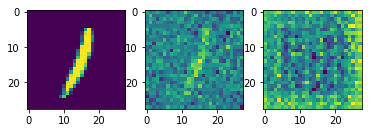

Epoch 0, Iteration 500, loss 0.135


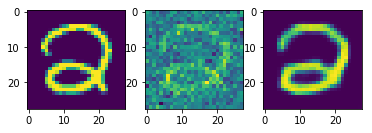

Epoch 0, Iteration 1000, loss 0.107


Epoch 0, Iteration 1500, loss 0.124


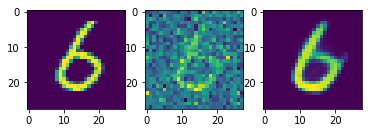

Epoch 0, Iteration 2000, loss 0.120


Epoch 0, Iteration 2500, loss 0.123


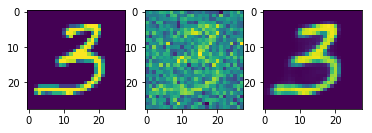

Epoch 1, Iteration 0, loss 0.112


Epoch 1, Iteration 500, loss 0.114


Epoch 1, Iteration 1000, loss 0.109


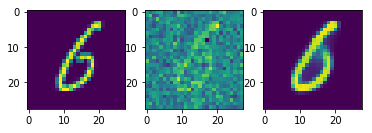

Epoch 1, Iteration 1500, loss 0.114


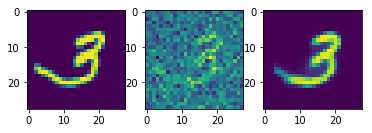

Epoch 1, Iteration 2000, loss 0.115


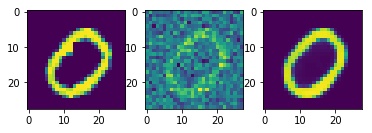

Epoch 1, Iteration 2500, loss 0.116


Epoch 2, Iteration 0, loss 0.114


Epoch 2, Iteration 500, loss 0.113


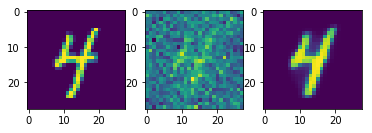

Epoch 2, Iteration 1000, loss 0.113


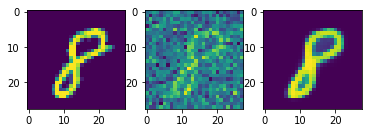

Epoch 2, Iteration 1500, loss 0.110


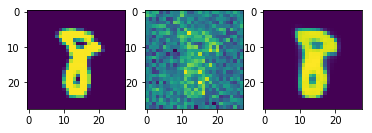

Epoch 2, Iteration 2000, loss 0.118


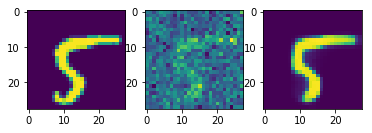

Epoch 2, Iteration 2500, loss 0.110


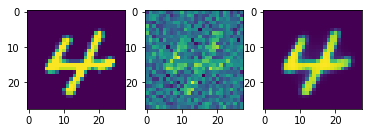

In [392]:
for epoch in range(model.nb_epochs):
    randomize = np.arange(model.x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    for i in range(model.nb_iterations):
        for r in range(10):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , denoised, noisy, loss, loss_summ= sess.run([model.trainer, model.recon_im, model.im_n, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train})
#         print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))

        if i % 500 == 0:
            print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))
            fig, ax = plt.subplots(nrows=1, ncols=3)
            ax[0].imshow(input_x_train[0].reshape(28,28))
            ax[1].imshow(noisy[0].reshape(28,28))
            ax[2].imshow(denoised[0].reshape(28,28))
            plt.show()
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch) 
end = time.time()

### Task 8 - Building a Variational AutoEncoder (VAE) 12 Points

<br>

#### Why use a VAE?

<br>

<p style='text-align: justify;'>
Building on the standard AutoEncoder which was a way of learning some lower dimensional manifold the data could lie on, we want to impose a form of regularisation, that is, we want some topology structure. We want inputs to the AutoEncoder that have a certain structure to be mapped to similar areas in this lower dimensional latent space. But the standard AutoEncoder merely learns how to essentially compress data. In this task, we are interested in learning a more structured latent space where we can sample in this space to then generate a new image that theoretically belongs to the same dataset.
    
In this exercise, we will assume the structure in the latent space follows a standard bi-variate Gaussian i.e. mean $\begin{bmatrix}0\\0\end{bmatrix}$ and covariance $\begin{bmatrix}1&0\\0&1\end{bmatrix}$. This assumption is for simplicity but we can infact assume other distributions (outside the scope for this exercise). We will be using the MNIST dataset for this task.
    
</p>

<br>

#### Architecture

<img src="vae-diagram.png" alt="The Variational AutoEncoder" title="VAE Architecture" />

<br>

#### Notation

<br>

Before diving into some maths, lets define a few terms:
1. $\mathbf{X}$: the dataset distribution we wish to generate from
2. $\mathbf{z}$: the compressed latent variable which quantifies a set of attributes of our dataset
3. $\boldsymbol{\theta}$ : the parameters for the ***encoder*** network
4. $\boldsymbol{\phi}$: the parameters for the ***decoder*** network
5. $p(\mathbf{z})$: the probability of the compressed latent space (given it should follow a standard normal)
6. $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{X})$: the conditional probability distribution of sampling the compressed latent variable given the dataset approximated by our encoder network with parameters $\boldsymbol{\phi}$
7. $p_{\boldsymbol{\theta}}(\mathbf{X}|\mathbf{z})$: the conditional probability distribution of generating the dataset given the compressed latent space by our decoder network with parameters $\boldsymbol{\theta}$

<br>

#### Optimisation

<br>

The quantity we are interested in maximising for the $i$-th observation is:

$
\begin{align}
    \log p (\mathbf{x}_i) && \text{which can be rewritten as...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p (\mathbf{x}_i) \text{d}\mathbf{z} & \text{as the integral over a distribution is 1...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)[\log p (\mathbf{z}|\mathbf{x}_i) - \log p(\mathbf{z}) + \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})]\text{d}\mathbf{z} & \text{consider Baye's rule...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log \frac{p (\mathbf{z}|\mathbf{x}_i)}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} - q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)\log \frac{p (\mathbf{z})}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} + q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})\text{d}\mathbf{z}\\
    &= \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) - \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z})) + \mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]\\
    &=  \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) + \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) &\text{where the last two terms have been grouped as $\mathcal{L}$}
\end{align}
$

<br>


As the first term in the line above is intractable to compute, we can say that $\log p_\boldsymbol{\theta} (\mathbf{x}_i) \ge \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ as the KL-divergence is a distance measure (and hence non-negative) and $\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ is known as the **variational lower bound**. Instead of maximising the log probability directly, we can instead maximise this lower bound! If you are unfamiliar with the KL-divergence, check out this [Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

<br>

The lower bound can be clearly seen as two main components:

$
\begin{align}
\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) = \color{blue}{\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]} - \color{green}{\text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}))}
\end{align}
$
+ <font color='blue'> How well can we reconstruct our original data from the latent space?</font>
+ <font color='green'> How similar is the latent space to a standard Gaussian?</font>

A remark on the second point - we are trying to find a Gaussian distribution manifold in latent space for our dataset. This is known as a *variational* method which should be part of the Bayesian Machine Learning module.

<br>

#### Derivations

Given that $\mathbf{\hat{x}}_i$ is a draw from $p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})\sim\mathcal{N}(\mathbf{x},\sigma^2\mathbf{I})$, the expectation of $\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})$ can be computed as:

$
\begin{align}
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})] &= -\frac{m}{2}\log 2\pi\sigma^2 - \frac{1}{2}(\mathbf{\hat{x}}_i - \mathbf{x}_i)^\text{T}(\sigma^2\mathbf{I})^{-1}(\mathbf{\hat{x}}_i - \mathbf{x}_i)\\
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{Z}|\mathbf{X})} [\log p_{\boldsymbol{\theta}} (\mathbf{X}|\mathbf{Z})] &\propto \sum_{i = 1}^{i = n}\sum_{j = 1}^{j = m} (\hat{x}_{ij} - x_{ij})^2 & \text{as everything else is just a constant}
\end{align}
$

<font color='red'>Given that $q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i) \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I})$, derive the KL-divergence term between this and $p_\boldsymbol{\theta} (\mathbf{z})$ i.e. $\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I}))$:</font>

$
\begin{align}
\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I})) &= \int_{\mathbf{z}\in\mathcal{Z}} ?\text{ d}\mathbf{z}
\end{align}
$

Further readings: There are many useful online tutorials that provide deep insight as how VAEs work or to implement them; for instace [tutorial1](https://arxiv.org/abs/1606.05908) [tutorial2](http://ruishu.io/2018/03/14/vae/). 

#### Defining the Data and Helper Functions

In [495]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_size       = x_train.shape[1]
original_dim     = image_size * image_size

# Flatten each image to be a vector (you can try convolutional layers as an extension)
x_train          = np.reshape(x_train, [-1, original_dim])
x_test           = np.reshape(x_test, [-1, original_dim])
x_train          = x_train.astype('float32') / 255
x_test           = x_test.astype('float32') / 255

# Visualisation parameters (for after the implementation of the VAE - start playing with these after the VAE seems to work!)
n                = 29 # Number of digits to show per row / col
dsize            = 28 # Digit size

z1               = norm.ppf(np.linspace(0.01, 0.99, n))
z2               = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid           = np.dstack(np.meshgrid(z1, z2))

Zf               = lambda x : sess.run(z_mean, feed_dict = {t_X : x})
Xf               = lambda z_grid : sess.run(t_X_hat, feed_dict = {z : z_grid.reshape(n * n, nlatent)}).reshape(n, n, dsize, dsize)

def get_batch(*args, size):
    """ Loops through each argument in batches of [size] """
    
    n = len(args[0])
    if size is None or size >= n:
        yield from args
        return None
    r = np.random.permutation(n)
    for i in range(n // size + 1):
        yield(arg[r[i * size : (i + 1) * size]] for arg in args)



def visualise(X, y, sep = 2):
    #     """ Visualise the mapped 2D manifold """
    # Feel free to modify this code for your visualisations...
    Z  = Zf(x_test)
    Xh = Xf(z_grid)

    plt.figure(figsize = (12, 10))
    plt.scatter(Z[:, 0], Z[:, 1], c = y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")

    plt.figure(figsize = (12, 10))
    plt.imshow(np.block(list(map(list, Xh))), cmap = 'gray')
    start_range    = dsize // 2
    end_range      = n * dsize + start_range
    pixel_range    = np.arange(start_range, end_range, dsize)
    sample_range_x = np.round(z1, 2)
    sample_range_y = np.round(z2, 2)
    plt.xticks(pixel_range[::sep], sample_range_x[::sep])
    plt.yticks(pixel_range[::sep], sample_range_y[::sep])

#### Task 8.1 Implementation of VAE

<br>

The simpler implementation of the VAE is to build off the MLP i.e. no convolutional layers. The code below is designed for this but feel free to swap out this assumption for convolutions should you feel more confident. Feel free to add `tf.summary` definitions in a similar way to previous tasks for tensorboard visualisations.

 #### Note: If implementing task 8.1 in TF (as guided bellow) is not straightforward for you, use an easier option: [Keras](https://keras.io/examples/variational_autoencoder/) implementation of VAE. In these case, you will be marked down 4 points but you can immediately proceed to task 8.2. 

In [497]:
# Hyperparameters...
layers   = [512, 256, 128]
nlatent  = 2
batch    = 64
epochs   = 20
alpha    = 1e-3

# General dtype to use
dtype    = 'float32'

# Number of features
m        = x_train.shape[1]

# Reset the graph to ensure blank graph initially...
tf.reset_default_graph()

# Define placeholder for 'X' data
t_X      = tf.placeholder(dtype = dtype, shape = [None, m], name = 'X')

# Define how t_X maps to the layer before the latent space
with tf.name_scope('Encoder'):
    h        = t_X
    for i, layer in enumerate(layers, 1):
        with tf.name_scope(f'Layer_{i}'):
            ######### Map how we get from the previous layer to the next hidden layer #########
            h    = tf.layers.dense(inputs=h, units=layer, activation=tf.nn.relu)
    
# Define how we get the mean and variance from the previous hidden layer
with tf.name_scope('Latent'):
    with tf.name_scope('Mean'):
        z_mean   = tf.layers.dense(inputs=h, units= nlatent)

    with tf.name_scope('Variance'):
        z_var    = tf.layers.dense(inputs=h, units= nlatent)
        
    # Code the "reparameterisation trick"
    with tf.name_scope('Sample'):
        epsilon  = tf.random.normal(shape=(batch,nlatent), mean=0.)
        z_sample = z_mean + tf.exp(z_var/2) * epsilon
        z        = tf.placeholder_with_default(z_sample, shape = [None, nlatent], name = 'z')
    
# Define how "z" decodes to our reconstructed "t_X" estimate
with tf.name_scope('Decoder'):
    h        = z
    for i, layer in enumerate(layers[::-1], 1):
        with tf.name_scope(f'Layer_{i}'):
            h    = tf.layers.dense(inputs=h, units=layer, activation=tf.nn.relu)
    
    with tf.name_scope('Final'):
        t_X_hat  = tf.layers.dense(inputs=h, units=m, activation=tf.nn.sigmoid)

# Define the loss function as defined in the derivation section
with tf.name_scope('Loss'):
    with tf.name_scope('AutoEncoder'):
        # The normal AutoEncoder loss should measure how far our t_X_hat is from t_X
        loss_ae  = -tf.reduce_sum(t_X * tf.log(1e-10 + t_X_hat)
                           + (1-t_X) * tf.log(1e-10 + 1 - t_X_hat),
                           1)

        
    with tf.name_scope('KL_Divergence'):
        # The KL-divergence between z and a standard normal you derived earlier
        loss_kl  = -0.5 * tf.reduce_sum(1 + z_var 
                                           - tf.square(z_mean) 
                                           - tf.exp(z_var), 1)
        
    loss = tf.reduce_mean(loss_ae + loss_kl, name = 'loss')

# Define final components before training the model
optim    = tf.train.AdamOptimizer(alpha).minimize(loss)
train    = {t_X : x_train}

sess     = tf.InteractiveSession()
writer   = tf.summary.FileWriter('./VAE_MLP_logdir', sess.graph)
sess.run(tf.global_variables_initializer())

# Gradient descent loop with verbose loss check...
# Hopefully we see our loss reduce!
for i in range(epochs):
    losses  = []
    for xb, in get_batch(x_train, size = batch):
        nb = len(xb)
        if nb != batch:
            continue
        sess.run(optim, feed_dict = {t_X : xb})
        losses.append(nb * sess.run(loss, feed_dict = {t_X : xb}))
        print(f'\rIteration {i:2d}: loss = {losses[-1] / nb:6,.2f}', end = '')
    print(f'\rIteration {i:2d}: loss = {sum(losses) / len(x_train):6,.2f}')

Iteration  0: loss = 175.90
Iteration  1: loss = 155.48
Iteration  2: loss = 149.32
Iteration  3: loss = 146.20
Iteration  4: loss = 143.96
Iteration  5: loss = 142.71
Iteration  6: loss = 141.79
Iteration  7: loss = 140.75
Iteration  8: loss = 139.93
Iteration  9: loss = 139.56
Iteration 10: loss = 139.01
Iteration 11: loss = 138.85
Iteration 12: loss = 138.60
Iteration 13: loss = 138.01
Iteration 14: loss = 137.64
Iteration 15: loss = 137.87
Iteration 16: loss = 137.77
Iteration 17: loss = 137.31
Iteration 18: loss = 136.85
Iteration 19: loss = 136.75


#### Visualisation Check

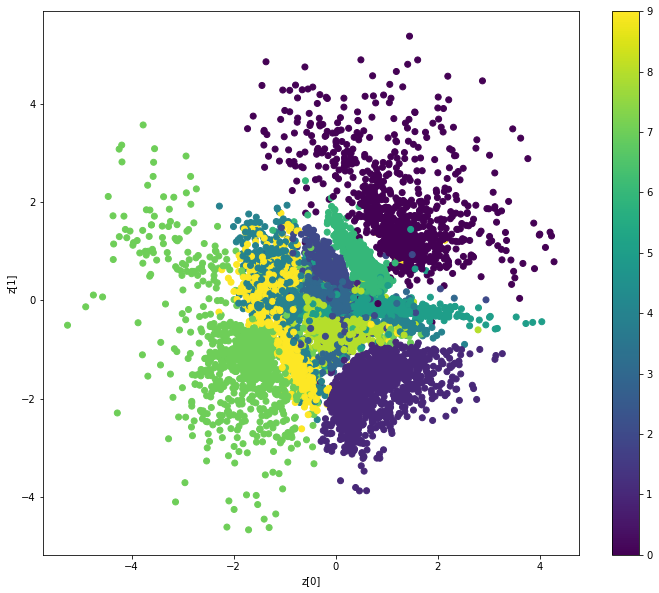

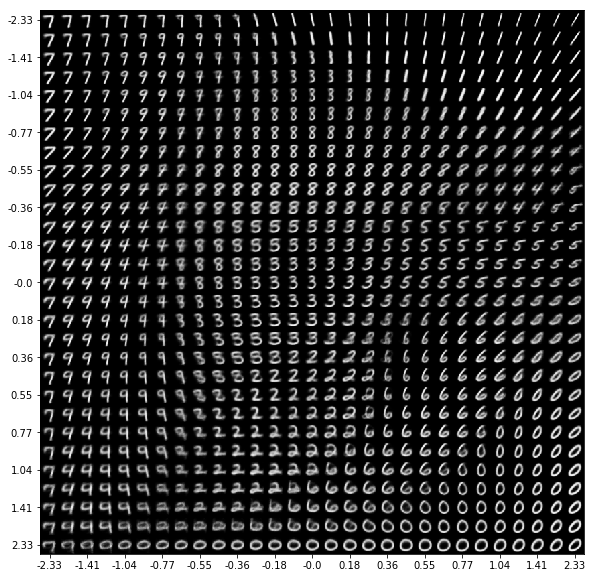

In [498]:
visualise(x_test, y_test)

####  Task 8.2

<br>

 - Plot the learning curve for your VAE
 - Generate new handwritten digits from your model by sampling `Z` = $\mathbf{z}\in\mathbb{R}^{n,2}$ and running `sess.run(t_X_hat, feed_dict = {z : Z))` in a separate code cell
     - Discuss how good / bad are these images?
         - Why are they good / bad? (consider the assumptions of your implementation of the VAE)
 - From observing your learnt manifold (by using the `visualise` function or otherwise), draw a comparison between the direct mapped points on your manifold (scatter plot) and the images that lay on the manifold (imshow)
     - Why are some points images more mixed than others?
     - Can we be smarter in where we should sample to get *better* generated handwritten digits?

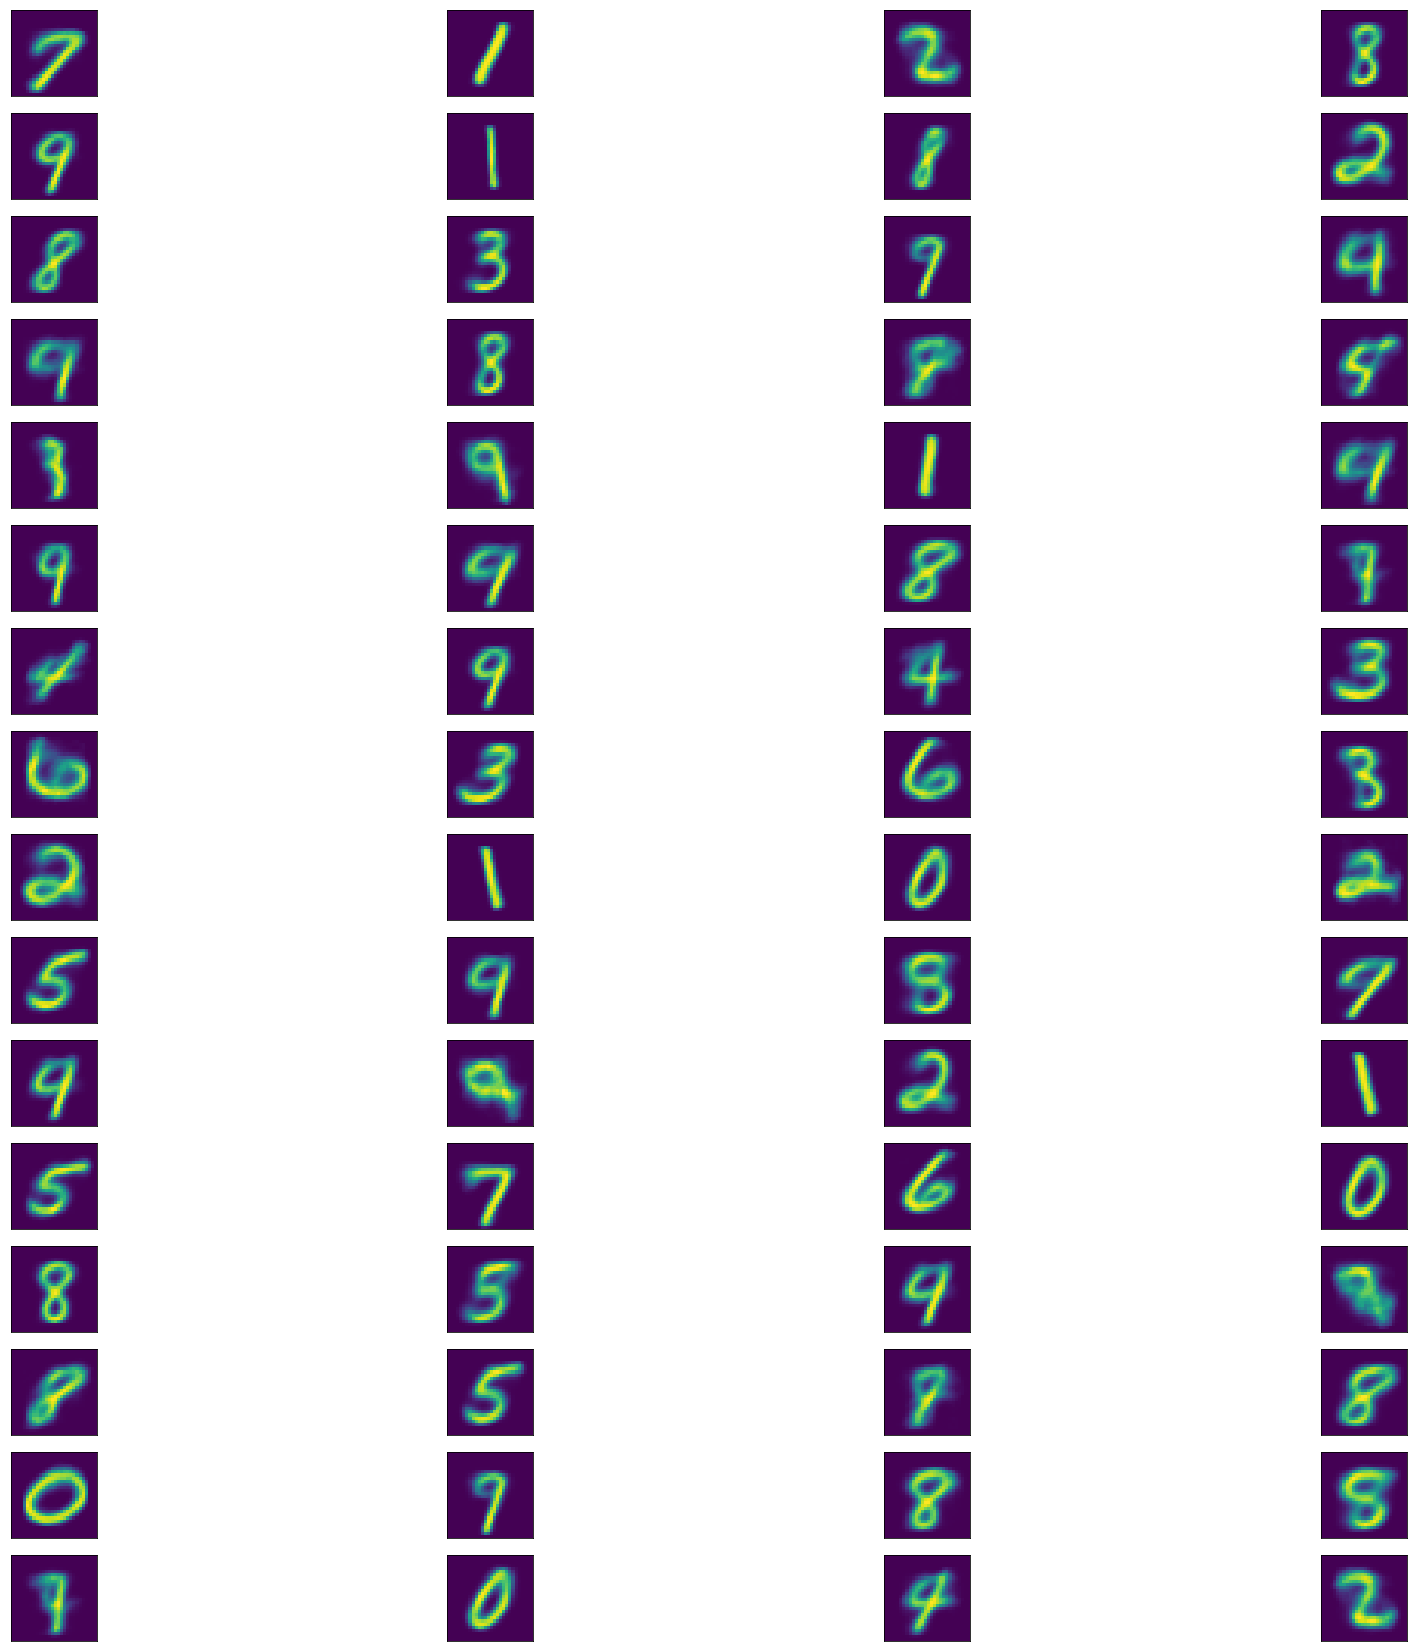

In [530]:
Z = np.random.normal(size=(batch,nlatent),loc=0, scale=1)
generated = sess.run(t_X_hat, feed_dict={z: Z})



fig, ax = plt.subplots(nrows=batch//4, ncols=4, figsize=(30,30))
counter = 0
for row in ax:
    for col in row:
        col.imshow(generated[counter].reshape(28,28))
        col.set_xticks([])
        col.set_yticks([])
        counter += 1
#             ax[0].imshow(input_x_train[0].reshape(28,28))
#             ax[1].imshow(noisy[0].reshape(28,28))
#             ax[2].imshow(denoised[0].reshape(28,28))
plt.imshow(generated[2].reshape(28,28))